## Enabling and testing the GPU

Check GPU from tf

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
6.078475683999983
GPU (s):
0.05752683799997271
GPU speedup over CPU: 105x


# **1. Prepare dataset**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
import shutil

shutil.copy("/content/gdrive/MyDrive/Documents/Rakamin id x partners/loan_data_2007_2014.csv", "/content/loan_data_2007_2014.csv")

'/content/loan_data_2007_2014.csv'

In [6]:
import pandas as pd
import numpy as np

In [7]:
loan_data_backup = pd.read_csv('loan_data_2007_2014.csv')
loan_data_backup.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Unnamed: 0       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0           0  1077501    1296599       5000         5000           4975.0   
1           1  1077430    1314167       2500         2500           2500.0   
2           2  1077175    1313524       2400         2400           2400.0   
3           3  1076863    1277178      10000        10000          10000.0   
4           4  1075358    1311748       3000         3000           3000.0   

         term  int_rate  installment grade  ... total_bal_il il_util  \
0   36 months     10.65       162.87     B  ...          NaN     NaN   
1   60 months     15.27        59.83     C  ...          NaN     NaN   
2   36 months     15.96        84.33     C  ...          NaN     NaN   
3   36 months     13.49       339.31     C  ...          NaN     NaN   
4   60 months     12.69        67.79     B  ...          NaN     NaN   

  open_rv_12m open_rv_24m  max_bal_bc all_util total_rev_hi_lim inq_fi  \
0         NaN         NaN         NaN      NaN              NaN    NaN   
1         NaN         NaN         NaN      NaN              NaN    NaN   
2         NaN         NaN         NaN      NaN              NaN    NaN   
3         NaN         NaN         NaN      NaN              NaN    NaN   
4         NaN         NaN         NaN      NaN              NaN    NaN   

  total_cu_tl inq_last_12m  
0         NaN          NaN  
1         NaN          NaN  
2         NaN          NaN  
3         NaN          NaN  
4         NaN          NaN  

[5 rows x 75 columns]

In [8]:
loan_data=loan_data_backup.copy()

In [9]:
pd.options.display.max_columns=None
loan_data

Unnamed: 0       id  member_id  loan_amnt  funded_amnt  \
0                0  1077501    1296599       5000         5000   
1                1  1077430    1314167       2500         2500   
2                2  1077175    1313524       2400         2400   
3                3  1076863    1277178      10000        10000   
4                4  1075358    1311748       3000         3000   
...            ...      ...        ...        ...          ...   
466280      466280  8598660    1440975      18400        18400   
466281      466281  9684700   11536848      22000        22000   
466282      466282  9584776   11436914      20700        20700   
466283      466283  9604874   11457002       2000         2000   
466284      466284  9199665   11061576      10000        10000   

        funded_amnt_inv        term  int_rate  installment grade sub_grade  \
0                4975.0   36 months     10.65       162.87     B        B2   
1                2500.0   60 months     15.27        59.83     C        C4   
2                2400.0   36 months     15.96        84.33     C        C5   
3               10000.0   36 months     13.49       339.31     C        C1   
4                3000.0   60 months     12.69        67.79     B        B5   
...                 ...         ...       ...          ...   ...       ...   
466280          18400.0   60 months     14.47       432.64     C        C2   
466281          22000.0   60 months     19.97       582.50     D        D5   
466282          20700.0   60 months     16.99       514.34     D        D1   
466283           2000.0   36 months      7.90        62.59     A        A4   
466284           9975.0   36 months     19.20       367.58     D        D3   

                                    emp_title emp_length home_ownership  \
0                                         NaN  10+ years           RENT   
1                                       Ryder   < 1 year           RENT   
2                                         NaN  10+ years           RENT   
3                         AIR RESOURCES BOARD  10+ years           RENT   
4                    University Medical Group     1 year           RENT   
...                                       ...        ...            ...   
466280                     Financial Advisor     4 years       MORTGAGE   
466281  Chief of Interpretation (Park Ranger)  10+ years       MORTGAGE   
466282                                 patrol    7 years       MORTGAGE   
466283                   Server Engineer Lead    3 years            OWN   
466284                                    NaN  10+ years       MORTGAGE   

        annual_inc verification_status issue_d  loan_status pymnt_plan  \
0          24000.0            Verified  Dec-11   Fully Paid          n   
1          30000.0     Source Verified  Dec-11  Charged Off          n   
2          12252.0        Not Verified  Dec-11   Fully Paid          n   
3          49200.0     Source Verified  Dec-11   Fully Paid          n   
4          80000.0     Source Verified  Dec-11      Current          n   
...            ...                 ...     ...          ...        ...   
466280    110000.0     Source Verified  Jan-14      Current          n   
466281     78000.0            Verified  Jan-14  Charged Off          n   
466282     46000.0            Verified  Jan-14      Current          n   
466283     83000.0            Verified  Jan-14   Fully Paid          n   
466284     46000.0            Verified  Jan-14      Current          n   

                                                      url  \
0       https://www.lendingclub.com/browse/loanDetail....   
1       https://www.lendingclub.com/browse/loanDetail....   
2       https://www.lendingclub.com/browse/loanDetail....   
3       https://www.lendingclub.com/browse/loanDetail....   
4       https://www.lendingclub.com/browse/loanDetail....   
...                                                   ...   
466280  https://www.lendingclub.com/browse/loanDetail....   


In [10]:
loan_data.select_dtypes(include=['object']).describe().T

count  unique  \
term                 466285       2   
grade                466285       7   
sub_grade            466285      35   
emp_title            438697  205475   
emp_length           445277      11   
home_ownership       466285       6   
verification_status  466285       3   
issue_d              466285      91   
loan_status          466285       9   
pymnt_plan           466285       2   
url                  466285  466285   
desc                 125983  124436   
purpose              466285      14   
title                466265   63099   
zip_code             466285     888   
addr_state           466285      50   
earliest_cr_line     466256     664   
initial_list_status  466285       2   
last_pymnt_d         465909      98   
next_pymnt_d         239071     100   
last_credit_pull_d   466243     103   
application_type     466285       1   

                                                                   top    freq  
term                                                         36 months  337953  
grade                                                                B  136929  
sub_grade                                                           B3   31686  
emp_title                                                      Teacher    5399  
emp_length                                                   10+ years  150049  
home_ownership                                                MORTGAGE  235875  
verification_status                                           Verified  168055  
issue_d                                                         Oct-14   38782  
loan_status                                                    Current  224226  
pymnt_plan                                                           n  466276  
url                  https://www.lendingclub.com/browse/loanDetail....       1  
desc                                                                       234  
purpose                                             debt_consolidation  274195  
title                                               Debt consolidation  164075  
zip_code                                                         945xx    5304  
addr_state                                                          CA   71450  
earliest_cr_line                                                Oct-00    3674  
initial_list_status                                                  f  303005  
last_pymnt_d                                                    Jan-16  179620  
next_pymnt_d                                                    Feb-16  208393  
last_credit_pull_d                                              Jan-16  327699  
application_type                                            INDIVIDUAL  466285

In [11]:
loan_data.select_dtypes(include=np.number).describe().T

count          mean           std       min  \
Unnamed: 0                   466285.0  2.331420e+05  1.346050e+05      0.00   
id                           466285.0  1.307973e+07  1.089371e+07  54734.00   
member_id                    466285.0  1.459766e+07  1.168237e+07  70473.00   
loan_amnt                    466285.0  1.431728e+04  8.286509e+03    500.00   
funded_amnt                  466285.0  1.429180e+04  8.274371e+03    500.00   
funded_amnt_inv              466285.0  1.422233e+04  8.297638e+03      0.00   
int_rate                     466285.0  1.382924e+01  4.357587e+00      5.42   
installment                  466285.0  4.320612e+02  2.434855e+02     15.67   
annual_inc                   466281.0  7.327738e+04  5.496357e+04   1896.00   
dti                          466285.0  1.721876e+01  7.851121e+00      0.00   
delinq_2yrs                  466256.0  2.846784e-01  7.973651e-01      0.00   
inq_last_6mths               466256.0  8.047446e-01  1.091598e+00      0.00   
mths_since_last_delinq       215934.0  3.410443e+01  2.177849e+01      0.00   
mths_since_last_record        62638.0  7.430601e+01  3.035765e+01      0.00   
open_acc                     466256.0  1.118707e+01  4.987526e+00      0.00   
pub_rec                      466256.0  1.605642e-01  5.108626e-01      0.00   
revol_bal                    466285.0  1.623020e+04  2.067625e+04      0.00   
revol_util                   465945.0  5.617695e+01  2.373263e+01      0.00   
total_acc                    466256.0  2.506443e+01  1.160014e+01      1.00   
out_prncp                    466285.0  4.410062e+03  6.355079e+03      0.00   
out_prncp_inv                466285.0  4.408452e+03  6.353198e+03      0.00   
total_pymnt                  466285.0  1.154069e+04  8.265627e+03      0.00   
total_pymnt_inv              466285.0  1.146989e+04  8.254158e+03      0.00   
total_rec_prncp              466285.0  8.866015e+03  7.031688e+03      0.00   
total_rec_int                466285.0  2.588677e+03  2.483810e+03      0.00   
total_rec_late_fee           466285.0  6.501292e-01  5.265730e+00      0.00   
recoveries                   466285.0  8.534421e+01  5.522161e+02      0.00   
collection_recovery_fee      466285.0  8.961534e+00  8.549144e+01      0.00   
last_pymnt_amnt              466285.0  3.123914e+03  5.554737e+03      0.00   
collections_12_mths_ex_med   466140.0  9.085253e-03  1.086484e-01      0.00   
mths_since_last_major_derog   98974.0  4.285255e+01  2.166259e+01      0.00   
policy_code                  466285.0  1.000000e+00  0.000000e+00      1.00   
annual_inc_joint                  0.0           NaN           NaN       NaN   
dti_joint                         0.0           NaN           NaN       NaN   
verification_status_joint         0.0           NaN           NaN       NaN   
acc_now_delinq               466256.0  4.002093e-03  6.863680e-02      0.00   
tot_coll_amt                 396009.0  1.919135e+02  1.463021e+04      0.00   
tot_cur_bal                  396009.0  1.388017e+05  1.521147e+05      0.00   
open_acc_6m                       0.0           NaN           NaN       NaN   
open_il_6m                        0.0           NaN           NaN       NaN   
open_il_12m                       0.0           NaN           NaN       NaN   
open_il_24m                       0.0           NaN           NaN       NaN   
mths_since_rcnt_il                0.0           NaN           NaN       NaN   
total_bal_il                      0.0           NaN           NaN       NaN   
il_util                           0.0           NaN           NaN       NaN   
open_rv_12m                       0.0           NaN           NaN       NaN   
open_rv_24m                       0.0           NaN           NaN       NaN   
max_bal_bc                        0.0           NaN           NaN       NaN   
all_util                          0.0           NaN           NaN       NaN   
total_rev_hi_lim             396009.0  3.037909e+04  3.724713e+04      0.00   
inq

# **2. Data Cleaning**

## **Drop missing values**

In [12]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [13]:
loan_data.drop(columns=[
    "annual_inc_joint", "dti_joint", "verification_status_joint", "open_acc_6m", "open_il_6m",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il", "il_util", "open_rv_12m", 
    "open_rv_24m", "max_bal_bc", "all_util", "inq_fi", "total_cu_tl", "inq_last_12m"
], inplace=True)

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

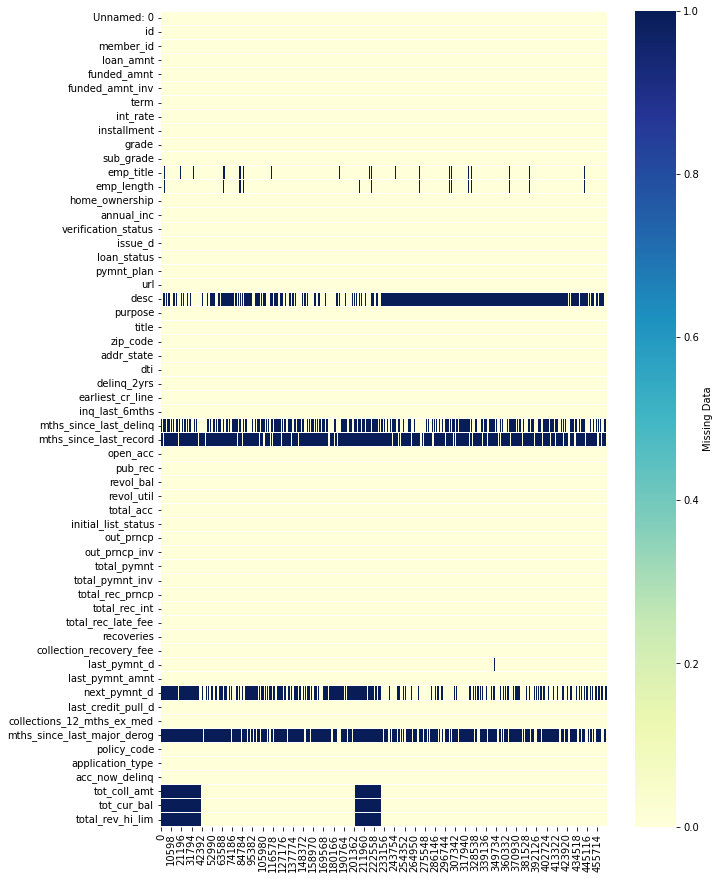

In [15]:
plt.figure(figsize=(10,15))
sns.heatmap(loan_data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [16]:
loan_data.drop(columns=[
    "mths_since_last_delinq", "mths_since_last_record", "next_pymnt_d", "mths_since_last_major_derog", "desc"
], inplace=True)

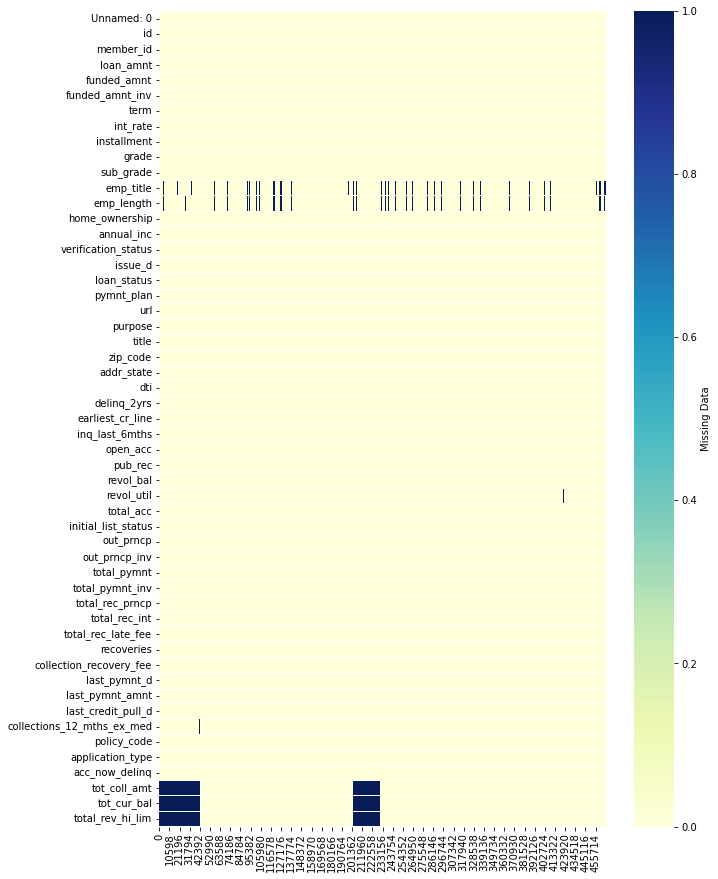

In [17]:
plt.figure(figsize=(10,15))
sns.heatmap(loan_data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [18]:
loan_data.isnull().sum() 

Unnamed: 0                        0
id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_title                     27588
emp_length                    21008
home_ownership                    0
annual_inc                        4
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
url                               0
purpose                           0
title                            20
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                      29
earliest_cr_line                 29
inq_last_6mths              

In [19]:
loan_data['verification_status'].value_counts()

Verified           168055
Source Verified    149993
Not Verified       148237
Name: verification_status, dtype: int64

In [20]:
loan_data[['tot_coll_amt','tot_cur_bal','total_rev_hi_lim']].isnull().sum()

tot_coll_amt        70276
tot_cur_bal         70276
total_rev_hi_lim    70276
dtype: int64

In [21]:
loan_data[['tot_coll_amt','tot_cur_bal','total_rev_hi_lim','verification_status']]

tot_coll_amt  tot_cur_bal  total_rev_hi_lim verification_status
0                NaN          NaN               NaN            Verified
1                NaN          NaN               NaN     Source Verified
2                NaN          NaN               NaN        Not Verified
3                NaN          NaN               NaN     Source Verified
4                NaN          NaN               NaN     Source Verified
...              ...          ...               ...                 ...
466280           0.0     294998.0           29900.0     Source Verified
466281           0.0     221830.0           39400.0            Verified
466282           0.0      73598.0           13100.0            Verified
466283           0.0     591610.0           53100.0            Verified
466284           0.0      57477.0           16000.0            Verified

[466285 rows x 4 columns]

In [22]:
loan_data[['tot_coll_amt','tot_cur_bal','total_rev_hi_lim','verification_status']][(loan_data['verification_status']=='Not Verified')|(loan_data['verification_status']=='Source Verified')]

tot_coll_amt  tot_cur_bal  total_rev_hi_lim verification_status
1                NaN          NaN               NaN     Source Verified
2                NaN          NaN               NaN        Not Verified
3                NaN          NaN               NaN     Source Verified
4                NaN          NaN               NaN     Source Verified
5                NaN          NaN               NaN     Source Verified
...              ...          ...               ...                 ...
466268           0.0      61201.0           32700.0     Source Verified
466274           0.0       9557.0           17100.0     Source Verified
466278           0.0      10170.0           11100.0     Source Verified
466279           0.0      20140.0           17600.0     Source Verified
466280           0.0     294998.0           29900.0     Source Verified

[298230 rows x 4 columns]

In [23]:
loan_data[['tot_coll_amt','tot_cur_bal','total_rev_hi_lim','verification_status']][(loan_data['verification_status']=='Not Verified')|(loan_data['verification_status']=='Source Verified')].isnull().sum()

tot_coll_amt           46733
tot_cur_bal            46733
total_rev_hi_lim       46733
verification_status        0
dtype: int64

In [24]:
loan_data[['tot_coll_amt','tot_cur_bal','total_rev_hi_lim','verification_status']][(loan_data['verification_status']=='Verified')].isnull().sum()

tot_coll_amt           23543
tot_cur_bal            23543
total_rev_hi_lim       23543
verification_status        0
dtype: int64

In [25]:
loan_data.isnull().sum()

Unnamed: 0                        0
id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_title                     27588
emp_length                    21008
home_ownership                    0
annual_inc                        4
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
url                               0
purpose                           0
title                            20
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                      29
earliest_cr_line                 29
inq_last_6mths              

In [26]:
import missingno as msno

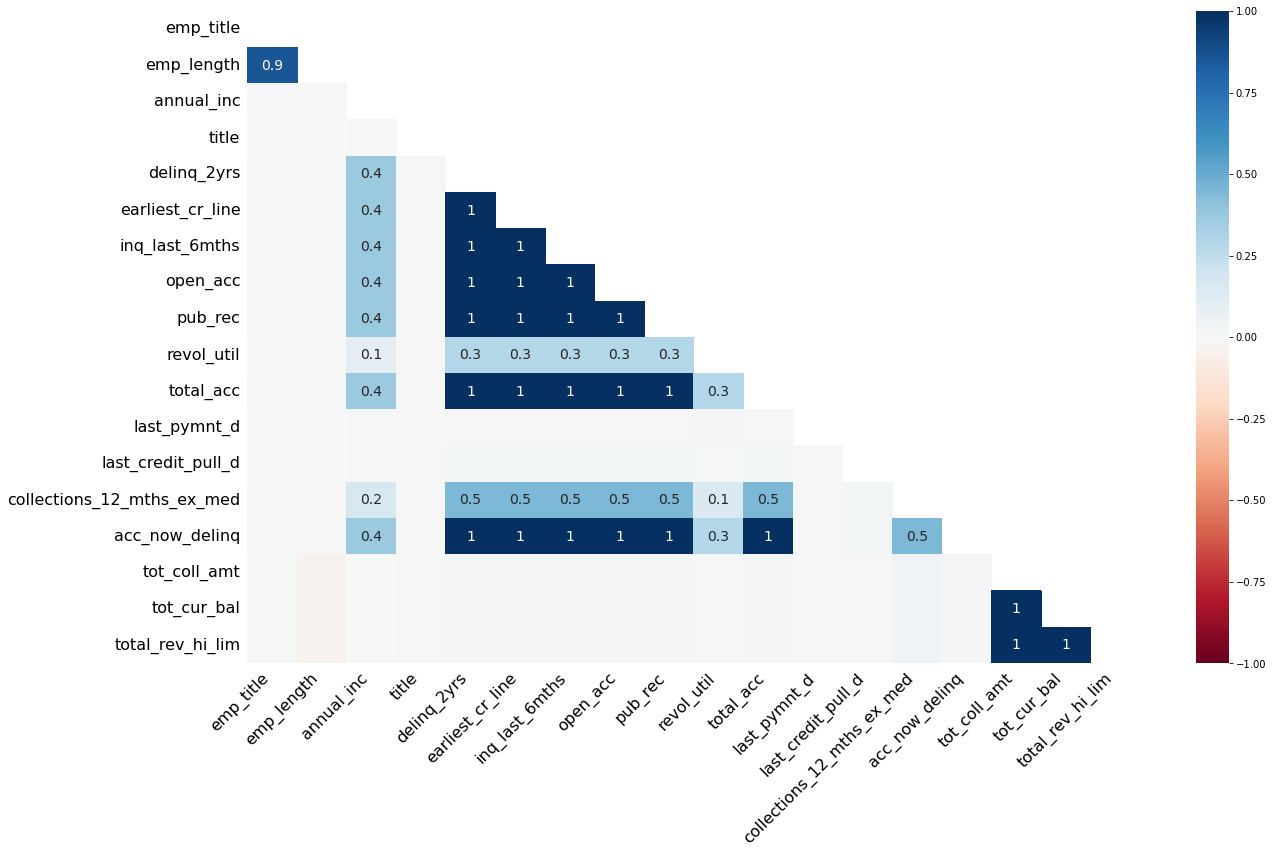

In [27]:
msno.heatmap(loan_data)

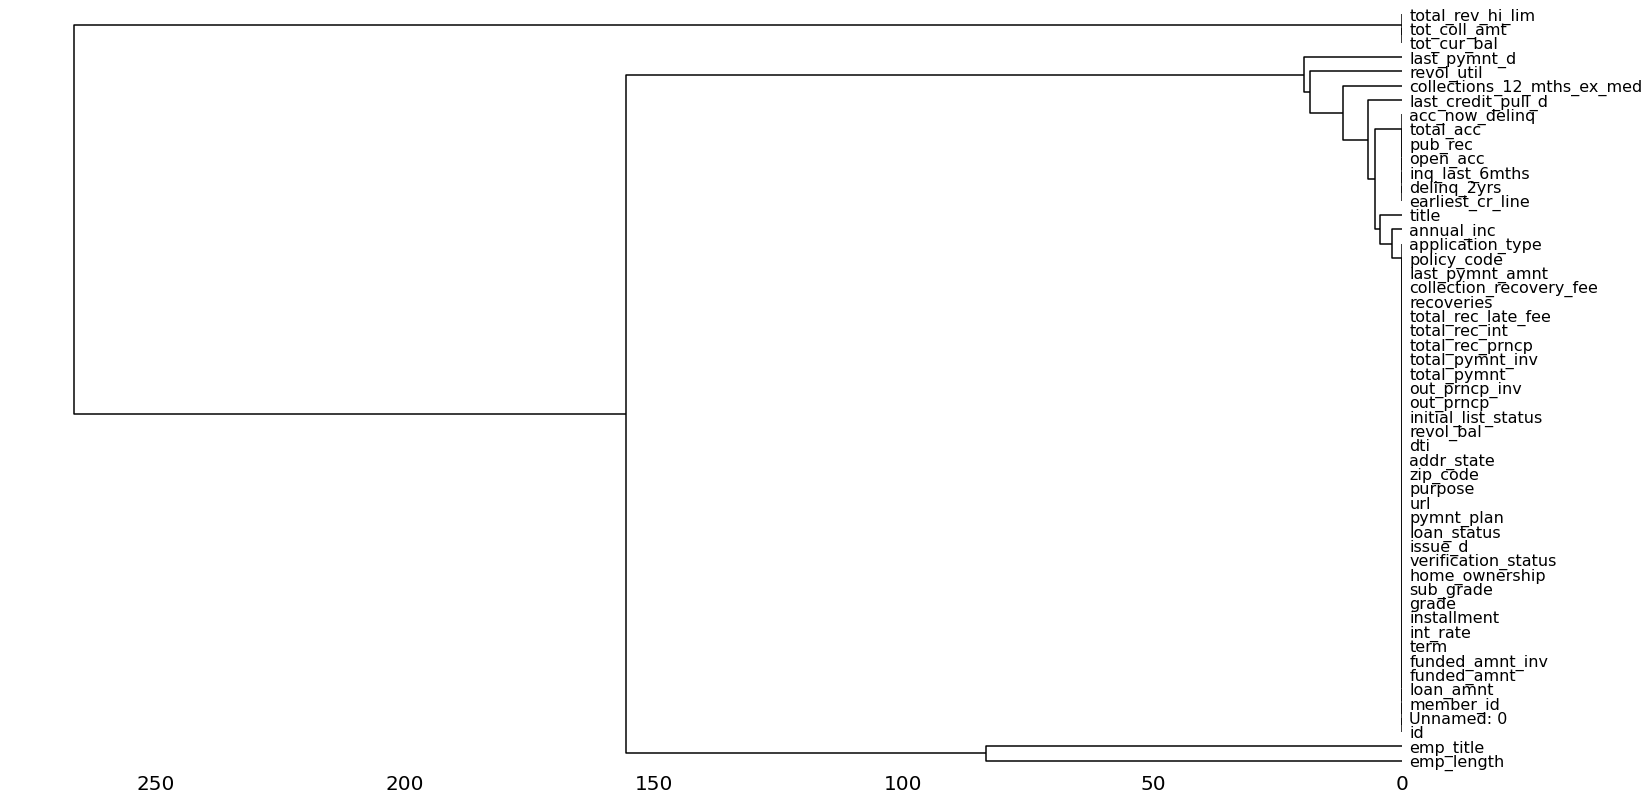

In [28]:
msno.dendrogram(loan_data)

In [29]:
loan_data.dropna(subset=[
    'emp_length', 'title', 'last_pymnt_d', 'last_credit_pull_d', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'
], inplace=True)

In [30]:
loan_data.isnull().sum()

Unnamed: 0                       0
id                               0
member_id                        0
loan_amnt                        0
funded_amnt                      0
funded_amnt_inv                  0
term                             0
int_rate                         0
installment                      0
grade                            0
sub_grade                        0
emp_title                     4409
emp_length                       0
home_ownership                   0
annual_inc                       0
verification_status              0
issue_d                          0
loan_status                      0
pymnt_plan                       0
url                              0
purpose                          0
title                            0
zip_code                         0
addr_state                       0
dti                              0
delinq_2yrs                      0
earliest_cr_line                 0
inq_last_6mths                   0
open_acc            

In [31]:
loan_data['revol_util'].unique()

array([ 61.2,  52.8,  21.6, ..., 111.3, 113. , 141.8])

In [32]:
loan_data.shape

(376775, 53)

## **Impute nilai NaN** 

In [33]:
from sklearn.impute import SimpleImputer

In [34]:
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(loan_data[['revol_util']])
loan_data['revol_util'] = imp_mean.transform(loan_data[['revol_util']])

imp_frek = SimpleImputer(strategy='most_frequent')
imp_frek.fit(loan_data[['emp_title']])
loan_data['emp_title'] = imp_frek.transform(loan_data[['emp_title']])
loan_data.head()

Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
42535       42535  10149342   12000897      27050        27050   
42536       42536  10159584   12011200       9750         9750   
42537       42537  10159498    1319523      12000        12000   
42538       42538  10139658   11991209      12000        12000   
42539       42539  10159548   12011167      15000        15000   

       funded_amnt_inv        term  int_rate  installment grade sub_grade  \
42535          27050.0   36 months     10.99       885.46     B        B2   
42536           9750.0   36 months     13.98       333.14     C        C1   
42537          12000.0   36 months      6.62       368.45     A        A2   
42538          12000.0   36 months     13.53       407.40     B        B5   
42539          15000.0   36 months      8.90       476.30     A        A5   

                                 emp_title emp_length home_ownership  \
42535  Team Leadern Customer Ops & Systems  10+ years            OWN   
42536                    Medical Assistant     1 year           RENT   
42537         MANAGER INFORMATION DELIVERY  10+ years       MORTGAGE   
42538                      On road manager  10+ years           RENT   
42539        aircraft maintenance engineer    2 years       MORTGAGE   

       annual_inc verification_status issue_d loan_status pymnt_plan  \
42535     55000.0            Verified  Dec-13     Current          n   
42536     26000.0        Not Verified  Dec-13     Current          n   
42537    105000.0        Not Verified  Dec-13     Current          n   
42538     40000.0     Source Verified  Dec-13  Fully Paid          n   
42539     63000.0        Not Verified  Dec-13     Current          n   

                                                     url             purpose  \
42535  https://www.lendingclub.com/browse/loanDetail....  debt_consolidation   
42536  https://www.lendingclub.com/browse/loanDetail....  debt_consolidation   
42537  https://www.lendingclub.com/browse/loanDetail....  debt_consolidation   
42538  https://www.lendingclub.com/browse/loanDetail....  debt_consolidation   
42539  https://www.lendingclub.com/browse/loanDetail....  debt_consolidation   

                    title zip_code addr_state    dti  delinq_2yrs  \
42535  Debt Consolidation    481xx         MI  22.87          0.0   
42536    Debt Consilation    927xx         CA  25.12          0.0   
42537      UNIVERSAL CARD    060xx         CT  14.05          0.0   
42538  Debt consolidation    871xx         NM  16.94          0.0   
42539             Pay off    334xx         FL  16.51          0.0   

      earliest_cr_line  inq_last_6mths  open_acc  pub_rec  revol_bal  \
42535           Oct-86             0.0      14.0      0.0      36638   
42536           Jan-07             0.0      12.0      0.0       7967   
42537           Mar-94             1.0      12.0      0.0      13168   
42538           Oct-98             0.0       7.0      2.0       5572   
42539           Mar-98             0.0       8.0      0.0      11431   

       revol_util  total_acc initial_list_status  out_prncp  out_prncp_inv  \
42535        61.2       27.0                   w   10018.90       10018.90   
42536        52.8       28.0                   f    3710.96        3710.96   
42537        21.6       22.0                   w    4266.62        4266.62   
42538        68.8       32.0                   w       0.00           0.00   
42539        74.2       29.0                   w    5449.27        5449.27   

       total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  \
42535     21251.04         21251.04         17031.10        4219.94   
42536      7994.83          7994.83          6039.04        1955.79   
42537      8842.80          8842.80          7733.38        1109.42   
42538     13359.77         13359.77         11999.99        1359.78   
42539     11431.20         11431.20          9550.73        1880.47   

       total_rec_late_fee  recoveries  collection_recove

In [35]:
loan_data.isnull().sum()

Unnamed: 0                    0
id                            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
url                           0
purpose                       0
title                         0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_ut

## **drop colom yang tidak dipakai**

In [36]:
loan_data.duplicated().sum()

0

In [37]:
loan_data['application_type'].unique()

array(['INDIVIDUAL'], dtype=object)

In [38]:
loan_data['verification_status'].unique()

array(['Verified', 'Not Verified', 'Source Verified'], dtype=object)

In [39]:
loan_data['policy_code'].unique()

array([1])

In [40]:
loan_data.drop(columns=[
    "Unnamed: 0", "id", "member_id", "url", "zip_code", "addr_state", "application_type", "policy_code", "sub_grade"
], inplace=True)

loan_data

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
42535       27050        27050          27050.0   36 months     10.99   
42536        9750         9750           9750.0   36 months     13.98   
42537       12000        12000          12000.0   36 months      6.62   
42538       12000        12000          12000.0   36 months     13.53   
42539       15000        15000          15000.0   36 months      8.90   
...           ...          ...              ...         ...       ...   
466280      18400        18400          18400.0   60 months     14.47   
466281      22000        22000          22000.0   60 months     19.97   
466282      20700        20700          20700.0   60 months     16.99   
466283       2000         2000           2000.0   36 months      7.90   
466284      10000        10000           9975.0   36 months     19.20   

        installment grade                              emp_title emp_length  \
42535        885.46     B    Team Leadern Customer Ops & Systems  10+ years   
42536        333.14     C                      Medical Assistant     1 year   
42537        368.45     A           MANAGER INFORMATION DELIVERY  10+ years   
42538        407.40     B                        On road manager  10+ years   
42539        476.30     A          aircraft maintenance engineer    2 years   
...             ...   ...                                    ...        ...   
466280       432.64     C                     Financial Advisor     4 years   
466281       582.50     D  Chief of Interpretation (Park Ranger)  10+ years   
466282       514.34     D                                 patrol    7 years   
466283        62.59     A                   Server Engineer Lead    3 years   
466284       367.58     D                                Teacher  10+ years   

       home_ownership  annual_inc verification_status issue_d  loan_status  \
42535             OWN     55000.0            Verified  Dec-13      Current   
42536            RENT     26000.0        Not Verified  Dec-13      Current   
42537        MORTGAGE    105000.0        Not Verified  Dec-13      Current   
42538            RENT     40000.0     Source Verified  Dec-13   Fully Paid   
42539        MORTGAGE     63000.0        Not Verified  Dec-13      Current   
...               ...         ...                 ...     ...          ...   
466280       MORTGAGE    110000.0     Source Verified  Jan-14      Current   
466281       MORTGAGE     78000.0            Verified  Jan-14  Charged Off   
466282       MORTGAGE     46000.0            Verified  Jan-14      Current   
466283            OWN     83000.0            Verified  Jan-14   Fully Paid   
466284       MORTGAGE     46000.0            Verified  Jan-14      Current   

       pymnt_plan             purpose                    title    dti  \
42535           n  debt_consolidation       Debt Consolidation  22.87   
42536           n  debt_consolidation         Debt Consilation  25.12   
42537           n  debt_consolidation           UNIVERSAL CARD  14.05   
42538           n  debt_consolidation       Debt consolidation  16.94   
42539           n  debt_consolidation                  Pay off  16.51   
...           ...                 ...                      ...    ...   
466280          n  debt_consolidation       Debt consolidation  19.85   
466281          n  debt_consolidation       Debt consolidation  18.45   
466282          n  debt_consolidation       Debt consolidation  25.65   
466283          n         credit_card  Credit card refinancing   5.39   
466284          n               other                    Other  22.78   

        delinq_2yrs earliest_cr_line  inq_last_6mths  open_acc  pub_rec  \
42535           0.0           Oct-86             0.0      14.0      0.0   
42536           0.0           Jan-07             0.0      12.0      0.0   
42537           0.0           Mar-94             1.0      12.0      0.0   
42538           0.0           Oct-98             0.0       7.0      

## **Ubah format tanggal menjadi total jumlah hari**

### data earliest_cr_line

In [41]:
loan_data['earliest_cr_line']

42535     Oct-86
42536     Jan-07
42537     Mar-94
42538     Oct-98
42539     Mar-98
           ...  
466280    Apr-03
466281    Jun-97
466282    Dec-01
466283    Feb-03
466284    Feb-00
Name: earliest_cr_line, Length: 376775, dtype: object

In [42]:
# ubah string to time stamp
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format='%b-%y')
# %b returns the first 3 letters in a month
# %y returns the last 2 digits of the year

In [43]:
loan_data['earliest_cr_line_date']

42535    1986-10-01
42536    2007-01-01
42537    1994-03-01
42538    1998-10-01
42539    1998-03-01
            ...    
466280   2003-04-01
466281   1997-06-01
466282   2001-12-01
466283   2003-02-01
466284   2000-02-01
Name: earliest_cr_line_date, Length: 376775, dtype: datetime64[ns]

In [44]:
# beda waktu per 2022 (days)
pd.to_datetime('2022-01-01')-loan_data['earliest_cr_line_date']

42535    12876 days
42536     5479 days
42537    10168 days
42538     8493 days
42539     8707 days
            ...    
466280    6850 days
466281    8980 days
466282    7336 days
466283    6909 days
466284    8005 days
Name: earliest_cr_line_date, Length: 376775, dtype: timedelta64[ns]

In [45]:
round((pd.to_datetime('2022-01-01')-loan_data['earliest_cr_line_date'])/ np.timedelta64(1, 'M'))

42535     423.0
42536     180.0
42537     334.0
42538     279.0
42539     286.0
          ...  
466280    225.0
466281    295.0
466282    241.0
466283    227.0
466284    263.0
Name: earliest_cr_line_date, Length: 376775, dtype: float64

In [46]:
# get the time difference (months) and round to whole number integers
loan_data['earliest_cr_line'] = round((pd.to_datetime('2022-01-01')-loan_data['earliest_cr_line_date']) / np.timedelta64(1, 'M'))

loan_data['earliest_cr_line'].describe()

count    376775.000000
mean        286.027231
std          89.658385
min        -563.000000
25%         231.000000
50%         271.000000
75%         331.000000
max         636.000000
Name: earliest_cr_line, dtype: float64

In [47]:
# locate the date difference less tha zero
loan_data.loc[:, ['earliest_cr_line_date', 'earliest_cr_line']][loan_data['earliest_cr_line'] < 0]

earliest_cr_line_date  earliest_cr_line
43163             2068-10-01            -561.0
43378             2067-08-01            -547.0
43556             2067-07-01            -546.0
46180             2061-01-01            -468.0
46245             2065-05-01            -520.0
...                      ...               ...
463508            2068-04-01            -555.0
463849            2060-06-01            -461.0
464260            2066-07-01            -534.0
465100            2067-10-01            -549.0
465655            2056-01-01            -408.0

[641 rows x 2 columns]

In [48]:
# we assign all observations with values less zero with the maximum of the months since earliest cr line
loan_data['earliest_cr_line'][loan_data['earliest_cr_line'] < 0] = loan_data['earliest_cr_line'].max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
min(loan_data['earliest_cr_line'])

122.0

In [50]:
loan_data['earliest_cr_line'].describe()

count    376775.000000
mean        287.995501
std          84.453373
min         122.000000
25%         231.000000
50%         272.000000
75%         331.000000
max         636.000000
Name: earliest_cr_line, dtype: float64

In [51]:
loan_data.loc[:, ['earliest_cr_line_date', 'earliest_cr_line']]

earliest_cr_line_date  earliest_cr_line
42535             1986-10-01             423.0
42536             2007-01-01             180.0
42537             1994-03-01             334.0
42538             1998-10-01             279.0
42539             1998-03-01             286.0
...                      ...               ...
466280            2003-04-01             225.0
466281            1997-06-01             295.0
466282            2001-12-01             241.0
466283            2003-02-01             227.0
466284            2000-02-01             263.0

[376775 rows x 2 columns]

In [52]:
loan_data.drop(columns=[
    "earliest_cr_line_date"
], inplace=True)

### issue_d

In [53]:
loan_data['issue_d']

42535     Dec-13
42536     Dec-13
42537     Dec-13
42538     Dec-13
42539     Dec-13
           ...  
466280    Jan-14
466281    Jan-14
466282    Jan-14
466283    Jan-14
466284    Jan-14
Name: issue_d, Length: 376775, dtype: object

In [54]:
loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'], format='%b-%y')

In [55]:
loan_data['issue_d_date']

42535    2013-12-01
42536    2013-12-01
42537    2013-12-01
42538    2013-12-01
42539    2013-12-01
            ...    
466280   2014-01-01
466281   2014-01-01
466282   2014-01-01
466283   2014-01-01
466284   2014-01-01
Name: issue_d_date, Length: 376775, dtype: datetime64[ns]

In [56]:
pd.to_datetime('2022-01-01')-loan_data['issue_d_date']

42535    2953 days
42536    2953 days
42537    2953 days
42538    2953 days
42539    2953 days
            ...   
466280   2922 days
466281   2922 days
466282   2922 days
466283   2922 days
466284   2922 days
Name: issue_d_date, Length: 376775, dtype: timedelta64[ns]

In [57]:
# time difference in months
loan_data['issue_d'] = round((pd.to_datetime('2022-01-01')-loan_data['issue_d_date']) / np.timedelta64(1, 'M'))

In [58]:
loan_data.loc[:, ['issue_d_date', 'issue_d']][loan_data['issue_d'] < 0]

Empty DataFrame
Columns: [issue_d_date, issue_d]
Index: []

In [59]:
loan_data['issue_d'].describe()

count    376775.000000
mean         95.442028
std           7.419899
min          85.000000
25%          89.000000
50%          94.000000
75%         101.000000
max         113.000000
Name: issue_d, dtype: float64

In [60]:
min(loan_data['issue_d'])

85.0

In [61]:
loan_data.loc[:, ['issue_d_date', 'issue_d']]

issue_d_date  issue_d
42535    2013-12-01     97.0
42536    2013-12-01     97.0
42537    2013-12-01     97.0
42538    2013-12-01     97.0
42539    2013-12-01     97.0
...             ...      ...
466280   2014-01-01     96.0
466281   2014-01-01     96.0
466282   2014-01-01     96.0
466283   2014-01-01     96.0
466284   2014-01-01     96.0

[376775 rows x 2 columns]

In [62]:
loan_data.drop(columns=[
    "issue_d_date"
], inplace=True)

### last_pymnt_d

In [63]:
loan_data['last_pymnt_d']

42535     Jan-16
42536     Jan-16
42537     Jan-16
42538     Sep-15
42539     Jan-16
           ...  
466280    Jan-16
466281    Dec-14
466282    Jan-16
466283    Dec-14
466284    Jan-16
Name: last_pymnt_d, Length: 376775, dtype: object

In [64]:
loan_data['last_pymnt_d_date'] = pd.to_datetime(loan_data['last_pymnt_d'], format='%b-%y')

In [65]:
pd.to_datetime('2022-01-01')-loan_data['last_pymnt_d_date']

42535    2192 days
42536    2192 days
42537    2192 days
42538    2314 days
42539    2192 days
            ...   
466280   2192 days
466281   2588 days
466282   2192 days
466283   2588 days
466284   2192 days
Name: last_pymnt_d_date, Length: 376775, dtype: timedelta64[ns]

In [66]:
loan_data['last_pymnt_d'] = round((pd.to_datetime('2022-01-01')-loan_data['last_pymnt_d_date']) / np.timedelta64(1, 'M'))

In [67]:
loan_data.loc[:, ['last_pymnt_d_date', 'last_pymnt_d']][loan_data['last_pymnt_d'] < 0]

Empty DataFrame
Columns: [last_pymnt_d_date, last_pymnt_d]
Index: []

In [68]:
min(loan_data['last_pymnt_d'])

72.0

In [69]:
loan_data.loc[:, ['last_pymnt_d_date', 'last_pymnt_d']]

last_pymnt_d_date  last_pymnt_d
42535         2016-01-01          72.0
42536         2016-01-01          72.0
42537         2016-01-01          72.0
42538         2015-09-01          76.0
42539         2016-01-01          72.0
...                  ...           ...
466280        2016-01-01          72.0
466281        2014-12-01          85.0
466282        2016-01-01          72.0
466283        2014-12-01          85.0
466284        2016-01-01          72.0

[376775 rows x 2 columns]

In [70]:
loan_data.drop(columns=[
    "last_pymnt_d_date"
], inplace=True)

### last_credit_pull_d

In [71]:
loan_data['last_credit_pull_d']

42535     Dec-15
42536     Jan-16
42537     Jan-16
42538     Jan-16
42539     Jan-16
           ...  
466280    Jan-16
466281    Jan-16
466282    Dec-15
466283    Apr-15
466284    Jan-16
Name: last_credit_pull_d, Length: 376775, dtype: object

In [72]:
loan_data['last_credit_pull_d_date'] = pd.to_datetime(loan_data['last_credit_pull_d'], format='%b-%y')

In [73]:
loan_data['last_credit_pull_d'] = round((pd.to_datetime('2022-01-01')-loan_data['last_credit_pull_d_date']) / np.timedelta64(1, 'M'))

In [74]:
loan_data.loc[:, ['last_credit_pull_d', 'last_credit_pull_d_date', 'last_credit_pull_d']][loan_data['last_credit_pull_d'] < 0]

Empty DataFrame
Columns: [last_credit_pull_d, last_credit_pull_d_date, last_credit_pull_d]
Index: []

In [75]:
loan_data.loc[:, ['last_credit_pull_d_date', 'last_credit_pull_d']]

last_credit_pull_d_date  last_credit_pull_d
42535               2015-12-01                73.0
42536               2016-01-01                72.0
42537               2016-01-01                72.0
42538               2016-01-01                72.0
42539               2016-01-01                72.0
...                        ...                 ...
466280              2016-01-01                72.0
466281              2016-01-01                72.0
466282              2015-12-01                73.0
466283              2015-04-01                81.0
466284              2016-01-01                72.0

[376775 rows x 2 columns]

In [76]:
loan_data.drop(columns=[
    "last_credit_pull_d_date"
], inplace=True)

# **3. EDA**

## Buat kolom baru untuk Target

In [77]:
loan_data['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'Late (16-30 days)',
       'Charged Off', 'In Grace Period', 'Default'], dtype=object)

In [78]:
loan_data['loan_status'].value_counts()

Current               209031
Fully Paid            126182
Charged Off            30311
Late (31-120 days)      6380
In Grace Period         2980
Late (16-30 days)       1124
Default                  767
Name: loan_status, dtype: int64

In [79]:
# melihat proporsi nilai dari jumlah data
loan_data['loan_status'].value_counts() / loan_data['loan_status'].count()

Current               0.554790
Fully Paid            0.334900
Charged Off           0.080449
Late (31-120 days)    0.016933
In Grace Period       0.007909
Late (16-30 days)     0.002983
Default               0.002036
Name: loan_status, dtype: float64

In [80]:
# buat colom bad good untuk data label berdasarkan loan_status
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin([
    'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default'
]), 0, 1)

In [81]:
loan_data['good_bad'].value_counts()

1    338193
0     38582
Name: good_bad, dtype: int64

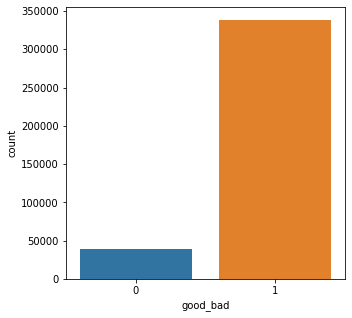

In [82]:
plt.figure(figsize=(5, 5))
sns.countplot(data=loan_data, x='good_bad')
plt.show()

In [83]:
loan_data.drop(columns=[
    'loan_status'
],
inplace=True)

In [84]:
loan_data.head()

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
42535      27050        27050          27050.0   36 months     10.99   
42536       9750         9750           9750.0   36 months     13.98   
42537      12000        12000          12000.0   36 months      6.62   
42538      12000        12000          12000.0   36 months     13.53   
42539      15000        15000          15000.0   36 months      8.90   

       installment grade                            emp_title emp_length  \
42535       885.46     B  Team Leadern Customer Ops & Systems  10+ years   
42536       333.14     C                    Medical Assistant     1 year   
42537       368.45     A         MANAGER INFORMATION DELIVERY  10+ years   
42538       407.40     B                      On road manager  10+ years   
42539       476.30     A        aircraft maintenance engineer    2 years   

      home_ownership  annual_inc verification_status  issue_d pymnt_plan  \
42535            OWN     55000.0            Verified     97.0          n   
42536           RENT     26000.0        Not Verified     97.0          n   
42537       MORTGAGE    105000.0        Not Verified     97.0          n   
42538           RENT     40000.0     Source Verified     97.0          n   
42539       MORTGAGE     63000.0        Not Verified     97.0          n   

                  purpose               title    dti  delinq_2yrs  \
42535  debt_consolidation  Debt Consolidation  22.87          0.0   
42536  debt_consolidation    Debt Consilation  25.12          0.0   
42537  debt_consolidation      UNIVERSAL CARD  14.05          0.0   
42538  debt_consolidation  Debt consolidation  16.94          0.0   
42539  debt_consolidation             Pay off  16.51          0.0   

       earliest_cr_line  inq_last_6mths  open_acc  pub_rec  revol_bal  \
42535             423.0             0.0      14.0      0.0      36638   
42536             180.0             0.0      12.0      0.0       7967   
42537             334.0             1.0      12.0      0.0      13168   
42538             279.0             0.0       7.0      2.0       5572   
42539             286.0             0.0       8.0      0.0      11431   

       revol_util  total_acc initial_list_status  out_prncp  out_prncp_inv  \
42535        61.2       27.0                   w   10018.90       10018.90   
42536        52.8       28.0                   f    3710.96        3710.96   
42537        21.6       22.0                   w    4266.62        4266.62   
42538        68.8       32.0                   w       0.00           0.00   
42539        74.2       29.0                   w    5449.27        5449.27   

       total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  \
42535     21251.04         21251.04         17031.10        4219.94   
42536      7994.83          7994.83          6039.04        1955.79   
42537      8842.80          8842.80          7733.38        1109.42   
42538     13359.77         13359.77         11999.99        1359.78   
42539     11431.20         11431.20          9550.73        1880.47   

       total_rec_late_fee  recoveries  collection_recovery_fee  last_pymnt_d  \
42535                 0.0         0.0                      0.0          72.0   
42536                 0.0         0.0                      0.0          72.0   
42537                 0.0         0.0                      0.0          72.0   
42538                 0.0         0.0                      0.0          76.0   
42539                 0.0         0.0                      0.0          72.0   

       last_pymnt_amnt  last_credit_pull_d  collections_12_mths_ex_med  \
42535           885.46                73.0                         0.0   
42536           333.14                72.0                         0.0   
42537           368.45                72.0                         0.0   
42538           119.17                72.0                         0.0   
42539           476.30                72.0                 

In [85]:
loan_data.dtypes

loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
term                           object
int_rate                      float64
installment                   float64
grade                          object
emp_title                      object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                       float64
pymnt_plan                     object
purpose                        object
title                          object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line              float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                       int64
revol_util                    float64
total_acc                     float64
initial_list_status            object
out_prncp   

In [202]:
cat_data = pd.DataFrame(loan_data, columns=list(loan_data.select_dtypes(include=['object']).columns))
cat_data.head()

term grade                            emp_title emp_length  \
42535   36 months     B  Team Leadern Customer Ops & Systems  10+ years   
42536   36 months     C                    Medical Assistant     1 year   
42537   36 months     A         MANAGER INFORMATION DELIVERY  10+ years   
42538   36 months     B                      On road manager  10+ years   
42539   36 months     A        aircraft maintenance engineer    2 years   

      home_ownership verification_status pymnt_plan             purpose  \
42535            OWN            Verified          n  debt_consolidation   
42536           RENT        Not Verified          n  debt_consolidation   
42537       MORTGAGE        Not Verified          n  debt_consolidation   
42538           RENT     Source Verified          n  debt_consolidation   
42539       MORTGAGE        Not Verified          n  debt_consolidation   

                    title initial_list_status  
42535  Debt Consolidation                   w  
42536    Debt Consilation                   f  
42537      UNIVERSAL CARD                   w  
42538  Debt consolidation                   w  
42539             Pay off                   w

### agregate data home_ownership

In [203]:
cat_data["home_ownership"].value_counts()

MORTGAGE    195522
RENT        148230
OWN          32939
OTHER           42
NONE            41
ANY              1
Name: home_ownership, dtype: int64

In [204]:
target_dict = {'MORTGAGE':'MORTGAGE',
               'RENT':'RENT',
               'OWN':'OWN',
               'OTHER':'OTHER',
               'ANY':'OTHER',
               'NONE':'OTHER'}
cat_data["home_ownership"] = cat_data["home_ownership"].map(target_dict)

In [205]:
cat_data["home_ownership"].value_counts()

MORTGAGE    195522
RENT        148230
OWN          32939
OTHER           84
Name: home_ownership, dtype: int64

In [206]:
cat_data.head()

term grade                            emp_title emp_length  \
42535   36 months     B  Team Leadern Customer Ops & Systems  10+ years   
42536   36 months     C                    Medical Assistant     1 year   
42537   36 months     A         MANAGER INFORMATION DELIVERY  10+ years   
42538   36 months     B                      On road manager  10+ years   
42539   36 months     A        aircraft maintenance engineer    2 years   

      home_ownership verification_status pymnt_plan             purpose  \
42535            OWN            Verified          n  debt_consolidation   
42536           RENT        Not Verified          n  debt_consolidation   
42537       MORTGAGE        Not Verified          n  debt_consolidation   
42538           RENT     Source Verified          n  debt_consolidation   
42539       MORTGAGE        Not Verified          n  debt_consolidation   

                    title initial_list_status  
42535  Debt Consolidation                   w  
42536    Debt Consilation                   f  
42537      UNIVERSAL CARD                   w  
42538  Debt consolidation                   w  
42539             Pay off                   w

In [207]:
cat_data['purpose'].value_counts()

debt_consolidation    228540
credit_card            88596
home_improvement       20292
other                  16365
major_purchase          6357
small_business          3978
medical                 3285
car                     3040
moving                  1998
vacation                1772
house                   1500
wedding                  855
renewable_energy         197
Name: purpose, dtype: int64

In [208]:
cat_data['purpose'].unique()

array(['debt_consolidation', 'other', 'credit_card', 'home_improvement',
       'small_business', 'major_purchase', 'house', 'moving', 'medical',
       'car', 'vacation', 'renewable_energy', 'wedding'], dtype=object)

In [209]:
target_dict = {
    'debt_consolidation':'debt_consolidation', 
    'other':'other', 
    'credit_card':'credit_card',
    'small_business':'small_business', 
    'major_purchase':'major_purchase',
    'medical':'medical',
    'renewable_energy':'renewable_energy',
    'vacation':'vacation',
    
    'house':'personal',
    'wedding':'personal',
    'home_improvement':'personal',
    'car':'personal',
    'moving':'personal'
}
cat_data["purpose"] = cat_data["purpose"].map(target_dict)
cat_data["purpose"].value_counts()

debt_consolidation    228540
credit_card            88596
personal               27685
other                  16365
major_purchase          6357
small_business          3978
medical                 3285
vacation                1772
renewable_energy         197
Name: purpose, dtype: int64

In [210]:
len(cat_data['emp_title'].unique().tolist()), len(cat_data['title'].unique().tolist())

(166136, 37412)

In [211]:
cat_data.drop([
    "emp_title", "title"
], inplace=True, axis=1)
cat_data.head()

term grade emp_length home_ownership verification_status  \
42535   36 months     B  10+ years            OWN            Verified   
42536   36 months     C     1 year           RENT        Not Verified   
42537   36 months     A  10+ years       MORTGAGE        Not Verified   
42538   36 months     B  10+ years           RENT     Source Verified   
42539   36 months     A    2 years       MORTGAGE        Not Verified   

      pymnt_plan             purpose initial_list_status  
42535          n  debt_consolidation                   w  
42536          n  debt_consolidation                   f  
42537          n  debt_consolidation                   w  
42538          n  debt_consolidation                   w  
42539          n  debt_consolidation                   w

In [212]:
cat_data_a = pd.concat([
    cat_data,
    loan_data[
        ["delinq_2yrs", "inq_last_6mths", "acc_now_delinq", "good_bad"]
    ]
], axis=1)
cat_data_a.head()

term grade emp_length home_ownership verification_status  \
42535   36 months     B  10+ years            OWN            Verified   
42536   36 months     C     1 year           RENT        Not Verified   
42537   36 months     A  10+ years       MORTGAGE        Not Verified   
42538   36 months     B  10+ years           RENT     Source Verified   
42539   36 months     A    2 years       MORTGAGE        Not Verified   

      pymnt_plan             purpose initial_list_status  delinq_2yrs  \
42535          n  debt_consolidation                   w          0.0   
42536          n  debt_consolidation                   f          0.0   
42537          n  debt_consolidation                   w          0.0   
42538          n  debt_consolidation                   w          0.0   
42539          n  debt_consolidation                   w          0.0   

       inq_last_6mths  acc_now_delinq  good_bad  
42535             0.0             0.0         1  
42536             0.0             0.0         1  
42537             1.0             0.0         1  
42538             0.0             0.0         1  
42539             0.0             0.0         1

In [213]:
num_data = pd.DataFrame(loan_data, columns=list(loan_data.select_dtypes(include=np.number).columns))

# hapus data yang non kontinu
num_data_c = num_data.copy()
num_data_c.drop([
    "delinq_2yrs", "inq_last_6mths", "acc_now_delinq", "good_bad"
], inplace=True, axis=1)

num_data_c.head()

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
42535      27050        27050          27050.0     10.99       885.46   
42536       9750         9750           9750.0     13.98       333.14   
42537      12000        12000          12000.0      6.62       368.45   
42538      12000        12000          12000.0     13.53       407.40   
42539      15000        15000          15000.0      8.90       476.30   

       annual_inc  issue_d    dti  earliest_cr_line  open_acc  pub_rec  \
42535     55000.0     97.0  22.87             423.0      14.0      0.0   
42536     26000.0     97.0  25.12             180.0      12.0      0.0   
42537    105000.0     97.0  14.05             334.0      12.0      0.0   
42538     40000.0     97.0  16.94             279.0       7.0      2.0   
42539     63000.0     97.0  16.51             286.0       8.0      0.0   

       revol_bal  revol_util  total_acc  out_prncp  out_prncp_inv  \
42535      36638        61.2       27.0   10018.90       10018.90   
42536       7967        52.8       28.0    3710.96        3710.96   
42537      13168        21.6       22.0    4266.62        4266.62   
42538       5572        68.8       32.0       0.00           0.00   
42539      11431        74.2       29.0    5449.27        5449.27   

       total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  \
42535     21251.04         21251.04         17031.10        4219.94   
42536      7994.83          7994.83          6039.04        1955.79   
42537      8842.80          8842.80          7733.38        1109.42   
42538     13359.77         13359.77         11999.99        1359.78   
42539     11431.20         11431.20          9550.73        1880.47   

       total_rec_late_fee  recoveries  collection_recovery_fee  last_pymnt_d  \
42535                 0.0         0.0                      0.0          72.0   
42536                 0.0         0.0                      0.0          72.0   
42537                 0.0         0.0                      0.0          72.0   
42538                 0.0         0.0                      0.0          76.0   
42539                 0.0         0.0                      0.0          72.0   

       last_pymnt_amnt  last_credit_pull_d  collections_12_mths_ex_med  \
42535           885.46                73.0                         0.0   
42536           333.14                72.0                         0.0   
42537           368.45                72.0                         0.0   
42538           119.17                72.0                         0.0   
42539           476.30                72.0                         0.0   

       tot_coll_amt  tot_cur_bal  total_rev_hi_lim  
42535           0.0     114834.0           59900.0  
42536           0.0      14123.0           15100.0  
42537           0.0     267646.0           61100.0  
42538       15386.0      13605.0            8100.0  
42539        1514.0     272492.0           15400.0

In [214]:
num_data_c.describe()

loan_amnt    funded_amnt  funded_amnt_inv       int_rate  \
count  376775.000000  376775.000000    376775.000000  376775.000000   
mean    14890.146307   14890.105965     14883.558596      14.040627   
std      8314.904597    8314.858430      8311.591182       4.384149   
min      1000.000000    1000.000000       950.000000       6.000000   
25%      8500.000000    8500.000000      8500.000000      10.990000   
50%     13200.000000   13200.000000     13200.000000      13.980000   
75%     20000.000000   20000.000000     20000.000000      16.990000   
max     35000.000000   35000.000000     35000.000000      26.060000   

         installment    annual_inc        issue_d            dti  \
count  376775.000000  3.767750e+05  376775.000000  376775.000000   
mean      449.124251  7.527845e+04      95.442028      17.671009   
std       244.074136  5.529303e+04       7.419899       7.850308   
min        23.260000  4.000000e+03      85.000000       0.000000   
25%       272.980000  4.700000e+04      89.000000      11.770000   
50%       396.200000  6.500000e+04      94.000000      17.280000   
75%       586.240000  9.000000e+04     101.000000      23.310000   
max      1409.990000  7.500000e+06     113.000000      39.990000   

       earliest_cr_line       open_acc        pub_rec     revol_bal  \
count     376775.000000  376775.000000  376775.000000  3.767750e+05   
mean         287.995501      11.507741       0.174006  1.671960e+04   
std           84.453373       5.039896       0.537887  2.115223e+04   
min          122.000000       0.000000       0.000000  0.000000e+00   
25%          231.000000       8.000000       0.000000  6.790000e+03   
50%          272.000000      11.000000       0.000000  1.221100e+04   
75%          331.000000      14.000000       0.000000  2.092300e+04   
max          636.000000      84.000000      63.000000  2.568995e+06   

          revol_util      total_acc      out_prncp  out_prncp_inv  \
count  376775.000000  376775.000000  376775.000000  376775.000000   
mean       57.005949      25.595589    5190.443736    5188.701727   
std        22.932820      11.587857    6651.989056    6650.095735   
min         0.000000       2.000000       0.000000       0.000000   
25%        40.600000      17.000000       0.000000       0.000000   
50%        58.100000      24.000000    2344.560000    2343.640000   
75%        74.800000      32.000000    8793.065000    8788.100000   
max       892.300000     156.000000   32160.380000   32160.380000   

         total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  \
count  376775.000000    376775.000000    376775.000000  376775.000000   
mean    11455.233674     11449.643864      8735.461209    2638.763254   
std      8083.613729      8079.275455      6999.016694    2429.592529   
min        35.690000        35.690000         0.000000       0.000000   
25%      5597.370000      5594.720000      3652.575000    1020.150000   
50%      9377.600000      9372.880000      6601.780000    1896.680000   
75%     15141.157130     15132.635000     11774.615000    3388.685000   
max     56087.909920     56047.850000     35000.000000   21840.000000   

       total_rec_late_fee     recoveries  collection_recovery_fee  \
count       376775.000000  376775.000000            376775.000000   
mean             0.546909      80.462307                 8.426923   
std              4.869983     522.392389                73.740570   
min              0.000000       0.000000                 0.000000   
25%              0.000000       0.000000                 0.000000   
50%              0.000000       0.000000                 0.000000   
75%              0.000000       0.000000                 0.000000   
max            358.680000   33520.270000              5694.093600   

        last_pymnt_d  last_pymnt_amnt  last_credit_pull_d  \
count  376775.000000    376775.000000       376775.000000   
mean       76.907876      3228.236584           74.100999   
std         7.465341      5740.53

In [99]:
num_data[['loan_amnt']]

loan_amnt
42535       27050
42536        9750
42537       12000
42538       12000
42539       15000
...           ...
466280      18400
466281      22000
466282      20700
466283       2000
466284      10000

[376775 rows x 1 columns]

## Plot data kategorik vs target

In [100]:
def CNTplot(col):
    fig, axes = plt.subplots(len(col)//3, 3, figsize=(40, 20))
    for d, ax in zip(col, axes.flatten()):
        p = sns.countplot(data=cat_data_a, x=d, hue='good_bad', ax=ax)
        p.set_xlabel(d, fontsize = 15)
        p.set_ylabel("Count", fontsize = 15)
    return plt.show()

def BOXplot(df):
    fig, axes = plt.subplots(df.shape[0]//3, 3, figsize=(40, 20))
    for d, ax in zip(df.columns.tolist(), axes.flatten()):
        p = sns.boxplot(x=df[d], ax=ax)
        p.set_xlabel(d, fontsize = 15)
    return plt.show()

In [215]:
cat_data_a.columns.tolist()

['term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'initial_list_status',
 'delinq_2yrs',
 'inq_last_6mths',
 'acc_now_delinq',
 'good_bad']

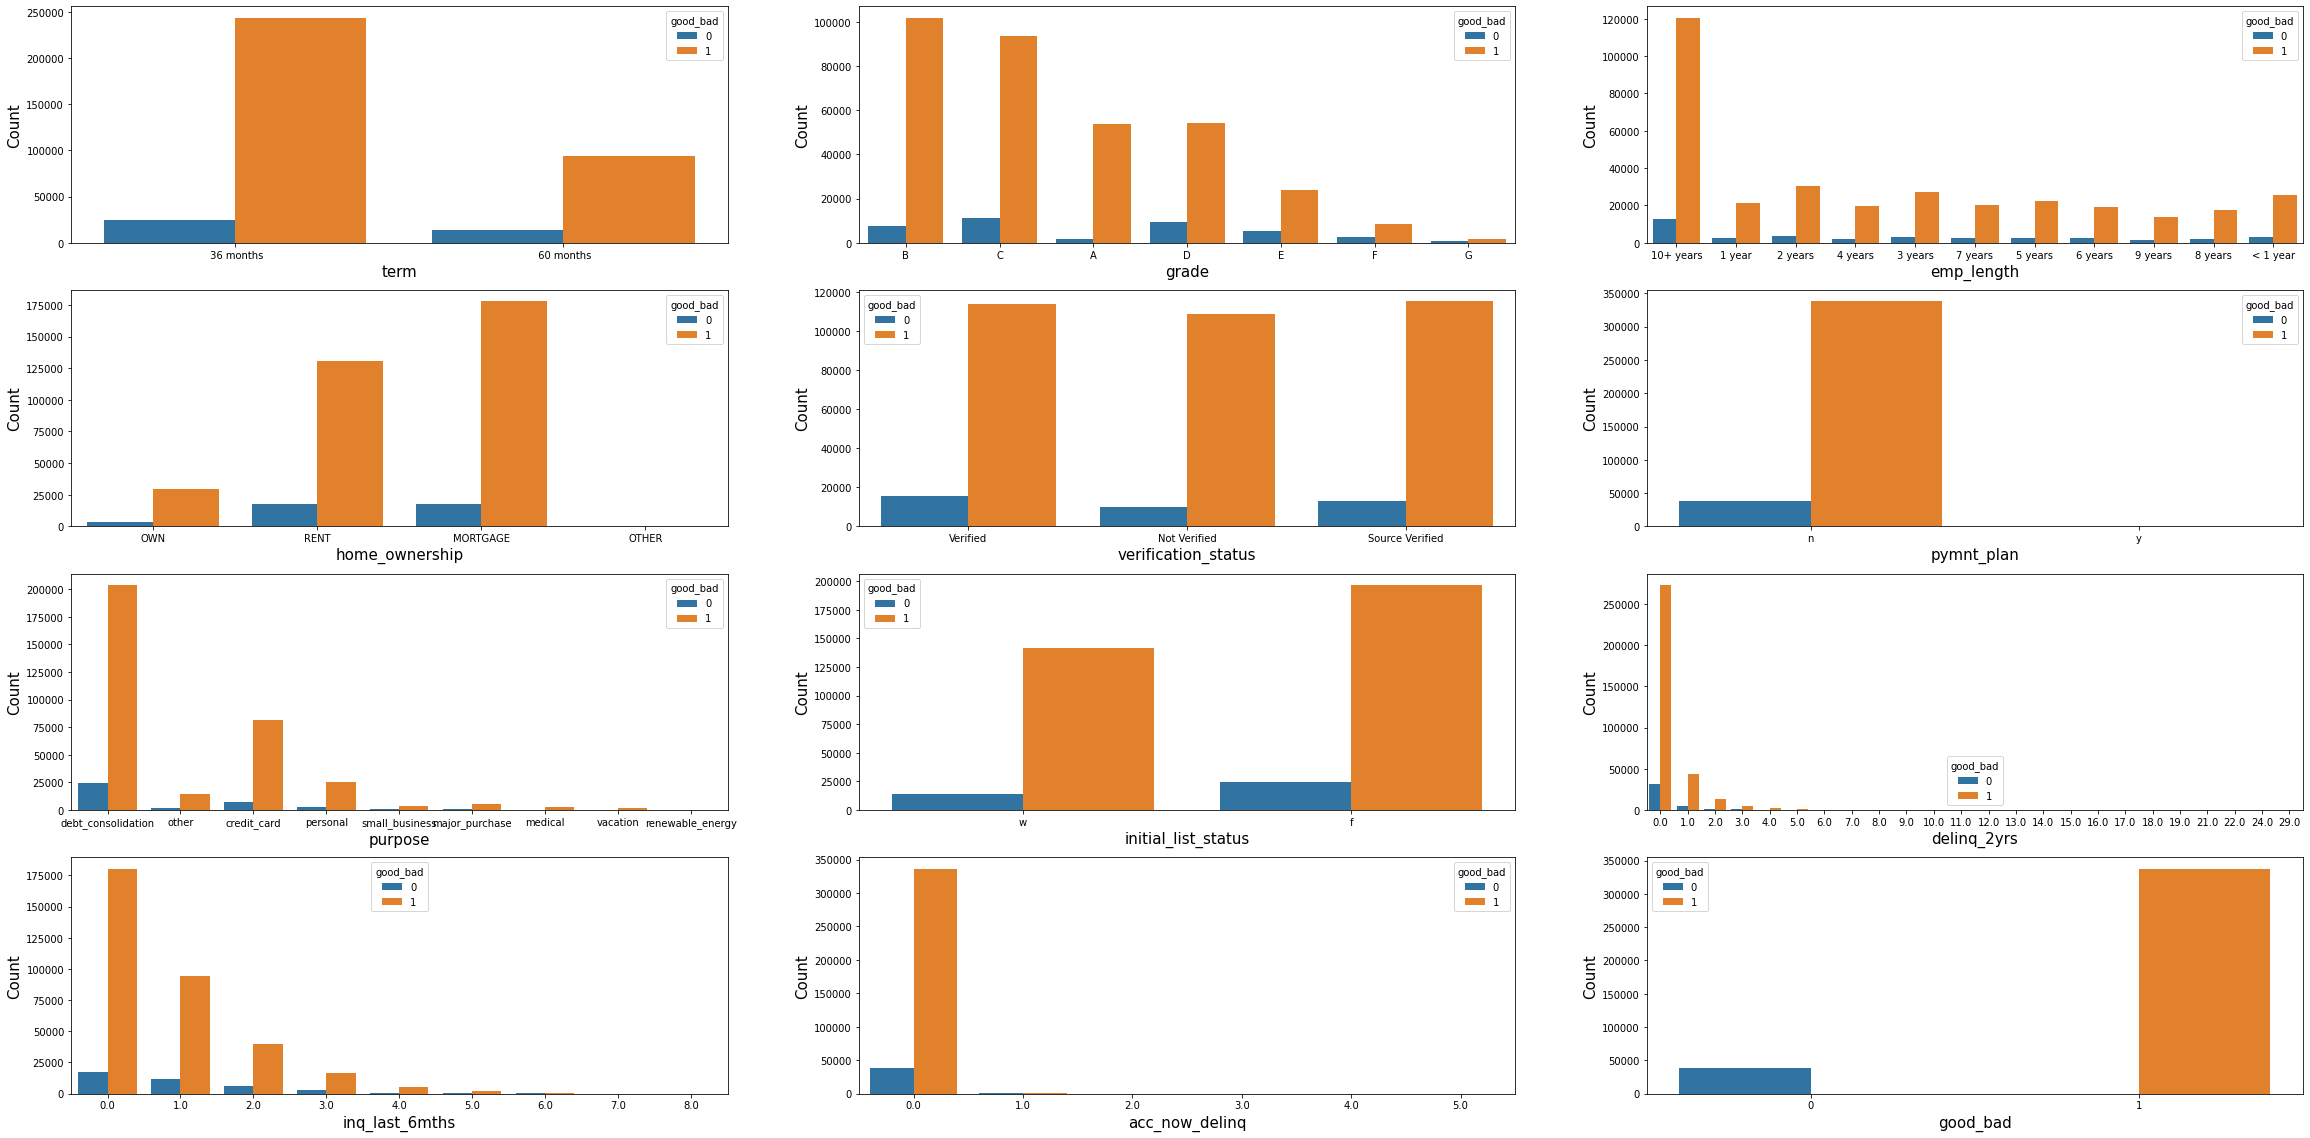

In [216]:
CNTplot(cat_data_a.columns.tolist())

In [217]:
cat_data_a['pymnt_plan'].value_counts()

n    376770
y         5
Name: pymnt_plan, dtype: int64

In [218]:
cat_data_a['acc_now_delinq'].value_counts()

0.0    375121
1.0      1550
2.0        87
3.0        11
4.0         4
5.0         2
Name: acc_now_delinq, dtype: int64

In [219]:
cat_data_a['inq_last_6mths'].value_counts()

0.0    197675
1.0    105650
2.0     45728
3.0     19150
4.0      5760
5.0      2019
6.0       789
7.0         3
8.0         1
Name: inq_last_6mths, dtype: int64

In [220]:
cat_data_a.drop(["pymnt_plan"], inplace=True, axis=1)
cat_data_a.head()

term grade emp_length home_ownership verification_status  \
42535   36 months     B  10+ years            OWN            Verified   
42536   36 months     C     1 year           RENT        Not Verified   
42537   36 months     A  10+ years       MORTGAGE        Not Verified   
42538   36 months     B  10+ years           RENT     Source Verified   
42539   36 months     A    2 years       MORTGAGE        Not Verified   

                  purpose initial_list_status  delinq_2yrs  inq_last_6mths  \
42535  debt_consolidation                   w          0.0             0.0   
42536  debt_consolidation                   f          0.0             0.0   
42537  debt_consolidation                   w          0.0             1.0   
42538  debt_consolidation                   w          0.0             0.0   
42539  debt_consolidation                   w          0.0             0.0   

       acc_now_delinq  good_bad  
42535             0.0         1  
42536             0.0         1  
42537             0.0         1  
42538             0.0         1  
42539             0.0         1

## Cek Outlier

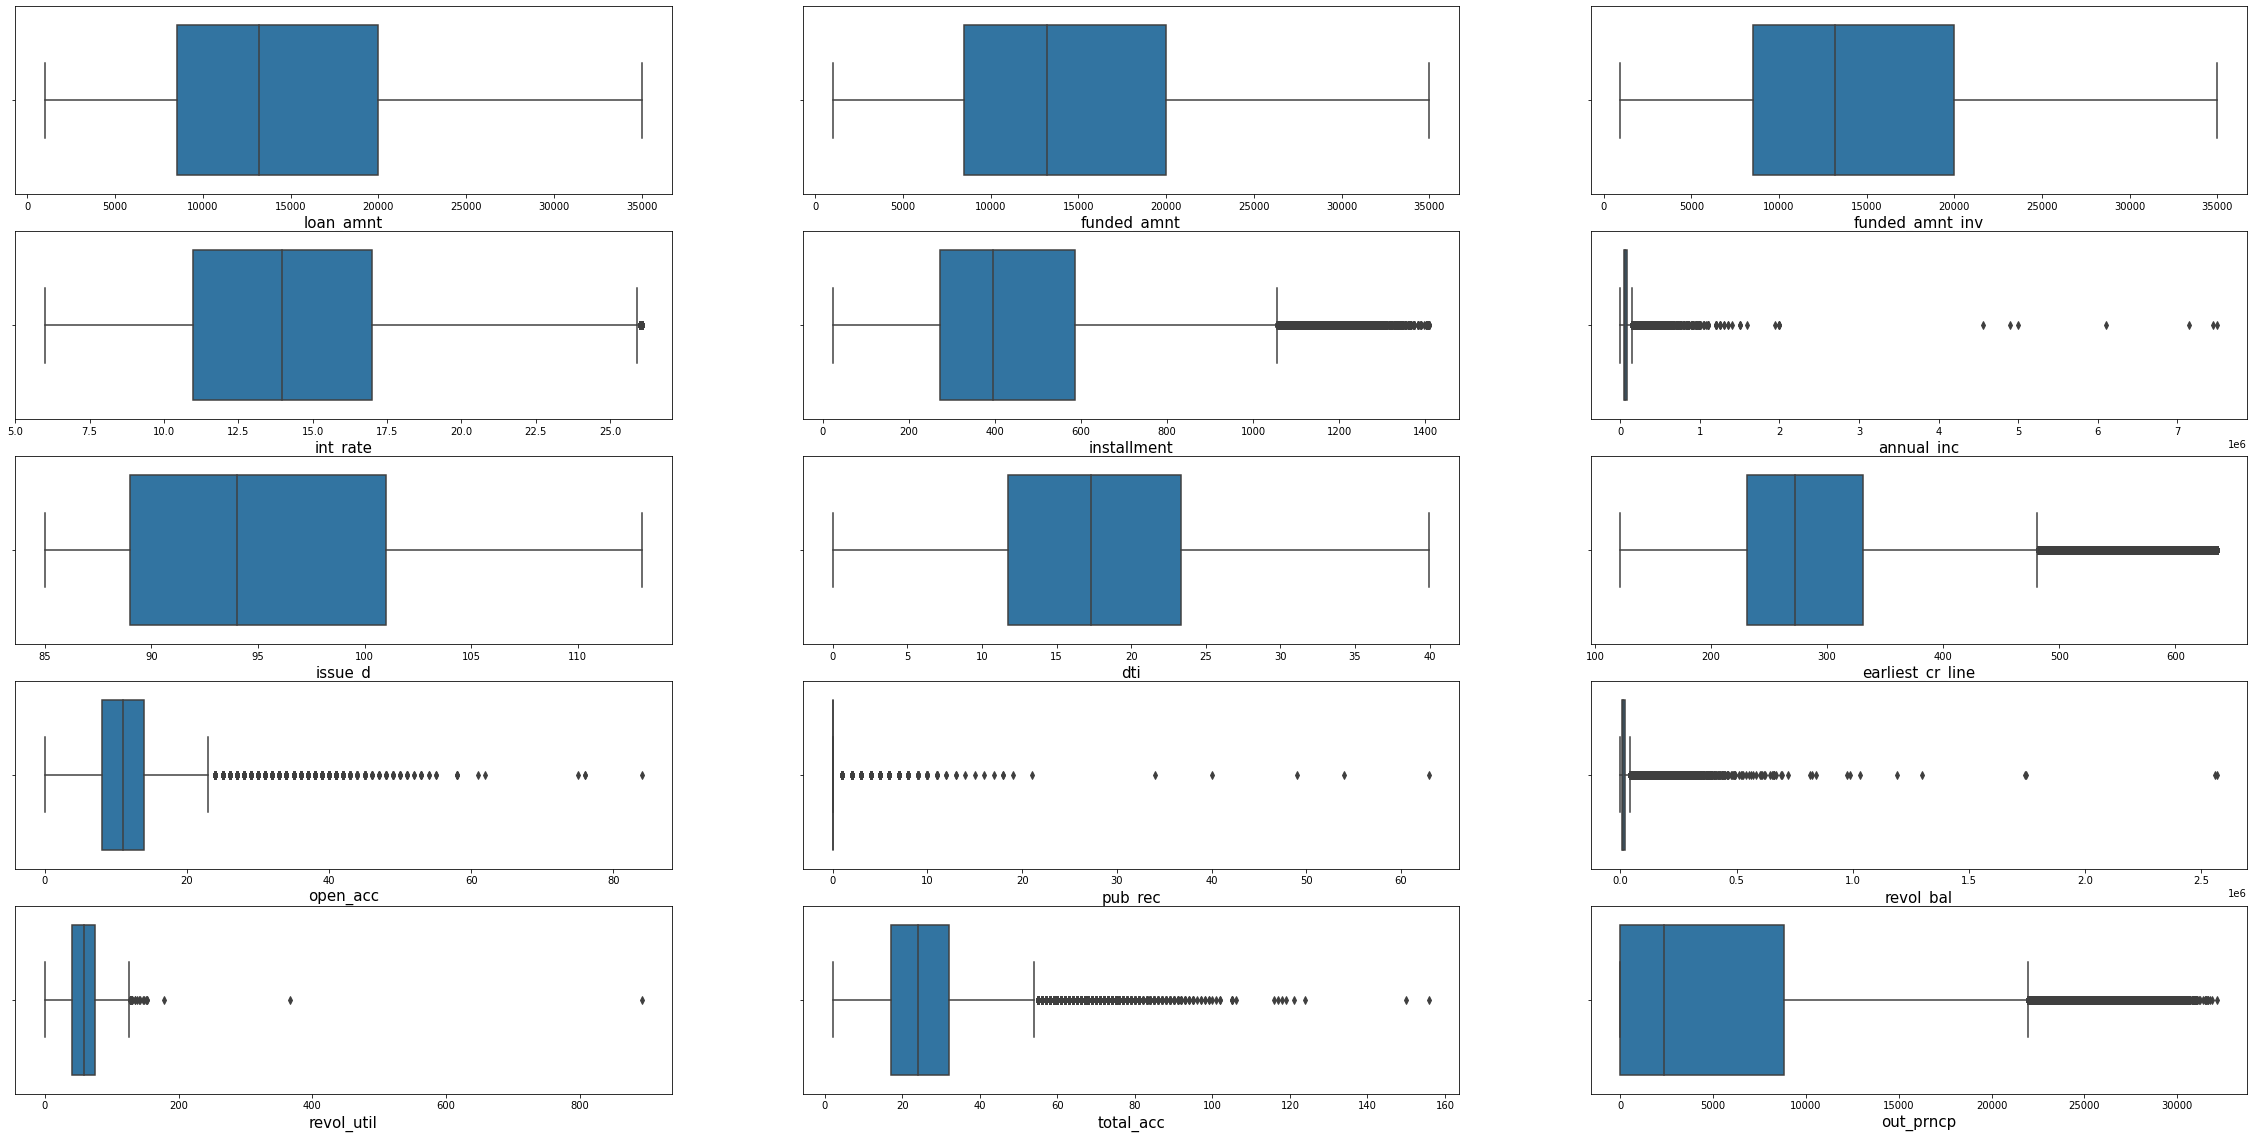

In [107]:
df = pd.DataFrame(num_data_c.loc[:, num_data_c.columns[:15].tolist()])

fig, axes = plt.subplots(15//3, 3, figsize=(40, 20))
for d, ax in zip(df.columns.tolist(), axes.flatten()):
    p = sns.boxplot(x=df[d], ax=ax)
    p.set_xlabel(d, fontsize = 15)
plt.show()

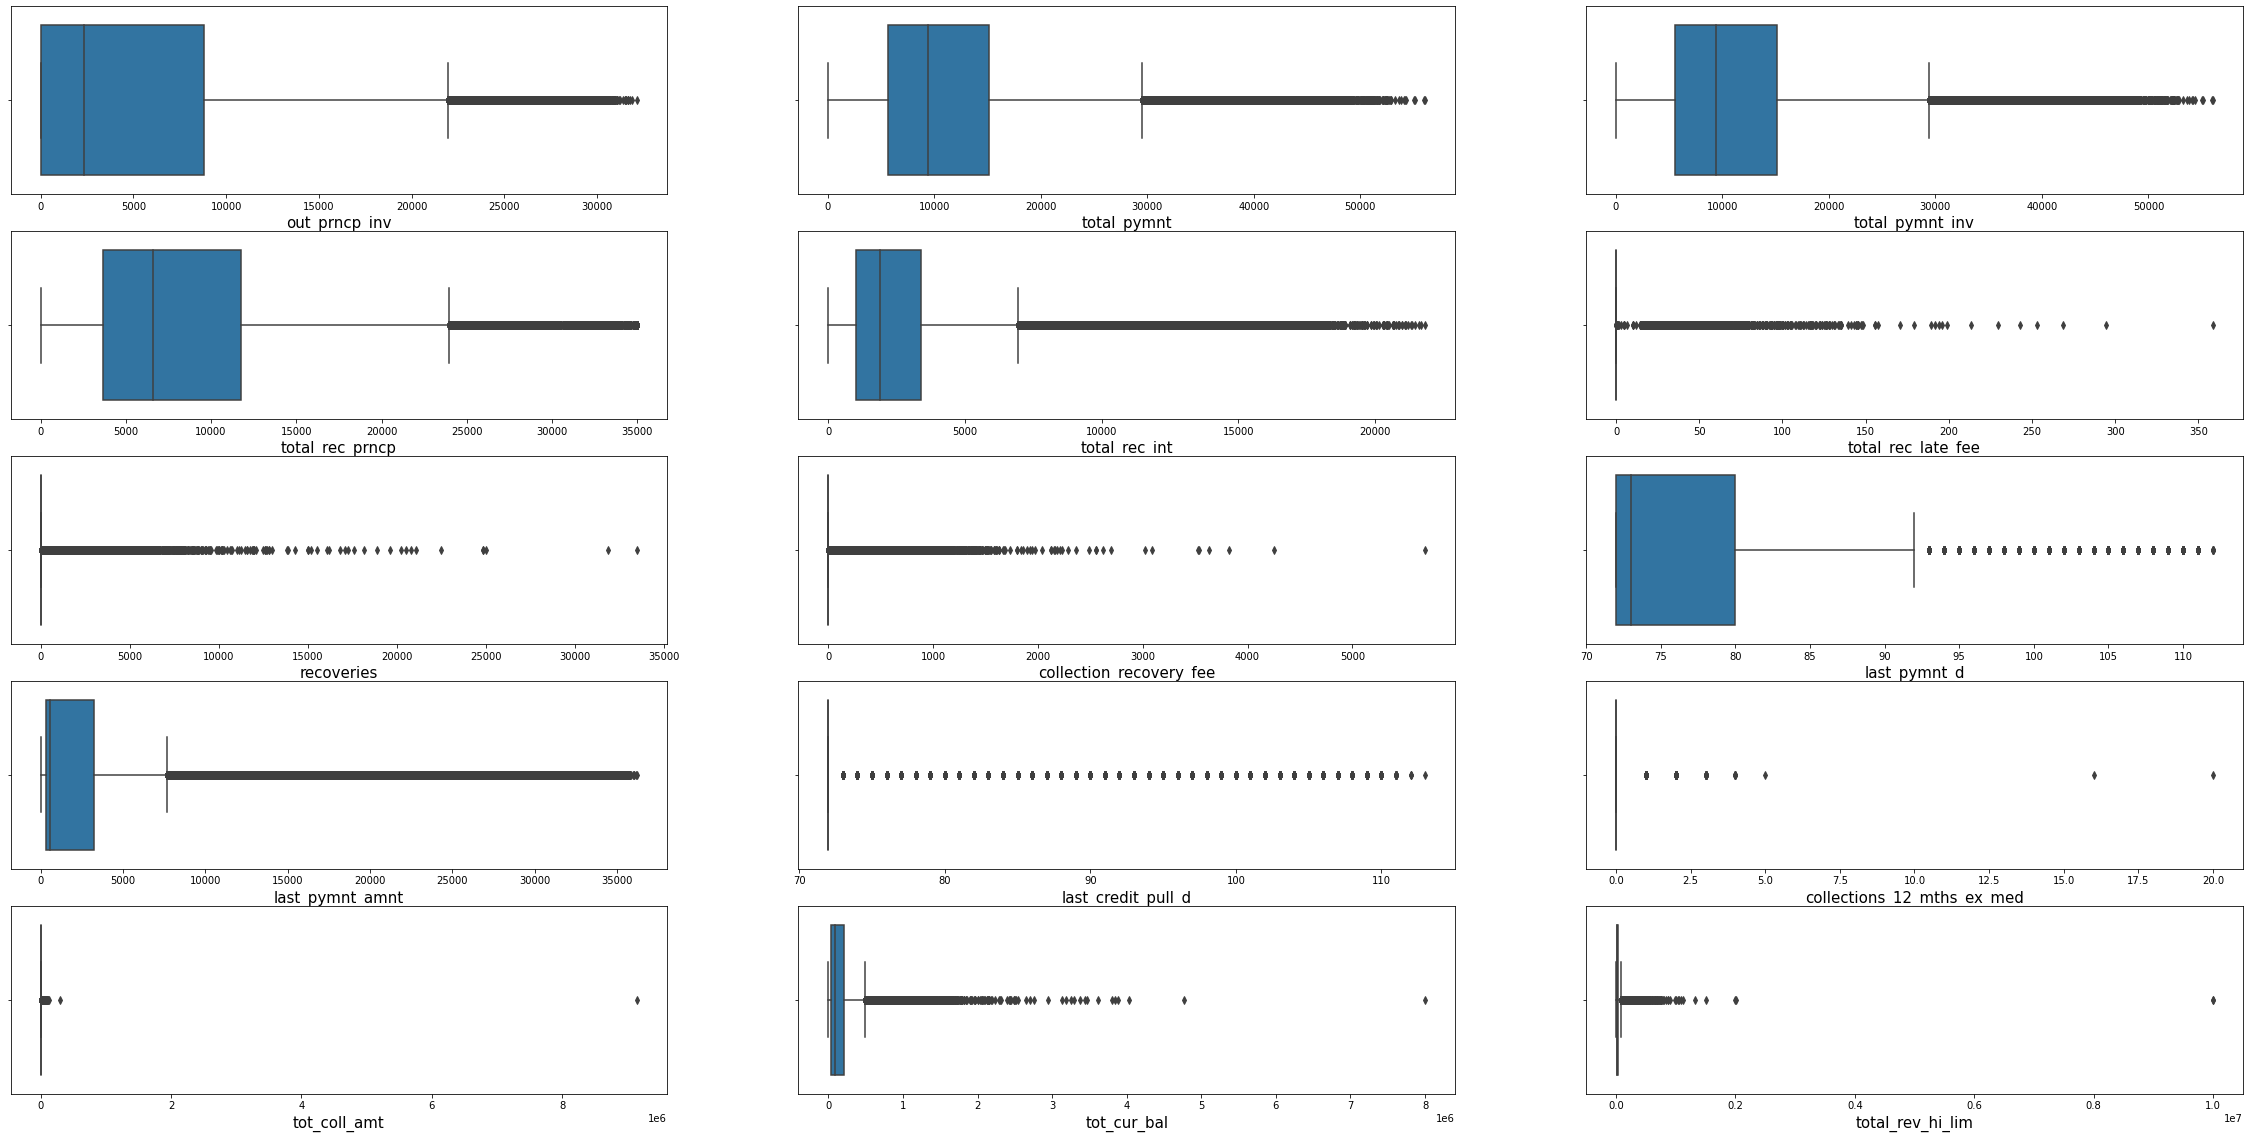

In [108]:
df = pd.DataFrame(num_data_c.loc[:, num_data_c.columns[15:].tolist()])

fig, axes = plt.subplots(15//3, 3, figsize=(40, 20))
for d, ax in zip(df.columns.tolist(), axes.flatten()):
    p = sns.boxplot(x=df[d], ax=ax)
    p.set_xlabel(d, fontsize = 15)
plt.show()

In [109]:
num_data_c.columns.tolist()

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'issue_d',
 'dti',
 'earliest_cr_line',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim']

In [110]:
outlayer = [
 'annual_inc',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'collections_12_mths_ex_med',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim'
]

In [111]:
num_data_c[outlayer]

annual_inc  open_acc  pub_rec  revol_bal  revol_util  total_acc  \
42535      55000.0      14.0      0.0      36638        61.2       27.0   
42536      26000.0      12.0      0.0       7967        52.8       28.0   
42537     105000.0      12.0      0.0      13168        21.6       22.0   
42538      40000.0       7.0      2.0       5572        68.8       32.0   
42539      63000.0       8.0      0.0      11431        74.2       29.0   
...            ...       ...      ...        ...         ...        ...   
466280    110000.0      18.0      0.0      23208        77.6       36.0   
466281     78000.0      18.0      1.0      18238        46.3       30.0   
466282     46000.0      18.0      0.0       6688        51.1       43.0   
466283     83000.0      21.0      0.0      11404        21.5       27.0   
466284     46000.0       6.0      0.0      11325        70.8       22.0   

        total_rec_late_fee  recoveries  collection_recovery_fee  last_pymnt_d  \
42535                  0.0         0.0                      0.0          72.0   
42536                  0.0         0.0                      0.0          72.0   
42537                  0.0         0.0                      0.0          72.0   
42538                  0.0         0.0                      0.0          76.0   
42539                  0.0         0.0                      0.0          72.0   
...                    ...         ...                      ...           ...   
466280                 0.0         0.0                      0.0          72.0   
466281                 0.0         0.0                      0.0          85.0   
466282                 0.0         0.0                      0.0          72.0   
466283                 0.0         0.0                      0.0          85.0   
466284                 0.0         0.0                      0.0          72.0   

        collections_12_mths_ex_med  tot_coll_amt  tot_cur_bal  \
42535                          0.0           0.0     114834.0   
42536                          0.0           0.0      14123.0   
42537                          0.0           0.0     267646.0   
42538                          0.0       15386.0      13605.0   
42539                          0.0        1514.0     272492.0   
...                            ...           ...          ...   
466280                         0.0           0.0     294998.0   
466281                         0.0           0.0     221830.0   
466282                         0.0           0.0      73598.0   
466283                         0.0           0.0     591610.0   
466284                         0.0           0.0      57477.0   

        total_rev_hi_lim  
42535            59900.0  
42536            15100.0  
42537            61100.0  
42538             8100.0  
42539            15400.0  
...                  ...  
466280           29900.0  
466281           39400.0  
466282           13100.0  
466283           53100.0  
466284           16000.0  

[376775 rows x 14 columns]

### Handling Outliers

In [112]:
## Inter-Quartile Range Transform
def IQR_df(col):
    Q1 = (num_data_c[col]).quantile(0.25)
    Q3 = (num_data_c[col]).quantile(0.75)
    IQR = Q3 - Q1
    
    max_num = Q3 + (1.5*IQR)
    print(f"Nilai Maximum dari masing-masing Variable adalah: \n{max_num}")
    
    min_num = Q1 - (1.5*IQR)
    print(f"Nilai Minimum dari masing-masing Variable adalah: \n{min_num}")
    
    more_than = (num_data_c > max_num)
    lower_than = (num_data_c < min_num)
    
    return num_data_c[~(lower_than | more_than).any(axis=1)]

def IQR_df2(col):
    for x in col:
        q75,q25 = np.percentile(num_data_c.loc[:,x],[75,25])
        intr_qr = q75-q25

        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)

        num_data_c.loc[num_data_c[x] < min,x] = np.nan
        num_data_c.loc[num_data_c[x] > max,x] = np.nan
        
    num_data_c.dropna(axis = 0, inplace=True)

In [113]:
num_data_iqr = num_data_c.copy()
num_data_iqr = IQR_df(outlayer)

Nilai Maximum dari masing-masing Variable adalah: 
annual_inc                    154500.0
open_acc                          23.0
pub_rec                            0.0
revol_bal                      42122.5
revol_util                       126.1
total_acc                         54.5
total_rec_late_fee                 0.0
recoveries                         0.0
collection_recovery_fee            0.0
last_pymnt_d                      92.0
collections_12_mths_ex_med         0.0
tot_coll_amt                       0.0
tot_cur_bal                   485821.0
total_rev_hi_lim               74700.0
dtype: float64
Nilai Minimum dari masing-masing Variable adalah: 
annual_inc                    -17500.0
open_acc                          -1.0
pub_rec                            0.0
revol_bal                     -14409.5
revol_util                       -10.7
total_acc                         -5.5
total_rec_late_fee                 0.0
recoveries                         0.0
collection_recovery_fee  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  


In [114]:
num_data_iqr

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
42535       27050        27050          27050.0     10.99       885.46   
42536        9750         9750           9750.0     13.98       333.14   
42537       12000        12000          12000.0      6.62       368.45   
42540       12000        12000          12000.0     11.99       398.52   
42542        7550         7550           7550.0     16.24       266.34   
...           ...          ...              ...       ...          ...   
466278      10000        10000          10000.0     18.25       362.78   
466279      15000        15000          15000.0     13.53       509.25   
466280      18400        18400          18400.0     14.47       432.64   
466282      20700        20700          20700.0     16.99       514.34   
466284      10000        10000           9975.0     19.20       367.58   

        annual_inc  issue_d    dti  earliest_cr_line  open_acc  pub_rec  \
42535      55000.0     97.0  22.87             423.0      14.0      0.0   
42536      26000.0     97.0  25.12             180.0      12.0      0.0   
42537     105000.0     97.0  14.05             334.0      12.0      0.0   
42540     130000.0     97.0  13.03             290.0       9.0      0.0   
42542      28000.0     97.0   8.40             135.0       4.0      0.0   
...            ...      ...    ...               ...       ...      ...   
466278     42000.0     96.0  11.57             235.0       9.0      0.0   
466279     66000.0     96.0  16.22             269.0       8.0      0.0   
466280    110000.0     96.0  19.85             225.0      18.0      0.0   
466282     46000.0     96.0  25.65             241.0      18.0      0.0   
466284     46000.0     96.0  22.78             263.0       6.0      0.0   

        revol_bal  revol_util  total_acc  out_prncp  out_prncp_inv  \
42535       36638        61.2       27.0   10018.90       10018.90   
42536        7967        52.8       28.0    3710.96        3710.96   
42537       13168        21.6       22.0    4266.62        4266.62   
42540       10805        67.0       19.0    4485.45        4485.45   
42542        5759        72.0        5.0    2931.48        2931.48   
...           ...         ...        ...        ...            ...   
466278       3196        28.8       24.0       0.00           0.00   
466279      16901        96.0       20.0    5685.63        5685.63   
466280      23208        77.6       36.0   12574.00       12574.00   
466282       6688        51.1       43.0   14428.31       14428.31   
466284      11325        70.8       22.0    3984.38        3974.41   

        total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  \
42535    21251.0400         21251.04         17031.10        4219.94   
42536     7994.8300          7994.83          6039.04        1955.79   
42537     8842.8000          8842.80          7733.38        1109.42   
42540     9564.4000          9564.40          7514.55        2049.85   
42542     6407.3800          6407.38          4618.52        1788.86   
...             ...              ...              ...            ...   
466278   12394.1652         12394.17         10000.00        2394.17   
466279   12222.0000         12222.00          9314.37        2907.63   
466280   10383.3600         10383.36          5826.00        4557.36   
466282   12343.9800         12343.98          6271.69        6072.29   
466284    8821.6200          8799.57          6015.62        2806.00   

        total_rec_late_fee  recoveries  collection_recovery_fee  last_pymnt_d  \
42535                  0.0         0.0                      0.0          72.0   
42536                  0.0         0.0                      0.0          72.0   
42537                  0.0         0.0                      0.0          72.0   
42540                  0.0         0.0                      0.0          72.0   
42542                  0.0         0.0                      0.0          72.0   
...                    ...

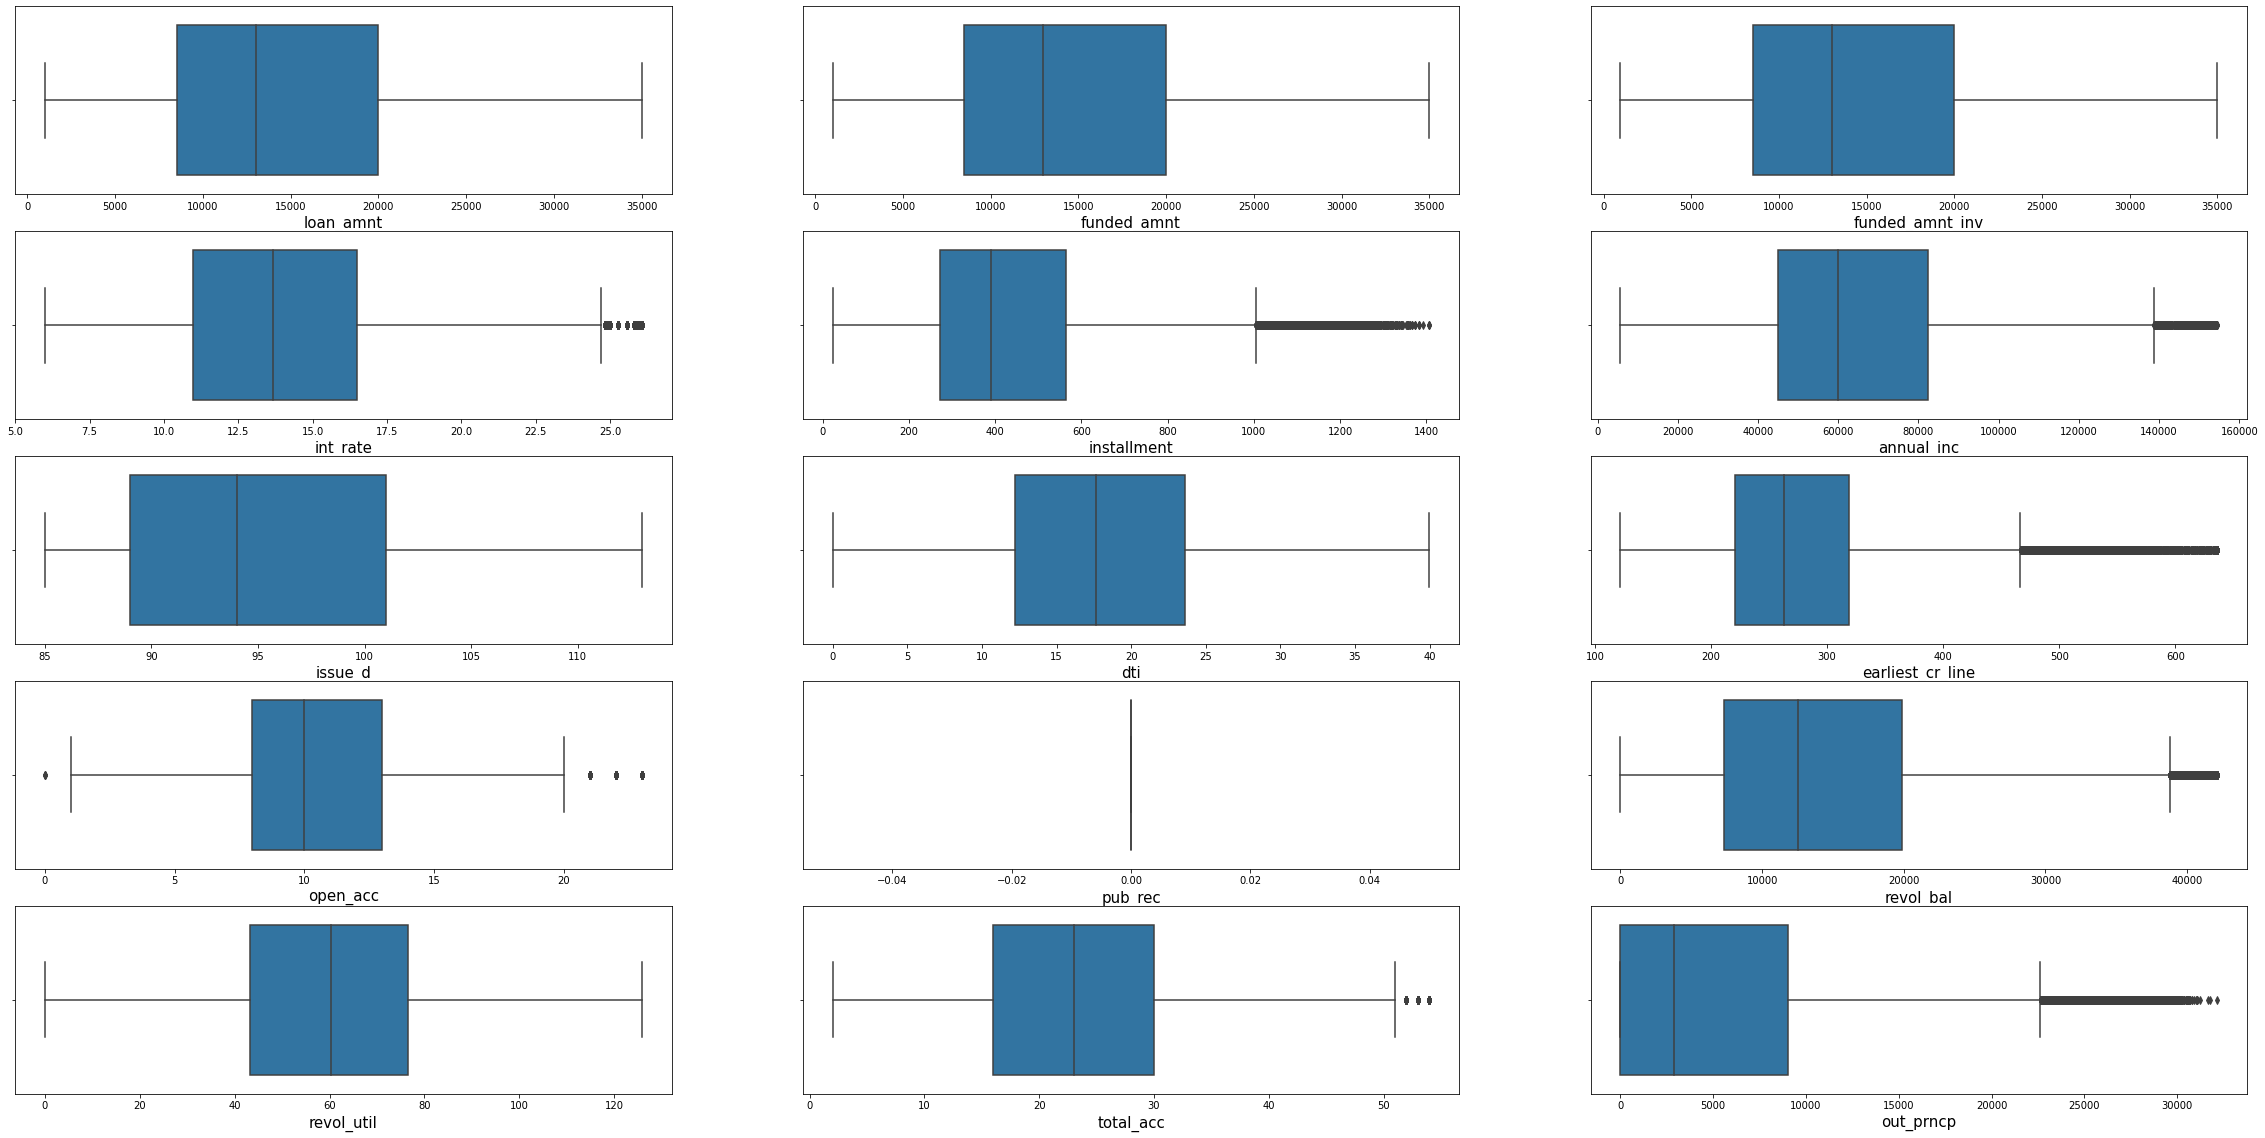

In [115]:
df = pd.DataFrame(num_data_iqr.loc[:, num_data_iqr.columns[:15].tolist()])
fig, axes = plt.subplots(15//3, 3, figsize=(40, 20))
for d, ax in zip(df.columns.tolist(), axes.flatten()):
    p = sns.boxplot(x=df[d], ax=ax)
    p.set_xlabel(d, fontsize = 15)
plt.show()

In [116]:
print(num_data_iqr['pub_rec'].value_counts())

0.0    213580
Name: pub_rec, dtype: int64


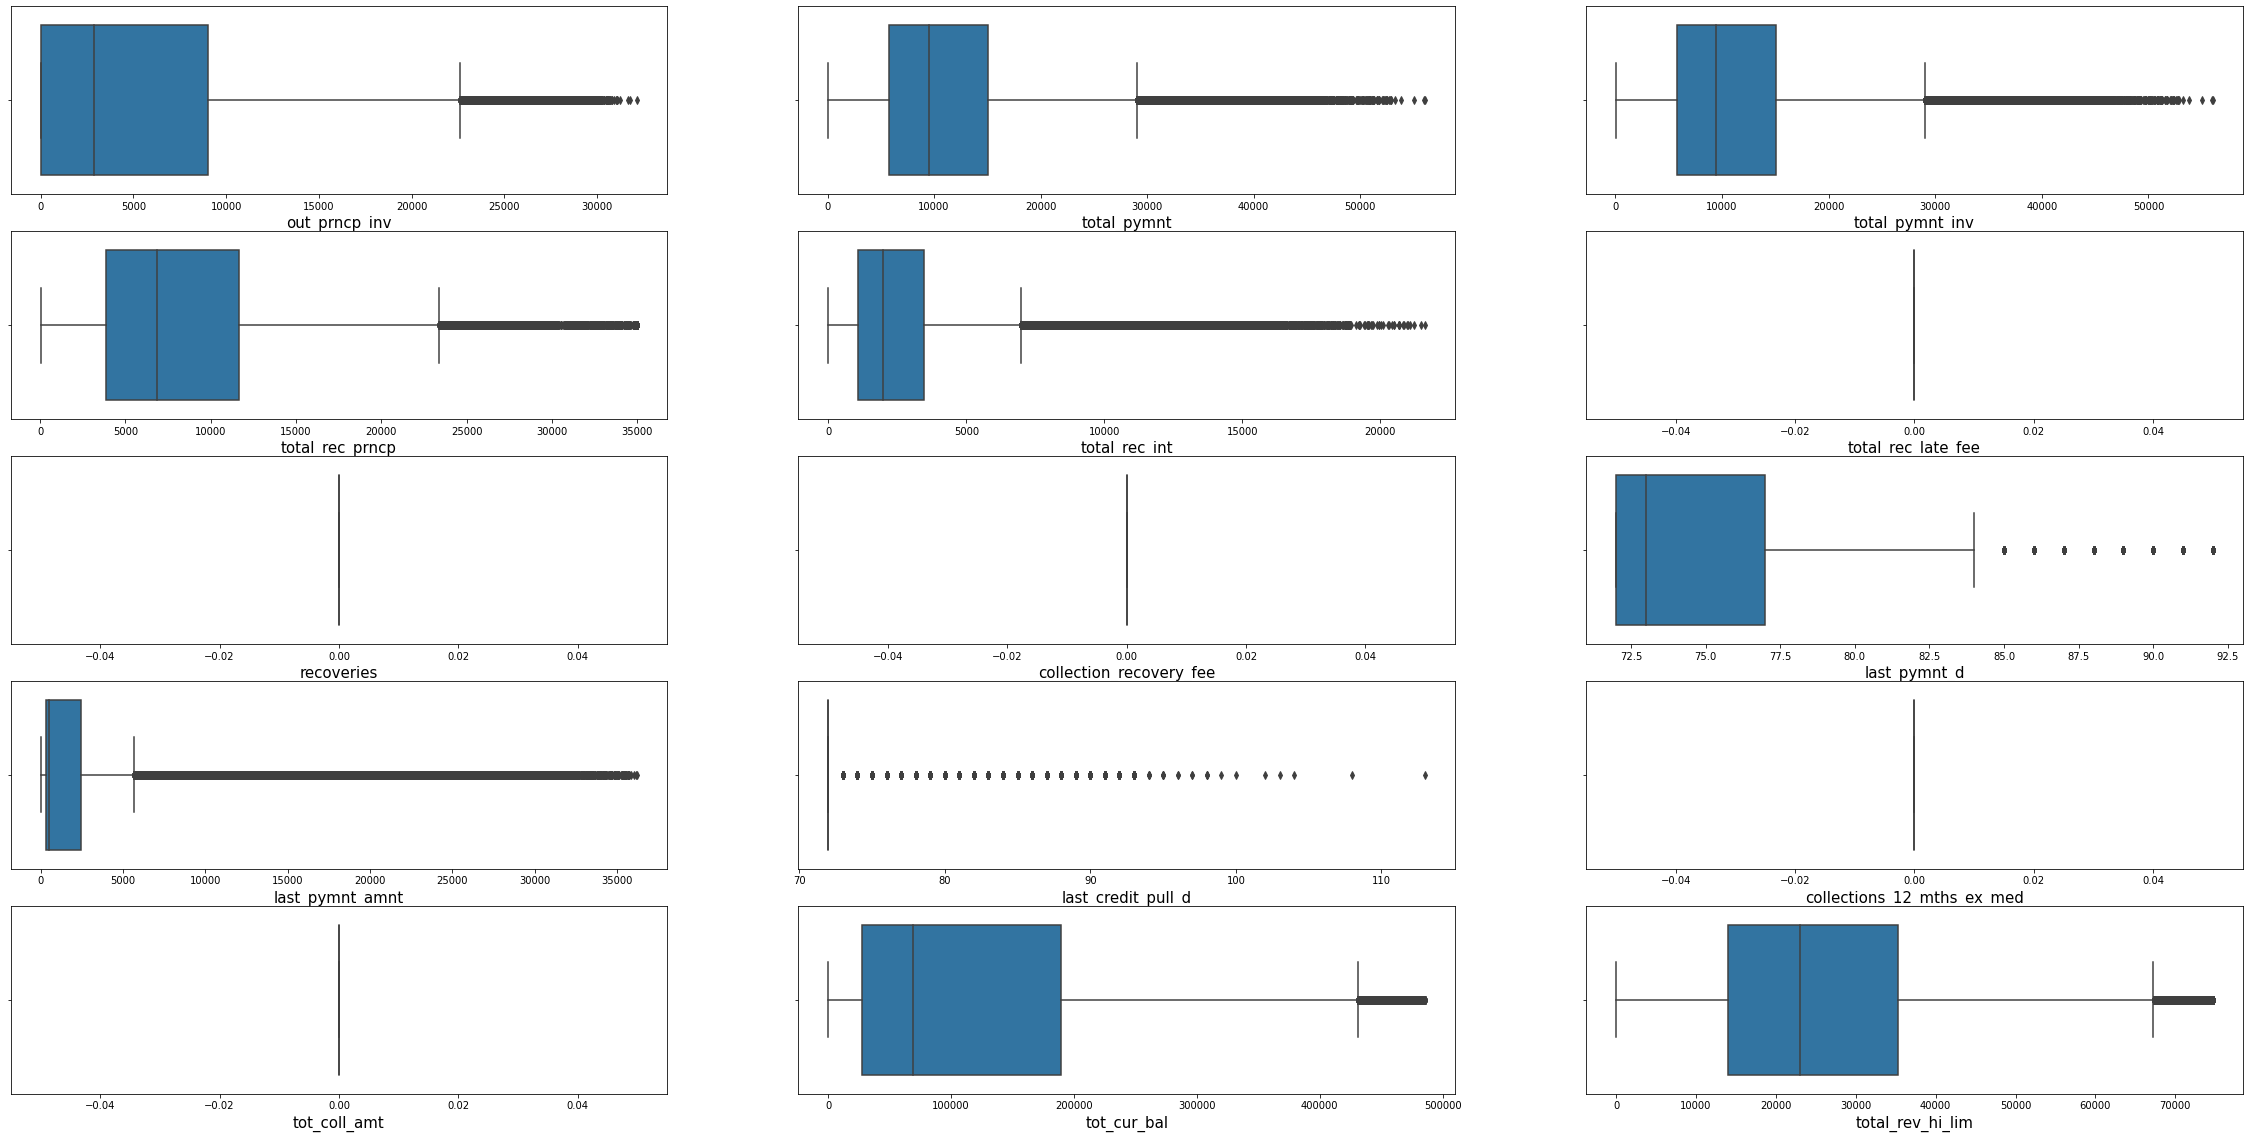

In [117]:
df = pd.DataFrame(num_data_iqr.loc[:, num_data_iqr.columns[15:].tolist()])
fig, axes = plt.subplots(15//3, 3, figsize=(40, 20))
for d, ax in zip(df.columns.tolist(), axes.flatten()):
    p = sns.boxplot(x=df[d], ax=ax)
    p.set_xlabel(d, fontsize = 15)
plt.show()

In [118]:
print(num_data_iqr['recoveries'].value_counts())
print(num_data_iqr['collection_recovery_fee'].value_counts())
print(num_data_iqr['collections_12_mths_ex_med'].value_counts())
print(num_data_iqr['tot_coll_amt'].value_counts())
print(num_data_iqr['total_rec_late_fee'].value_counts())

0.0    213580
Name: recoveries, dtype: int64
0.0    213580
Name: collection_recovery_fee, dtype: int64
0.0    213580
Name: collections_12_mths_ex_med, dtype: int64
0.0    213580
Name: tot_coll_amt, dtype: int64
0.0    213580
Name: total_rec_late_fee, dtype: int64


In [119]:
num_data_iqr.drop(columns=[
    'pub_rec', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'tot_coll_amt', 'total_rec_late_fee'
], inplace=True)

num_data_iqr

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
42535       27050        27050          27050.0     10.99       885.46   
42536        9750         9750           9750.0     13.98       333.14   
42537       12000        12000          12000.0      6.62       368.45   
42540       12000        12000          12000.0     11.99       398.52   
42542        7550         7550           7550.0     16.24       266.34   
...           ...          ...              ...       ...          ...   
466278      10000        10000          10000.0     18.25       362.78   
466279      15000        15000          15000.0     13.53       509.25   
466280      18400        18400          18400.0     14.47       432.64   
466282      20700        20700          20700.0     16.99       514.34   
466284      10000        10000           9975.0     19.20       367.58   

        annual_inc  issue_d    dti  earliest_cr_line  open_acc  revol_bal  \
42535      55000.0     97.0  22.87             423.0      14.0      36638   
42536      26000.0     97.0  25.12             180.0      12.0       7967   
42537     105000.0     97.0  14.05             334.0      12.0      13168   
42540     130000.0     97.0  13.03             290.0       9.0      10805   
42542      28000.0     97.0   8.40             135.0       4.0       5759   
...            ...      ...    ...               ...       ...        ...   
466278     42000.0     96.0  11.57             235.0       9.0       3196   
466279     66000.0     96.0  16.22             269.0       8.0      16901   
466280    110000.0     96.0  19.85             225.0      18.0      23208   
466282     46000.0     96.0  25.65             241.0      18.0       6688   
466284     46000.0     96.0  22.78             263.0       6.0      11325   

        revol_util  total_acc  out_prncp  out_prncp_inv  total_pymnt  \
42535         61.2       27.0   10018.90       10018.90   21251.0400   
42536         52.8       28.0    3710.96        3710.96    7994.8300   
42537         21.6       22.0    4266.62        4266.62    8842.8000   
42540         67.0       19.0    4485.45        4485.45    9564.4000   
42542         72.0        5.0    2931.48        2931.48    6407.3800   
...            ...        ...        ...            ...          ...   
466278        28.8       24.0       0.00           0.00   12394.1652   
466279        96.0       20.0    5685.63        5685.63   12222.0000   
466280        77.6       36.0   12574.00       12574.00   10383.3600   
466282        51.1       43.0   14428.31       14428.31   12343.9800   
466284        70.8       22.0    3984.38        3974.41    8821.6200   

        total_pymnt_inv  total_rec_prncp  total_rec_int  last_pymnt_d  \
42535          21251.04         17031.10        4219.94          72.0   
42536           7994.83          6039.04        1955.79          72.0   
42537           8842.80          7733.38        1109.42          72.0   
42540           9564.40          7514.55        2049.85          72.0   
42542           6407.38          4618.52        1788.86          72.0   
...                 ...              ...            ...           ...   
466278         12394.17         10000.00        2394.17          76.0   
466279         12222.00          9314.37        2907.63          72.0   
466280         10383.36          5826.00        4557.36          72.0   
466282         12343.98          6271.69        6072.29          72.0   
466284          8799.57          6015.62        2806.00          72.0   

        last_pymnt_amnt  last_credit_pull_d  tot_cur_bal  total_rev_hi_lim  
42535            885.46                73.0     114834.0           59900.0  
42536            333.14                72.0      14123.0           15100.0  
42537            368.45                72.0     267646.0           61100.0  
42540            398.52                72.0     327264.0           16200.0  
42542            266.34                72.0       5759.0           

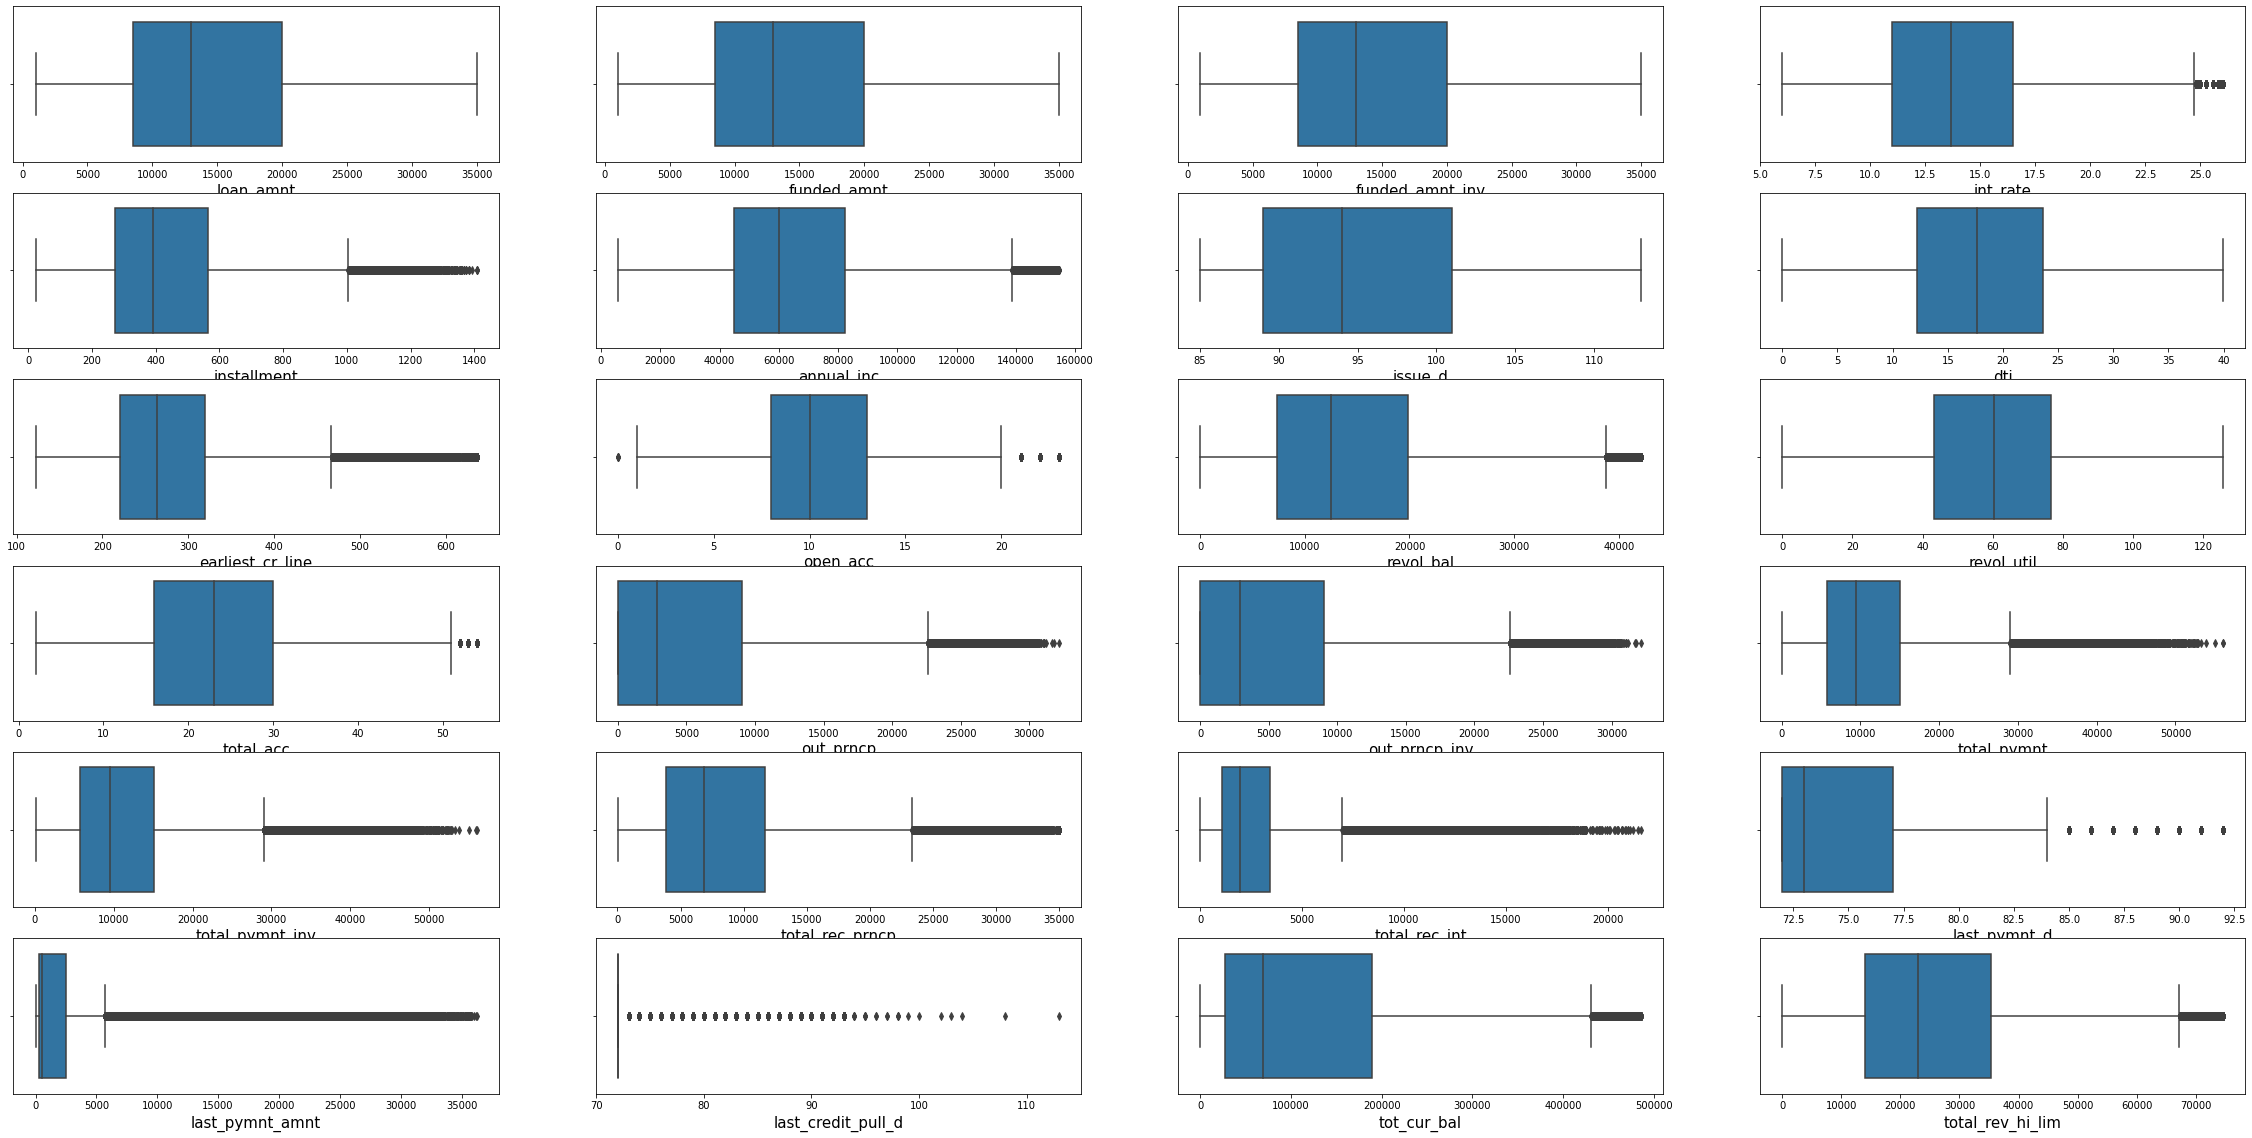

In [120]:
df = num_data_iqr

fig, axes = plt.subplots(24//4, 4, figsize=(40, 20))
for d, ax in zip(df.columns.tolist(), axes.flatten()):
    p = sns.boxplot(x=df[d], ax=ax)
    p.set_xlabel(d, fontsize = 15)
plt.show()

In [121]:
outlayer = [
  'open_acc',
  'total_acc',
  'int_rate',
  'last_credit_pull_d'

#   'int_rate',
#   'installment',
#   'earliest_cr_line',
#   'open_acc',
#  'revol_bal',
#  'total_acc',
#  'out_prncp',
#  'out_prncp_inv', 	
#  'total_pymnt',
#  'total_pymnt_inv',
#  'total_rec_prncp',
#  'total_rec_int',
#  'last_pymnt_d',
#  'last_pymnt_amnt',
#  'last_credit_pull_d',
#  'tot_cur_bal',
#  'total_rev_hi_lim'
]

In [122]:
num_data_iqr = IQR_df(outlayer)

Nilai Maximum dari masing-masing Variable adalah: 
open_acc              23.00
total_acc             54.50
int_rate              25.99
last_credit_pull_d    72.00
dtype: float64
Nilai Minimum dari masing-masing Variable adalah: 
open_acc              -1.00
total_acc             -5.50
int_rate               1.99
last_credit_pull_d    72.00
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  


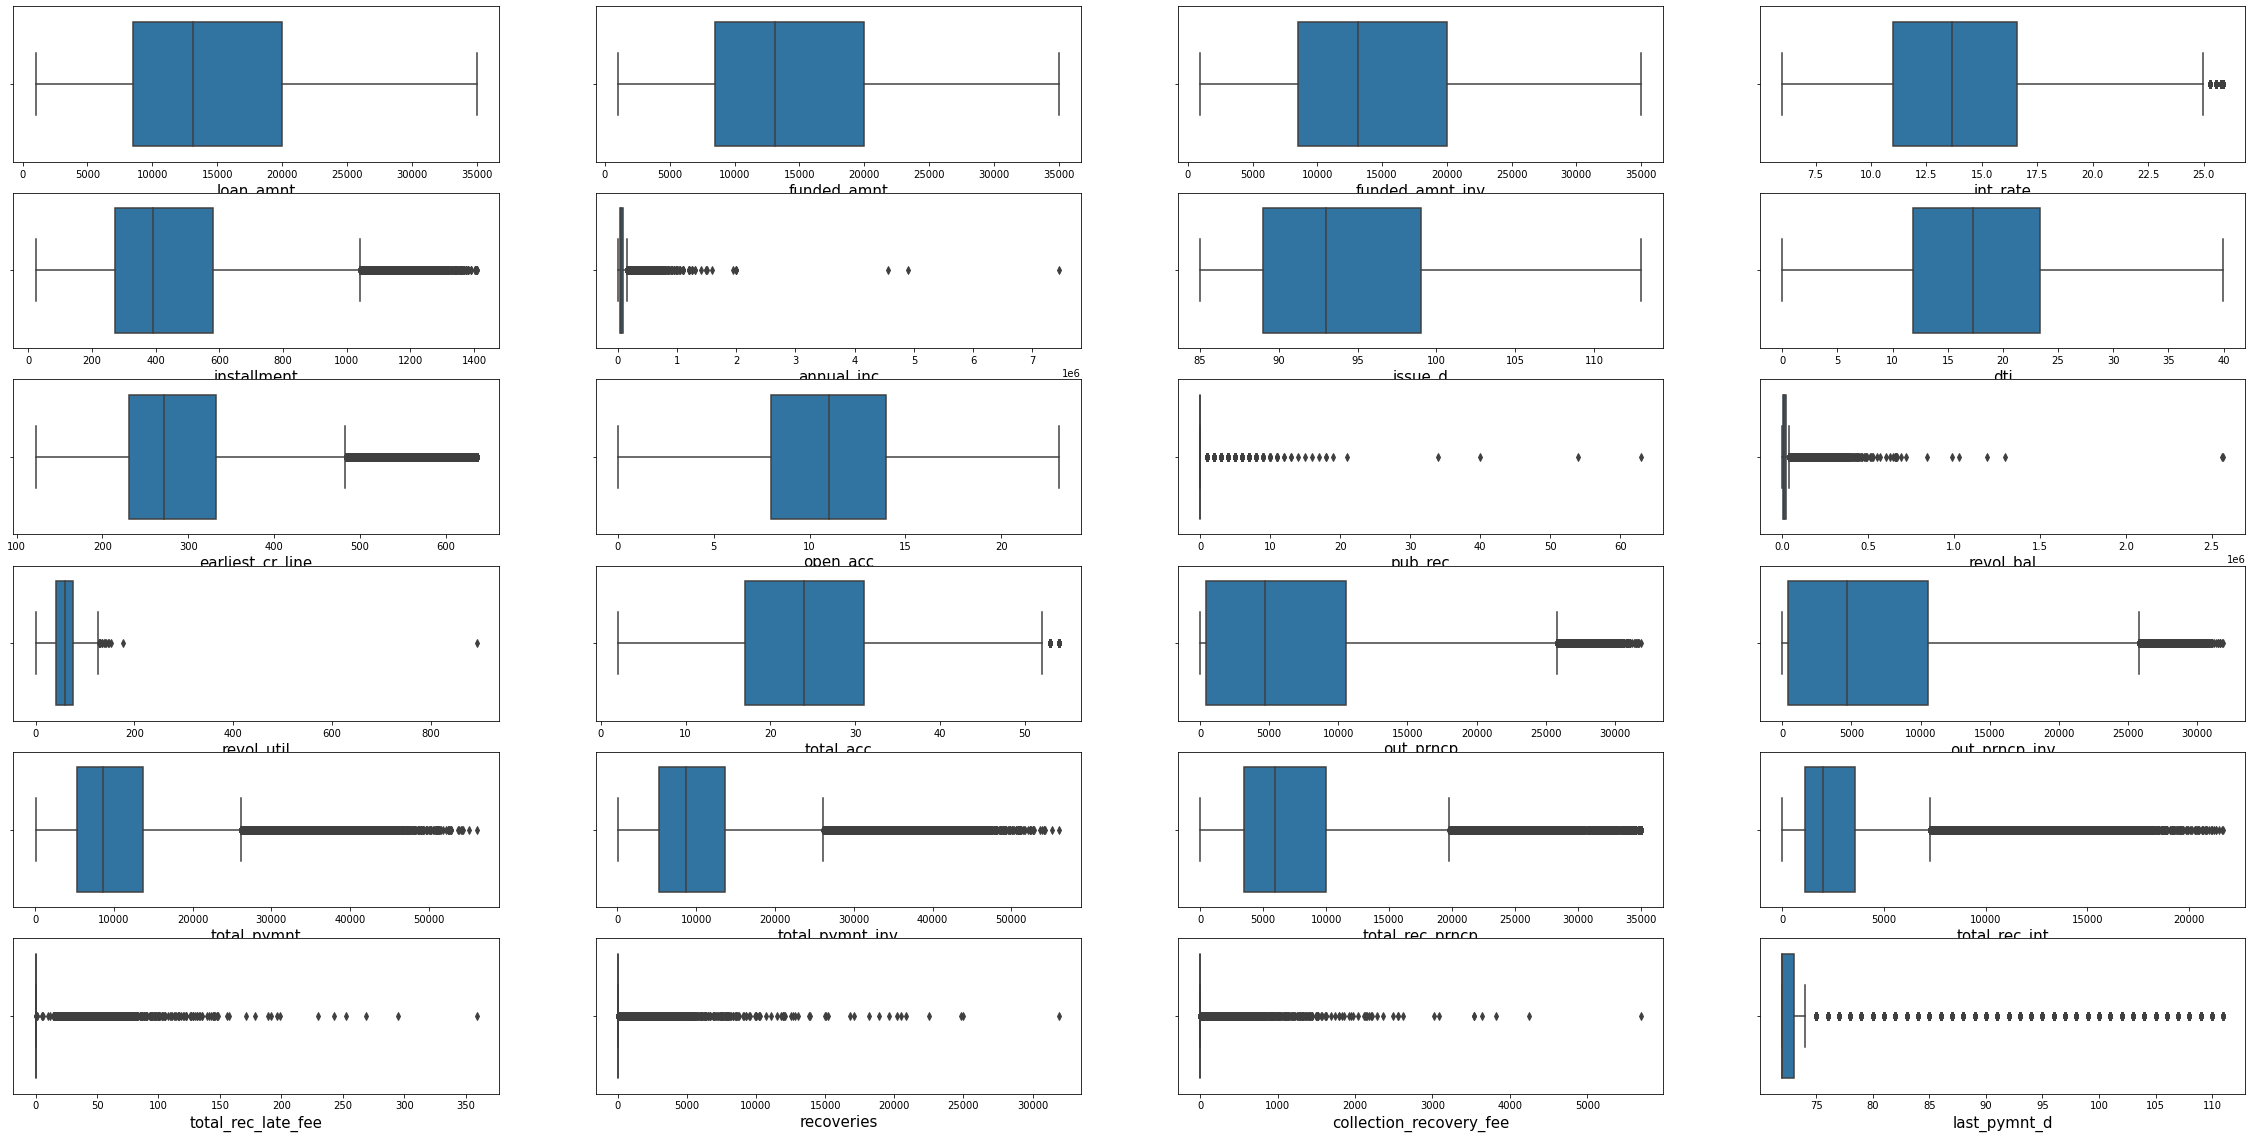

In [123]:
df = num_data_iqr

fig, axes = plt.subplots(24//4, 4, figsize=(40, 20))
for d, ax in zip(df.columns.tolist(), axes.flatten()):
    p = sns.boxplot(x=df[d], ax=ax)
    p.set_xlabel(d, fontsize = 15)
plt.show()

In [124]:
outlayer = [
  'int_rate',
  'annual_inc',
  'pub_rec',
  'revol_bal',
  'revol_util',
 'total_acc',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee' 	
#  'total_pymnt',
#  'total_pymnt_inv',
#  'total_rec_prncp',
#  'total_rec_int',
#  'last_pymnt_d',
#  'last_pymnt_amnt',
#  'last_credit_pull_d',
#  'tot_cur_bal',
#  'total_rev_hi_lim'
]

Nilai Maximum dari masing-masing Variable adalah: 
int_rate                       25.99
annual_inc                 154500.00
pub_rec                         0.00
revol_bal                   42122.50
revol_util                    126.10
total_acc                      54.50
total_rec_late_fee              0.00
recoveries                      0.00
collection_recovery_fee         0.00
dtype: float64
Nilai Minimum dari masing-masing Variable adalah: 
int_rate                       1.99
annual_inc                -17500.00
pub_rec                        0.00
revol_bal                 -14409.50
revol_util                   -10.70
total_acc                     -5.50
total_rec_late_fee             0.00
recoveries                     0.00
collection_recovery_fee        0.00
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  


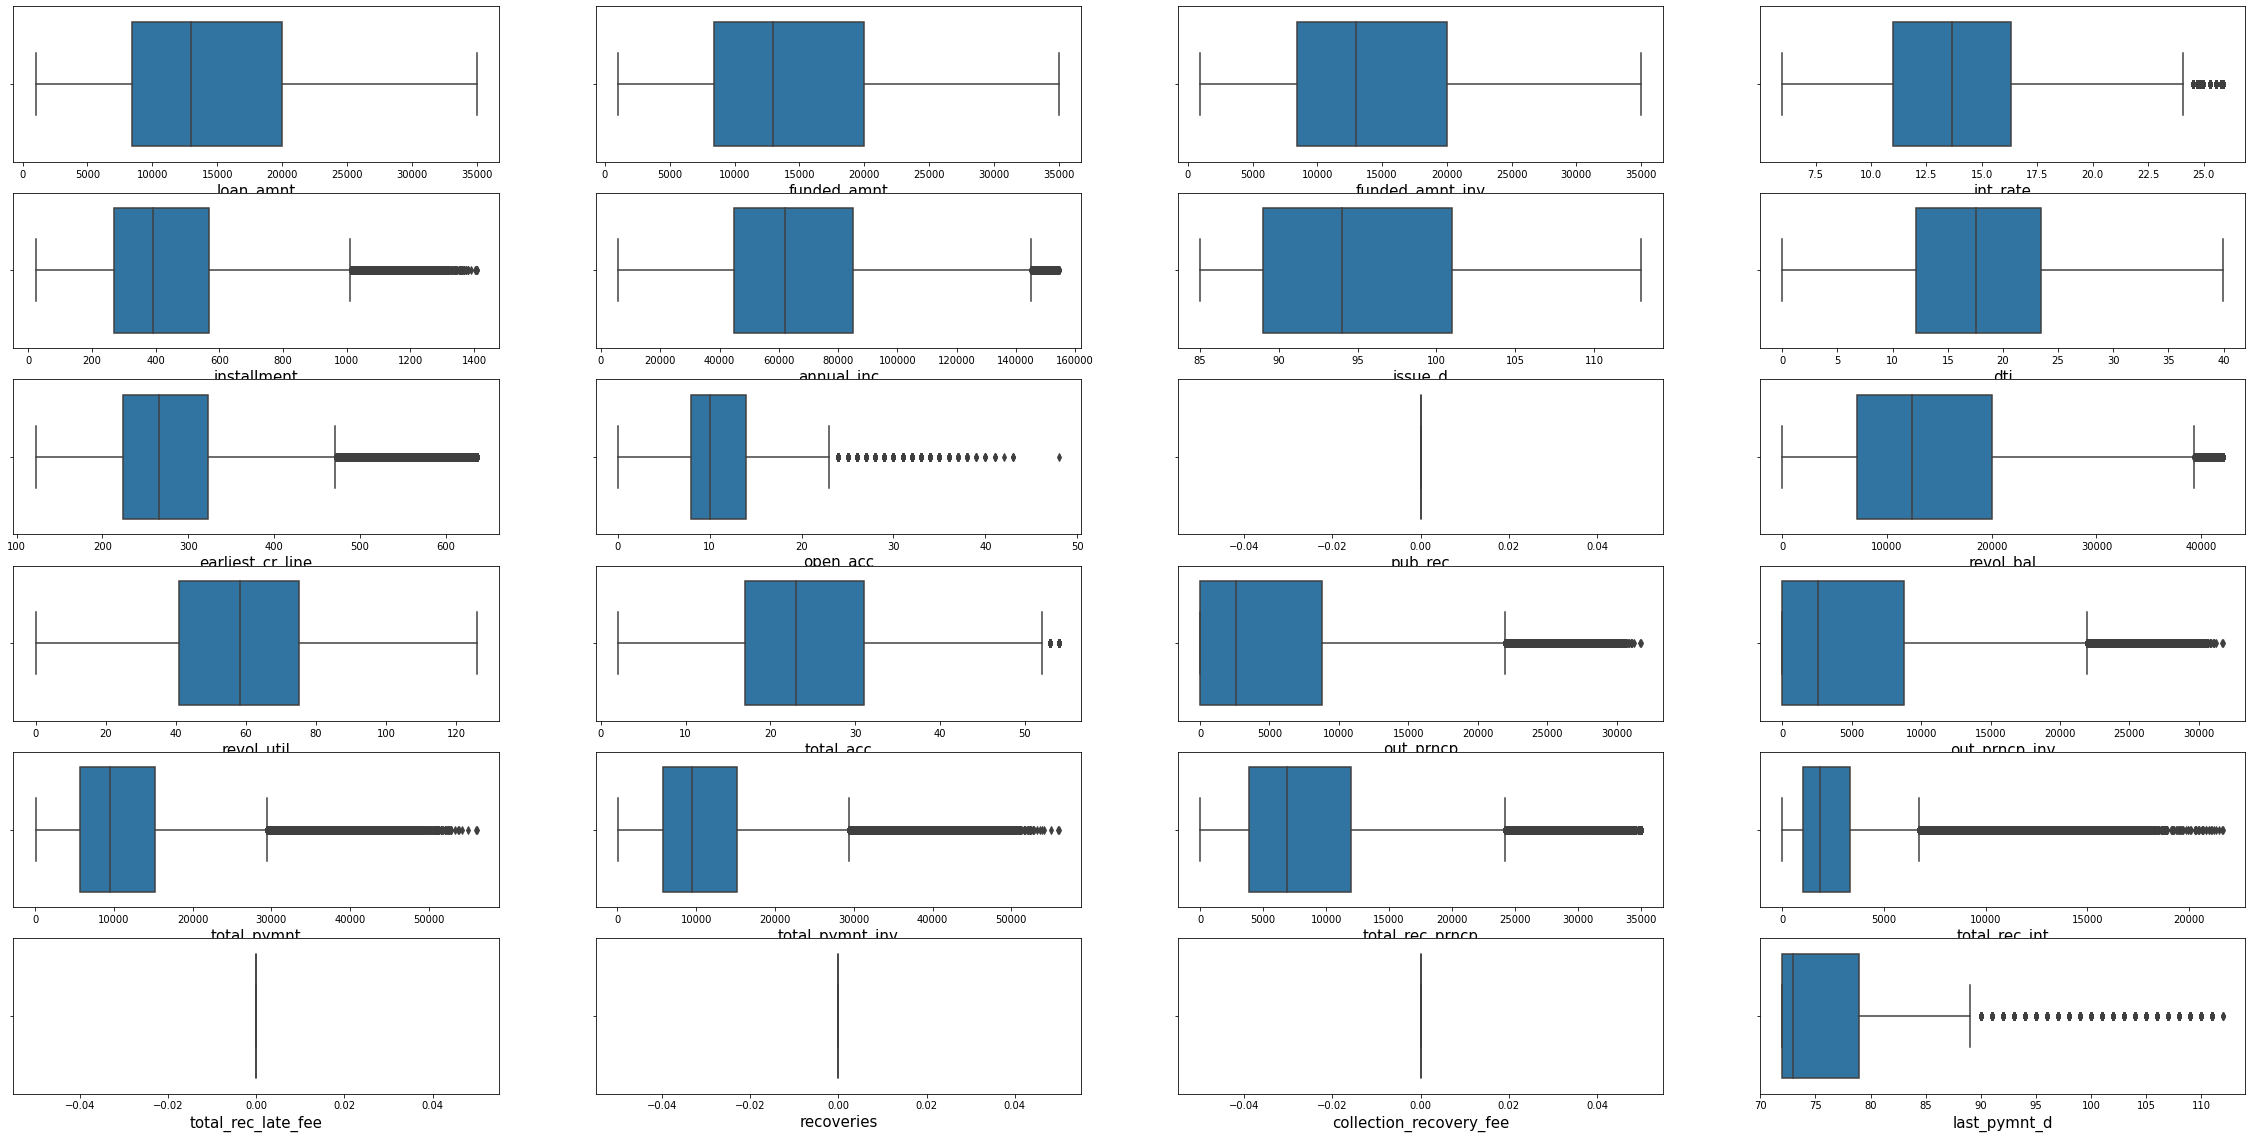

In [125]:
num_data_iqr = IQR_df(outlayer)
df = num_data_iqr

fig, axes = plt.subplots(24//4, 4, figsize=(40, 20))
for d, ax in zip(df.columns.tolist(), axes.flatten()):
    p = sns.boxplot(x=df[d], ax=ax)
    p.set_xlabel(d, fontsize = 15)
plt.show()

In [126]:
num_data_iqr.drop(columns=[
    'pub_rec', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d'
], inplace=True)

num_data_iqr

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
42535       27050        27050          27050.0     10.99       885.46   
42536        9750         9750           9750.0     13.98       333.14   
42537       12000        12000          12000.0      6.62       368.45   
42539       15000        15000          15000.0      8.90       476.30   
42540       12000        12000          12000.0     11.99       398.52   
...           ...          ...              ...       ...          ...   
466279      15000        15000          15000.0     13.53       509.25   
466280      18400        18400          18400.0     14.47       432.64   
466282      20700        20700          20700.0     16.99       514.34   
466283       2000         2000           2000.0      7.90        62.59   
466284      10000        10000           9975.0     19.20       367.58   

        annual_inc  issue_d    dti  earliest_cr_line  open_acc  revol_bal  \
42535      55000.0     97.0  22.87             423.0      14.0      36638   
42536      26000.0     97.0  25.12             180.0      12.0       7967   
42537     105000.0     97.0  14.05             334.0      12.0      13168   
42539      63000.0     97.0  16.51             286.0       8.0      11431   
42540     130000.0     97.0  13.03             290.0       9.0      10805   
...            ...      ...    ...               ...       ...        ...   
466279     66000.0     96.0  16.22             269.0       8.0      16901   
466280    110000.0     96.0  19.85             225.0      18.0      23208   
466282     46000.0     96.0  25.65             241.0      18.0       6688   
466283     83000.0     96.0   5.39             227.0      21.0      11404   
466284     46000.0     96.0  22.78             263.0       6.0      11325   

        revol_util  total_acc  out_prncp  out_prncp_inv   total_pymnt  \
42535         61.2       27.0   10018.90       10018.90  21251.040000   
42536         52.8       28.0    3710.96        3710.96   7994.830000   
42537         21.6       22.0    4266.62        4266.62   8842.800000   
42539         74.2       29.0    5449.27        5449.27  11431.200000   
42540         67.0       19.0    4485.45        4485.45   9564.400000   
...            ...        ...        ...            ...           ...   
466279        96.0       20.0    5685.63        5685.63  12222.000000   
466280        77.6       36.0   12574.00       12574.00  10383.360000   
466282        51.1       43.0   14428.31       14428.31  12343.980000   
466283        21.5       27.0       0.00           0.00   2126.579838   
466284        70.8       22.0    3984.38        3974.41   8821.620000   

        total_pymnt_inv  total_rec_prncp  total_rec_int  last_pymnt_amnt  \
42535          21251.04         17031.10        4219.94           885.46   
42536           7994.83          6039.04        1955.79           333.14   
42537           8842.80          7733.38        1109.42           368.45   
42539          11431.20          9550.73        1880.47           476.30   
42540           9564.40          7514.55        2049.85           398.52   
...                 ...              ...            ...              ...   
466279         12222.00          9314.37        2907.63           509.25   
466280         10383.36          5826.00        4557.36           432.64   
466282         12343.98          6271.69        6072.29           514.34   
466283          2126.58          2000.00         126.58          1500.68   
466284          8799.57          6015.62        2806.00           367.58   

        last_credit_pull_d  collections_12_mths_ex_med  tot_coll_amt  \
42535                 73.0                         0.0           0.0   
42536                 72.0                         0.0           0.0   
42537                 72.0                         0.0           0.0   
42539                 72.0                         0.0        1514.0   
42540                 72.0                  

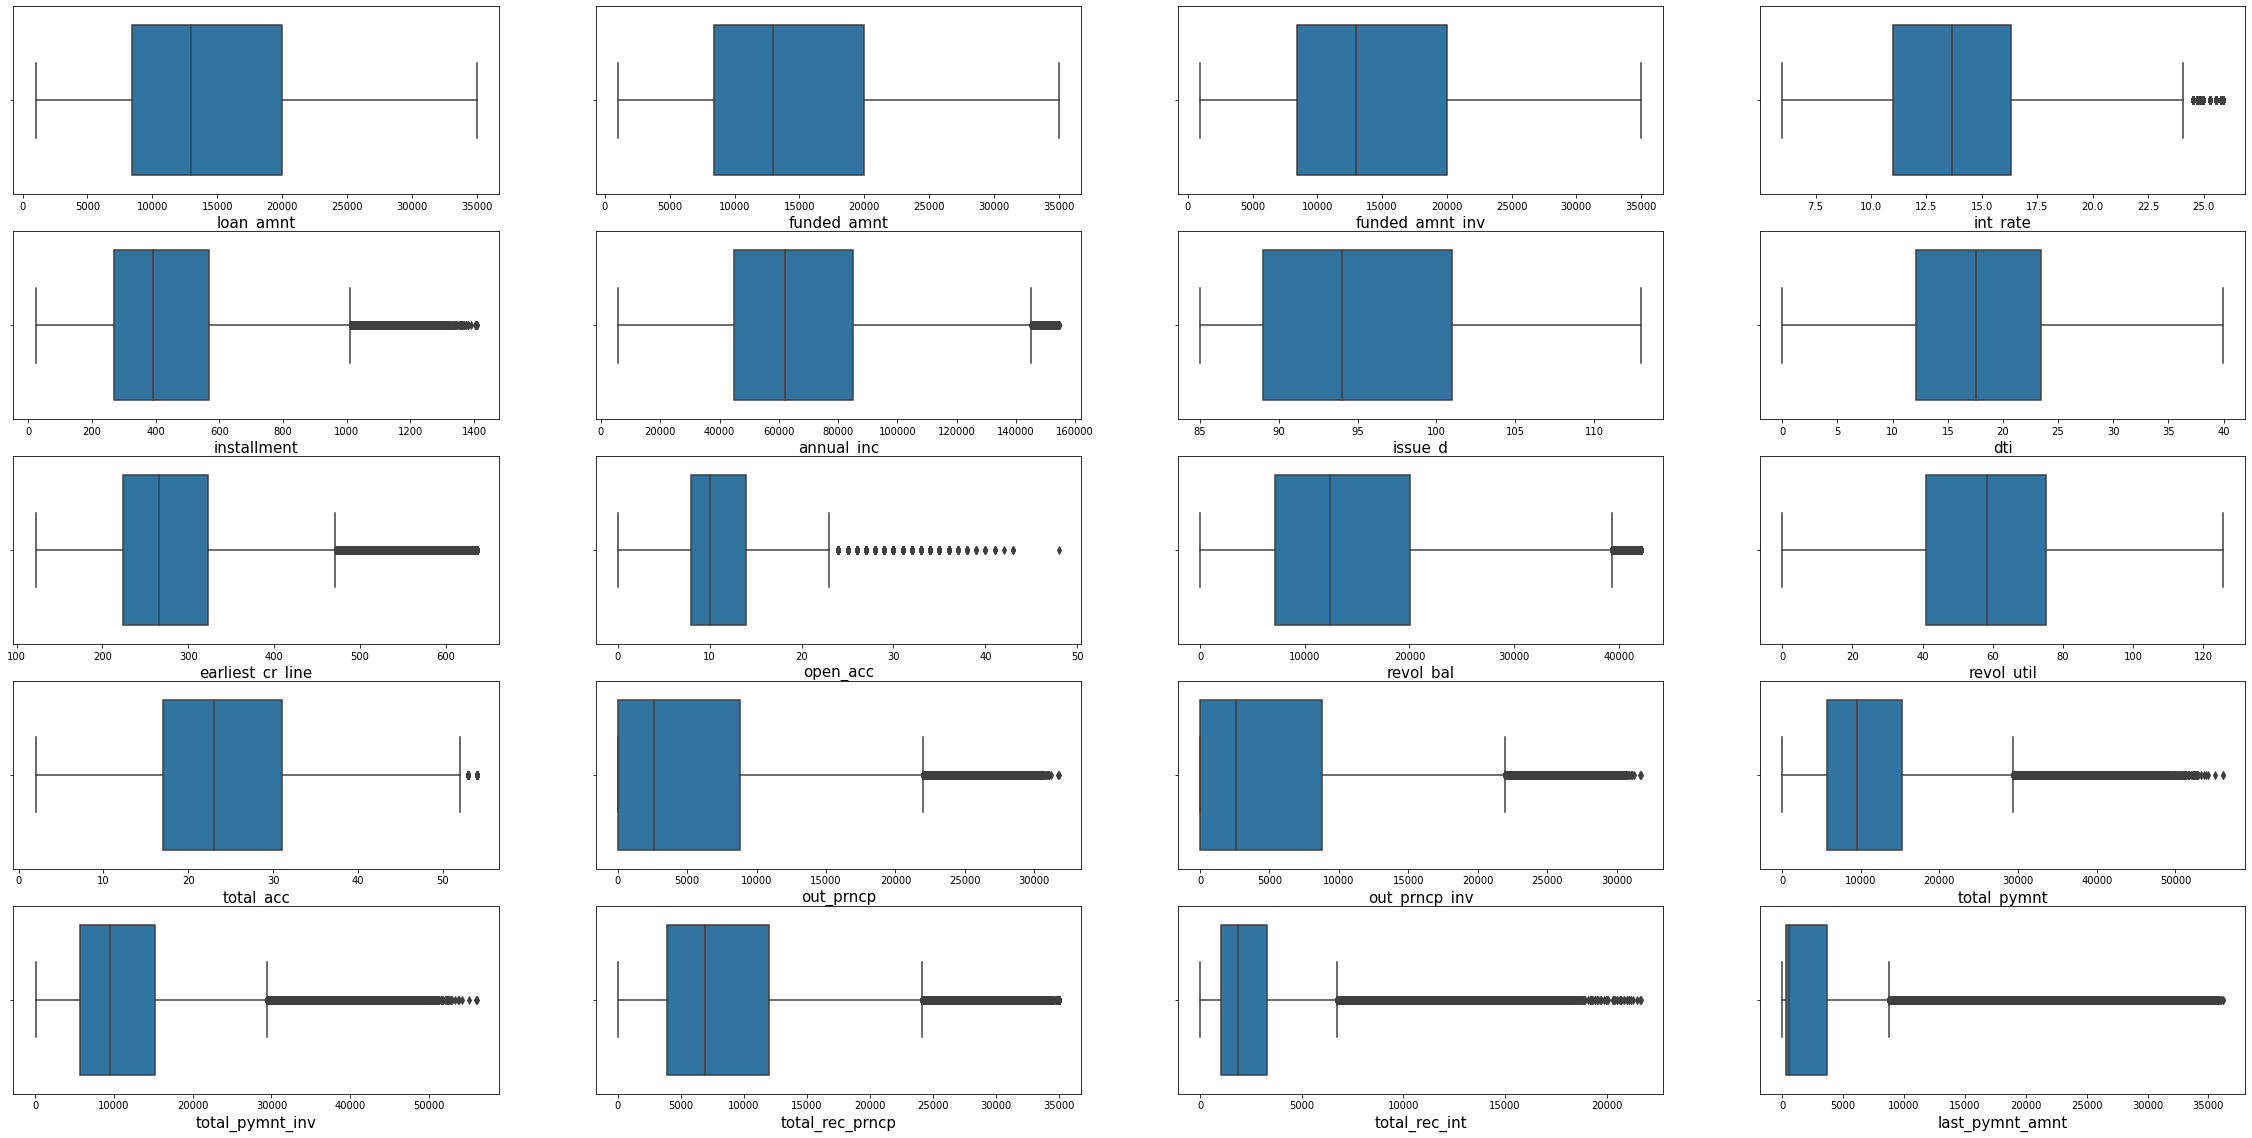

In [127]:
df = num_data_iqr

fig, axes = plt.subplots(20//4, 4, figsize=(40, 20))
for d, ax in zip(df.columns.tolist(), axes.flatten()):
    p = sns.boxplot(x=df[d], ax=ax)
    p.set_xlabel(d, fontsize = 15)
plt.show()

## Cek Skewness

In [128]:
len(num_data_iqr.columns.tolist())

25

In [129]:
num_data_iqr.columns.tolist()

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'issue_d',
 'dti',
 'earliest_cr_line',
 'open_acc',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim']

In [130]:
import warnings
warnings.filterwarnings("ignore")

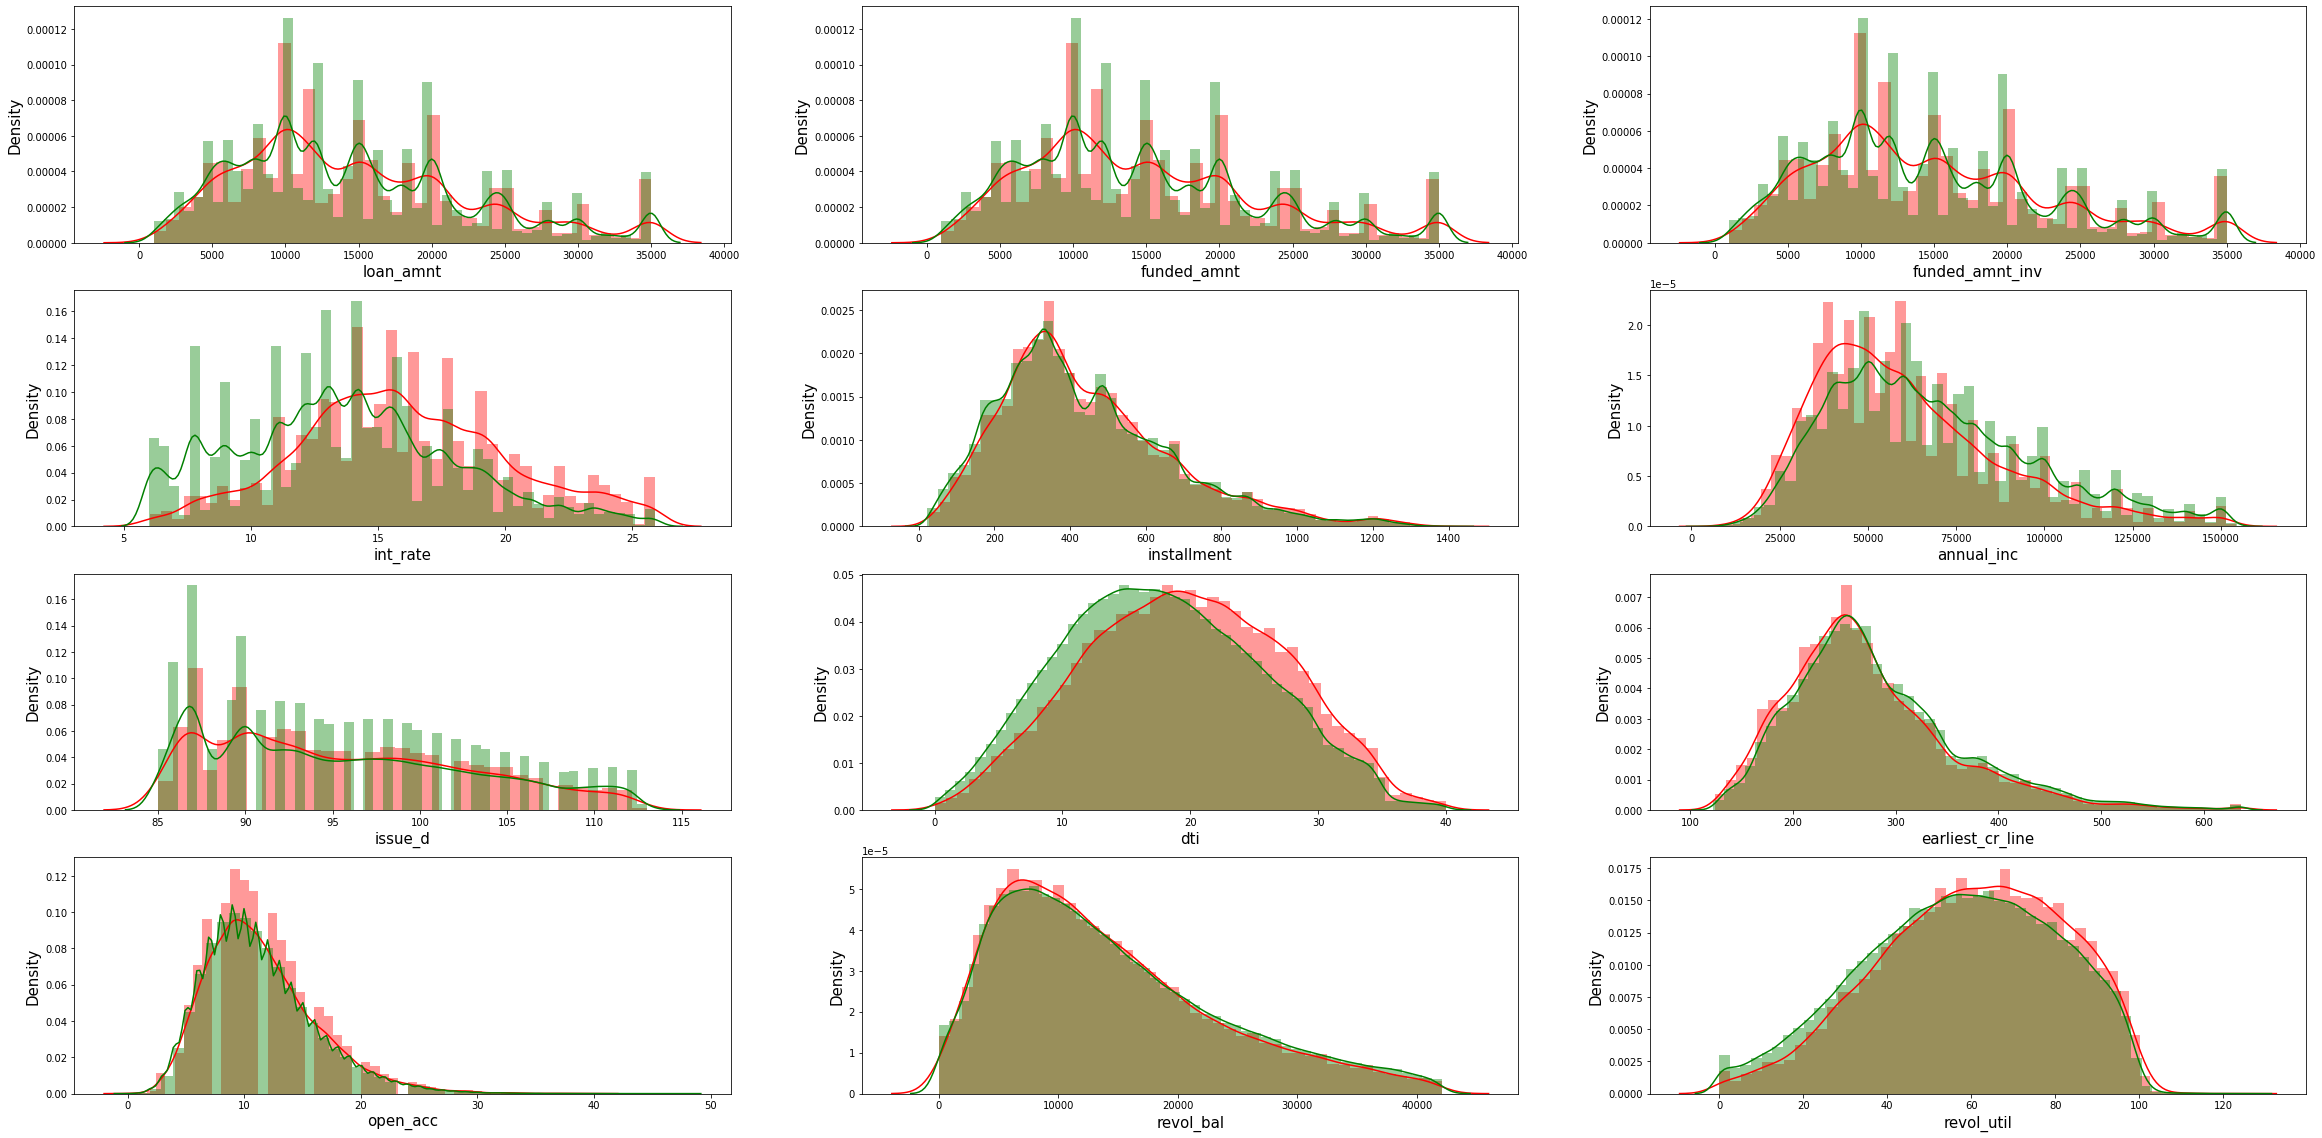

In [172]:
df = num_data_iqr
col = num_data_iqr.columns[:14].tolist()

fig, axes = plt.subplots(len(col)//3, 3, figsize=(40, 20))
for d, ax in zip(col, axes.flatten()):
    p = sns.distplot(df.loc[(loan_data["good_bad"]==0), d], color="r", label="Bad", ax=ax)
    p = sns.distplot(df.loc[(loan_data["good_bad"]==1), d], color="g", label="Good", ax=ax)
    p.set_xlabel(d, fontsize = 15)
    p.set_ylabel("Density", fontsize = 15)
plt.show();

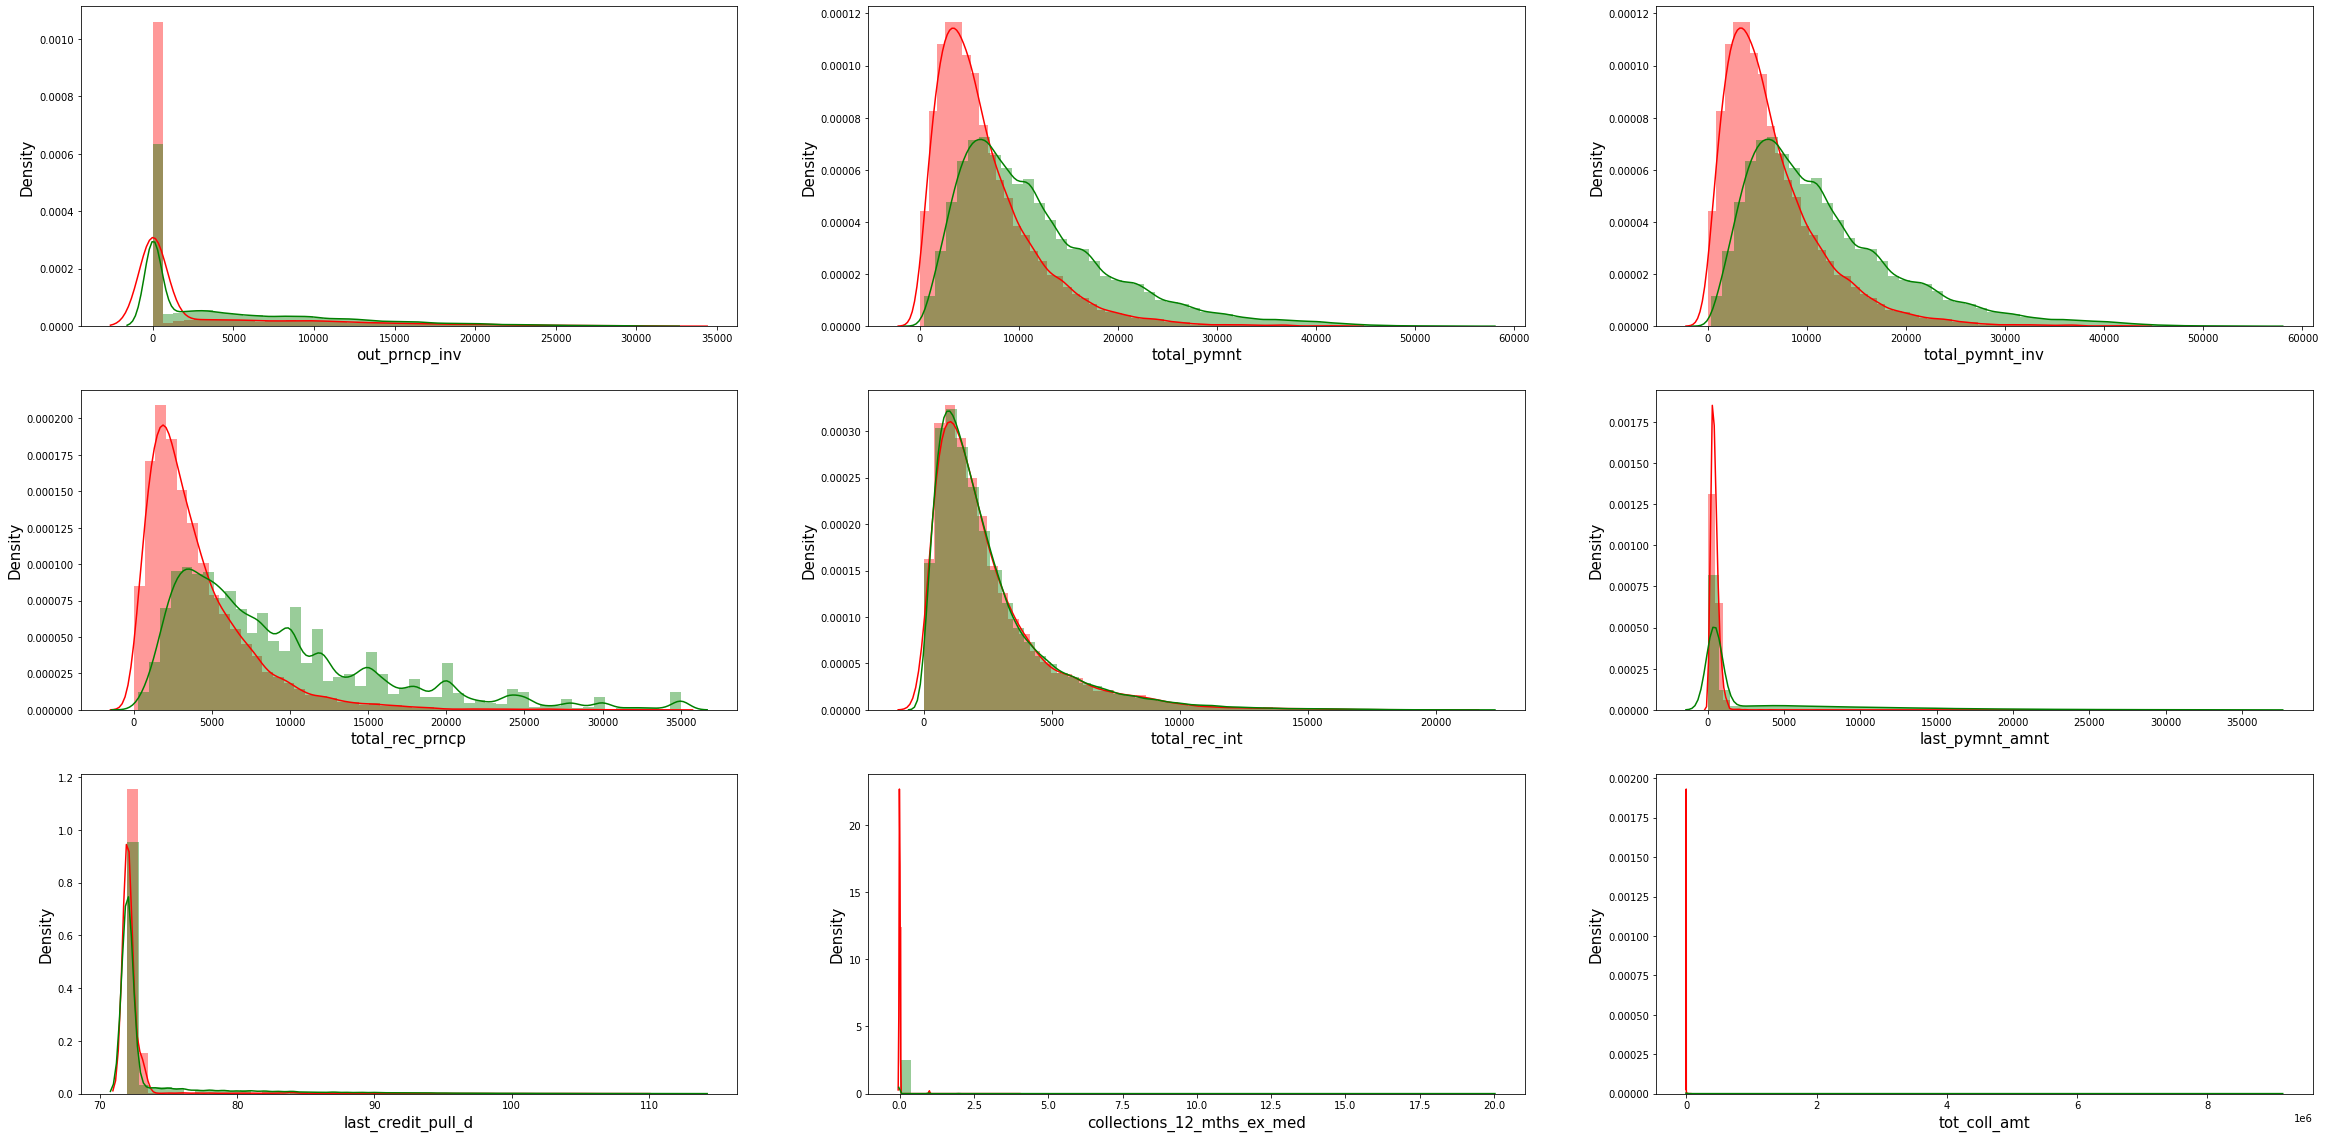

In [173]:
df = num_data_iqr
col = num_data_iqr.columns[14:].tolist()

fig, axes = plt.subplots(len(col)//3, 3, figsize=(40, 20))
for d, ax in zip(col, axes.flatten()):
    p = sns.distplot(df.loc[(loan_data["good_bad"]==0), d], color="r", label="Bad", ax=ax)
    p = sns.distplot(df.loc[(loan_data["good_bad"]==1), d], color="g", label="Good", ax=ax)
    p.set_xlabel(d, fontsize = 15)
    p.set_ylabel("Density", fontsize = 15)
plt.show();

In [174]:
num_data_iqr.describe()

loan_amnt    funded_amnt  funded_amnt_inv       int_rate  \
count  272545.000000  272545.000000    272545.000000  272545.000000   
mean    14485.068704   14485.067695     14478.510392      13.805449   
std      7910.136154    7910.134330      7906.985369       4.352906   
min      1000.000000    1000.000000       950.000000       6.000000   
25%      8400.000000    8400.000000      8400.000000      10.990000   
50%     13000.000000   13000.000000     13000.000000      13.650000   
75%     20000.000000   20000.000000     20000.000000      16.290000   
max     35000.000000   35000.000000     35000.000000      25.890000   

         installment     annual_inc        issue_d            dti  \
count  272545.000000  272545.000000  272545.000000  272545.000000   
mean      435.897251   67242.547833      95.633084      17.890660   
std       229.704715   28486.916374       7.506910       7.774337   
min        23.260000    5674.000000      85.000000       0.000000   
25%       270.810000   45000.000000      89.000000      12.090000   
50%       390.800000   62000.000000      94.000000      17.540000   
75%       567.300000   85000.000000     101.000000      23.480000   
max      1408.130000  154500.000000     113.000000      39.990000   

       earliest_cr_line       open_acc      revol_bal     revol_util  \
count     272545.000000  272545.000000  272545.000000  272545.000000   
mean         280.472322      11.216896   14430.578712      57.228406   
std           82.688840       4.710208    9397.438304      22.897766   
min          122.000000       0.000000       0.000000       0.000000   
25%          224.000000       8.000000    7113.000000      40.900000   
50%          266.000000      10.000000   12394.000000      58.400000   
75%          323.000000      14.000000   20009.000000      75.100000   
max          636.000000      48.000000   42122.000000     125.800000   

           total_acc      out_prncp  out_prncp_inv    total_pymnt  \
count  272545.000000  272545.000000  272545.000000  272545.000000   
mean       24.381310    5172.151843    5170.419336   11459.024463   
std        10.370958    6438.134256    6436.355148    7859.470406   
min         2.000000       0.000000       0.000000      35.690000   
25%        17.000000       0.000000       0.000000    5717.300000   
50%        23.000000    2578.230000    2576.970000    9508.050000   
75%        31.000000    8787.800000    8781.230000   15187.380000   
max        54.000000   31769.850000   31769.850000   56087.909920   

       total_pymnt_inv  total_rec_prncp  total_rec_int  last_pymnt_amnt  \
count    272545.000000    272545.000000  272545.000000    272545.000000   
mean      11453.190458      8865.160865    2593.863602      3267.558558   
std        7854.990019      6779.971066    2382.377900      5656.845952   
min          35.690000         0.000000       0.000000         0.010000   
25%        5715.560000      3884.590000    1018.570000       323.760000   
50%        9500.220000      6925.000000    1876.010000       544.100000   
75%       15181.140000     12000.000000    3306.320000      3690.380000   
max       56047.850000     35000.000000   21702.150000     36234.440000   

       last_credit_pull_d  collections_12_mths_ex_med  tot_coll_amt  \
count       272545.000000               272545.000000  2.725450e+05   
mean            73.813139                    0.010061  1.780801e+02   
std              4.878509                    0.113329  1.758973e+04   
min             72.000000                    0.000000  0.000000e+00   
25%             72.000000                    0.000000  0.000000e+00   
50%             72.000000                    0.000000  0.000000e+00   
75%             72.000000                    0.000000  0.000000e+00   
max            113.000000                   20.000000  9.152545e+06   

        tot_cur_bal  total_rev_hi_lim  
count  2.725450e+05     272545.000000  
mean   1.265677e+05      27713.351681  
std    1.248455e+05      19574.848845  
mi

### Handling Skewness

In [176]:
skew_feats = num_data_iqr.skew().sort_values(ascending=False)
skew = pd.DataFrame({'Skew':skew_feats})
skew

Skew
tot_coll_amt                516.907891
collections_12_mths_ex_med   30.255109
last_credit_pull_d            3.440936
last_pymnt_amnt               2.392157
total_rec_int                 2.182533
total_rev_hi_lim              2.071950
tot_cur_bal                   1.452412
total_rec_prncp               1.434477
total_pymnt_inv               1.359064
total_pymnt                   1.358608
out_prncp_inv                 1.320504
out_prncp                     1.320186
earliest_cr_line              0.997724
open_acc                      0.915570
installment                   0.893546
revol_bal                     0.806164
annual_inc                    0.733438
funded_amnt_inv               0.675049
loan_amnt                     0.674619
funded_amnt                   0.674618
total_acc                     0.479568
issue_d                       0.473862
int_rate                      0.332143
dti                           0.165440
revol_util                   -0.254634

In [177]:
num_data_iqr_t = num_data_iqr.copy()
num_data_iqr_t

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
42535       27050        27050          27050.0     10.99       885.46   
42536        9750         9750           9750.0     13.98       333.14   
42537       12000        12000          12000.0      6.62       368.45   
42539       15000        15000          15000.0      8.90       476.30   
42540       12000        12000          12000.0     11.99       398.52   
...           ...          ...              ...       ...          ...   
466279      15000        15000          15000.0     13.53       509.25   
466280      18400        18400          18400.0     14.47       432.64   
466282      20700        20700          20700.0     16.99       514.34   
466283       2000         2000           2000.0      7.90        62.59   
466284      10000        10000           9975.0     19.20       367.58   

        annual_inc  issue_d    dti  earliest_cr_line  open_acc  revol_bal  \
42535      55000.0     97.0  22.87             423.0      14.0      36638   
42536      26000.0     97.0  25.12             180.0      12.0       7967   
42537     105000.0     97.0  14.05             334.0      12.0      13168   
42539      63000.0     97.0  16.51             286.0       8.0      11431   
42540     130000.0     97.0  13.03             290.0       9.0      10805   
...            ...      ...    ...               ...       ...        ...   
466279     66000.0     96.0  16.22             269.0       8.0      16901   
466280    110000.0     96.0  19.85             225.0      18.0      23208   
466282     46000.0     96.0  25.65             241.0      18.0       6688   
466283     83000.0     96.0   5.39             227.0      21.0      11404   
466284     46000.0     96.0  22.78             263.0       6.0      11325   

        revol_util  total_acc  out_prncp  out_prncp_inv   total_pymnt  \
42535         61.2       27.0   10018.90       10018.90  21251.040000   
42536         52.8       28.0    3710.96        3710.96   7994.830000   
42537         21.6       22.0    4266.62        4266.62   8842.800000   
42539         74.2       29.0    5449.27        5449.27  11431.200000   
42540         67.0       19.0    4485.45        4485.45   9564.400000   
...            ...        ...        ...            ...           ...   
466279        96.0       20.0    5685.63        5685.63  12222.000000   
466280        77.6       36.0   12574.00       12574.00  10383.360000   
466282        51.1       43.0   14428.31       14428.31  12343.980000   
466283        21.5       27.0       0.00           0.00   2126.579838   
466284        70.8       22.0    3984.38        3974.41   8821.620000   

        total_pymnt_inv  total_rec_prncp  total_rec_int  last_pymnt_amnt  \
42535          21251.04         17031.10        4219.94           885.46   
42536           7994.83          6039.04        1955.79           333.14   
42537           8842.80          7733.38        1109.42           368.45   
42539          11431.20          9550.73        1880.47           476.30   
42540           9564.40          7514.55        2049.85           398.52   
...                 ...              ...            ...              ...   
466279         12222.00          9314.37        2907.63           509.25   
466280         10383.36          5826.00        4557.36           432.64   
466282         12343.98          6271.69        6072.29           514.34   
466283          2126.58          2000.00         126.58          1500.68   
466284          8799.57          6015.62        2806.00           367.58   

        last_credit_pull_d  collections_12_mths_ex_med  tot_coll_amt  \
42535                 73.0                         0.0           0.0   
42536                 72.0                         0.0           0.0   
42537                 72.0                         0.0           0.0   
42539                 72.0                         0.0        1514.0   
42540                 72.0                  

In [178]:
skew.iloc[:][skew['Skew']>=30].T.columns

Index(['tot_coll_amt', 'collections_12_mths_ex_med'], dtype='object')

In [179]:
## Box Cox Transformation
col = skew.iloc[:][skew['Skew']>=30].T.columns.tolist()

num_data_iqr_t = num_data_iqr_t[num_data_iqr_t > 0]

for i in col:
  num_data_iqr_t[i], lmbda = boxcox(num_data_iqr_t[i], lmbda=None)

num_data_iqr_t.describe(), lmbda

(           loan_amnt    funded_amnt  funded_amnt_inv       int_rate  \
 count  272545.000000  272545.000000    272545.000000  272545.000000   
 mean    14485.068704   14485.067695     14478.510392      13.805449   
 std      7910.136154    7910.134330      7906.985369       4.352906   
 min      1000.000000    1000.000000       950.000000       6.000000   
 25%      8400.000000    8400.000000      8400.000000      10.990000   
 50%     13000.000000   13000.000000     13000.000000      13.650000   
 75%     20000.000000   20000.000000     20000.000000      16.290000   
 max     35000.000000   35000.000000     35000.000000      25.890000   
 
          installment     annual_inc        issue_d            dti  \
 count  272545.000000  272545.000000  272545.000000  272449.000000   
 mean      435.897251   67242.547833      95.633084      17.896964   
 std       229.704715   28486.916374       7.506910       7.768448   
 min        23.260000    5674.000000      85.000000       0.010000   


In [180]:
skew_feats = num_data_iqr_t.skew().sort_values(ascending=False)
skew = pd.DataFrame({'Skew':skew_feats})
skew

Skew
tot_coll_amt                178.723250
collections_12_mths_ex_med   50.438081
last_credit_pull_d            3.440936
last_pymnt_amnt               2.392157
total_rec_int                 2.182539
total_rev_hi_lim              2.073619
tot_cur_bal                   1.452310
total_rec_prncp               1.434486
total_pymnt_inv               1.359064
total_pymnt                   1.358608
earliest_cr_line              0.997724
out_prncp_inv                 0.932462
out_prncp                     0.932100
open_acc                      0.915821
installment                   0.893546
revol_bal                     0.810075
annual_inc                    0.733438
funded_amnt_inv               0.675049
loan_amnt                     0.674619
funded_amnt                   0.674618
total_acc                     0.479568
issue_d                       0.473862
int_rate                      0.332143
dti                           0.167745
revol_util                   -0.238952

In [162]:
from scipy.stats import boxcox

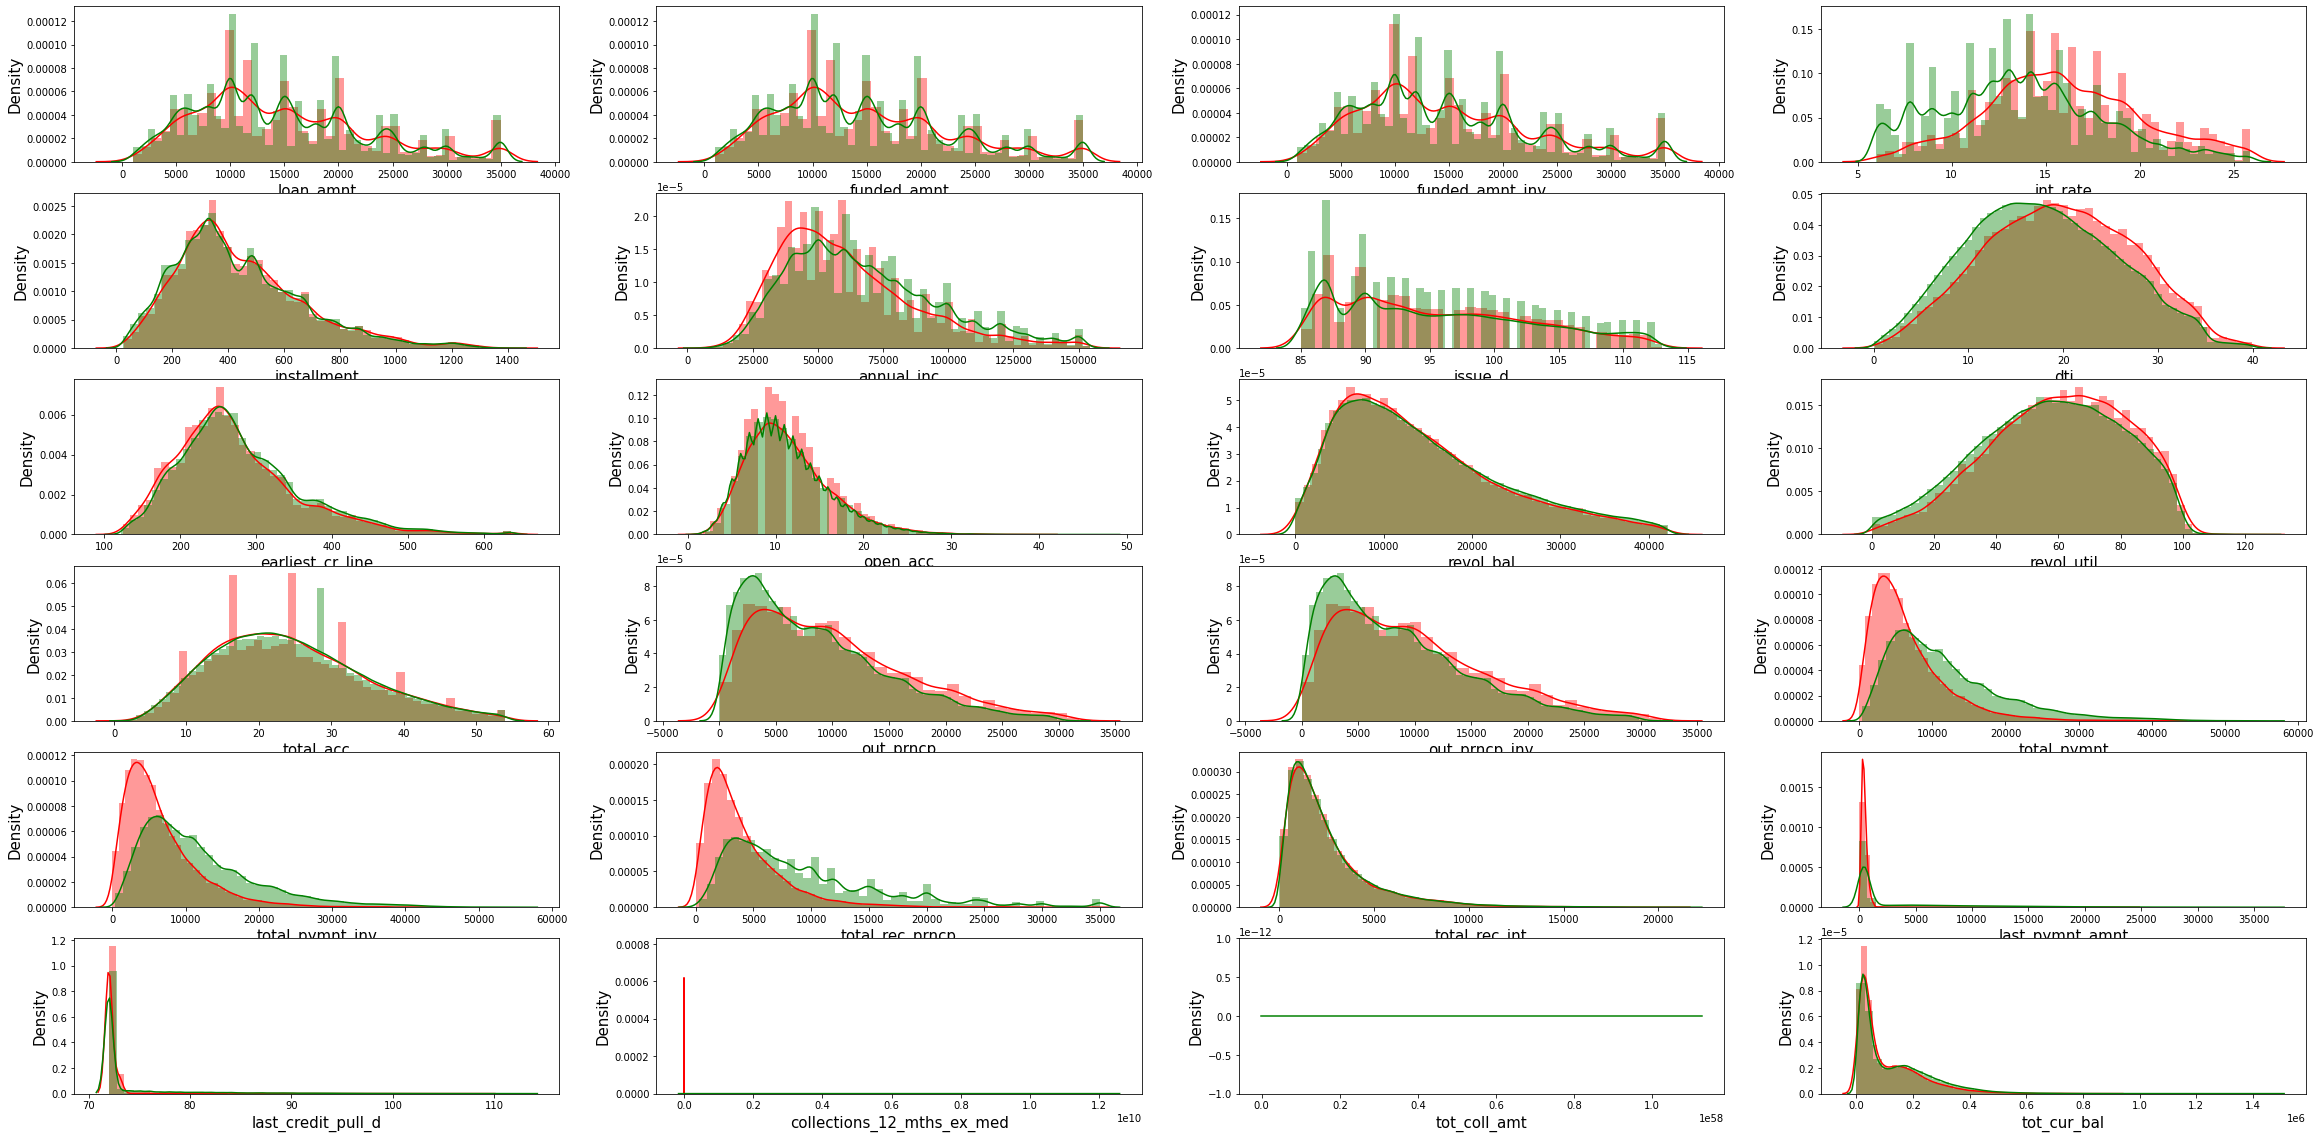

In [181]:
df = num_data_iqr_t
col = num_data_iqr_t.columns.tolist()

fig, axes = plt.subplots(len(col)//4, 4, figsize=(40, 20))
for d, ax in zip(col, axes.flatten()):
    p = sns.distplot(df.loc[(loan_data["good_bad"]==0), d], color="r", label="Bad", ax=ax)
    p = sns.distplot(df.loc[(loan_data["good_bad"]==1), d], color="g", label="Good", ax=ax)
    p.set_xlabel(d, fontsize = 15)
    p.set_ylabel("Density", fontsize = 15)
plt.show();

In [182]:
skew.iloc[:][skew['Skew']>=30].T.columns

Index(['tot_coll_amt', 'collections_12_mths_ex_med'], dtype='object')

In [183]:
num_data_iqr_t.drop(
    skew.iloc[:][skew['Skew']>50].T.columns.tolist(), 
    inplace=True, axis=1
)

num_data_iqr_t.head()

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
42535      27050        27050          27050.0     10.99       885.46   
42536       9750         9750           9750.0     13.98       333.14   
42537      12000        12000          12000.0      6.62       368.45   
42539      15000        15000          15000.0      8.90       476.30   
42540      12000        12000          12000.0     11.99       398.52   

       annual_inc  issue_d    dti  earliest_cr_line  open_acc  revol_bal  \
42535     55000.0     97.0  22.87             423.0      14.0    36638.0   
42536     26000.0     97.0  25.12             180.0      12.0     7967.0   
42537    105000.0     97.0  14.05             334.0      12.0    13168.0   
42539     63000.0     97.0  16.51             286.0       8.0    11431.0   
42540    130000.0     97.0  13.03             290.0       9.0    10805.0   

       revol_util  total_acc  out_prncp  out_prncp_inv  total_pymnt  \
42535        61.2       27.0   10018.90       10018.90     21251.04   
42536        52.8       28.0    3710.96        3710.96      7994.83   
42537        21.6       22.0    4266.62        4266.62      8842.80   
42539        74.2       29.0    5449.27        5449.27     11431.20   
42540        67.0       19.0    4485.45        4485.45      9564.40   

       total_pymnt_inv  total_rec_prncp  total_rec_int  last_pymnt_amnt  \
42535         21251.04         17031.10        4219.94           885.46   
42536          7994.83          6039.04        1955.79           333.14   
42537          8842.80          7733.38        1109.42           368.45   
42539         11431.20          9550.73        1880.47           476.30   
42540          9564.40          7514.55        2049.85           398.52   

       last_credit_pull_d  tot_cur_bal  total_rev_hi_lim  
42535                73.0     114834.0           59900.0  
42536                72.0      14123.0           15100.0  
42537                72.0     267646.0           61100.0  
42539                72.0     272492.0           15400.0  
42540                72.0     327264.0           16200.0

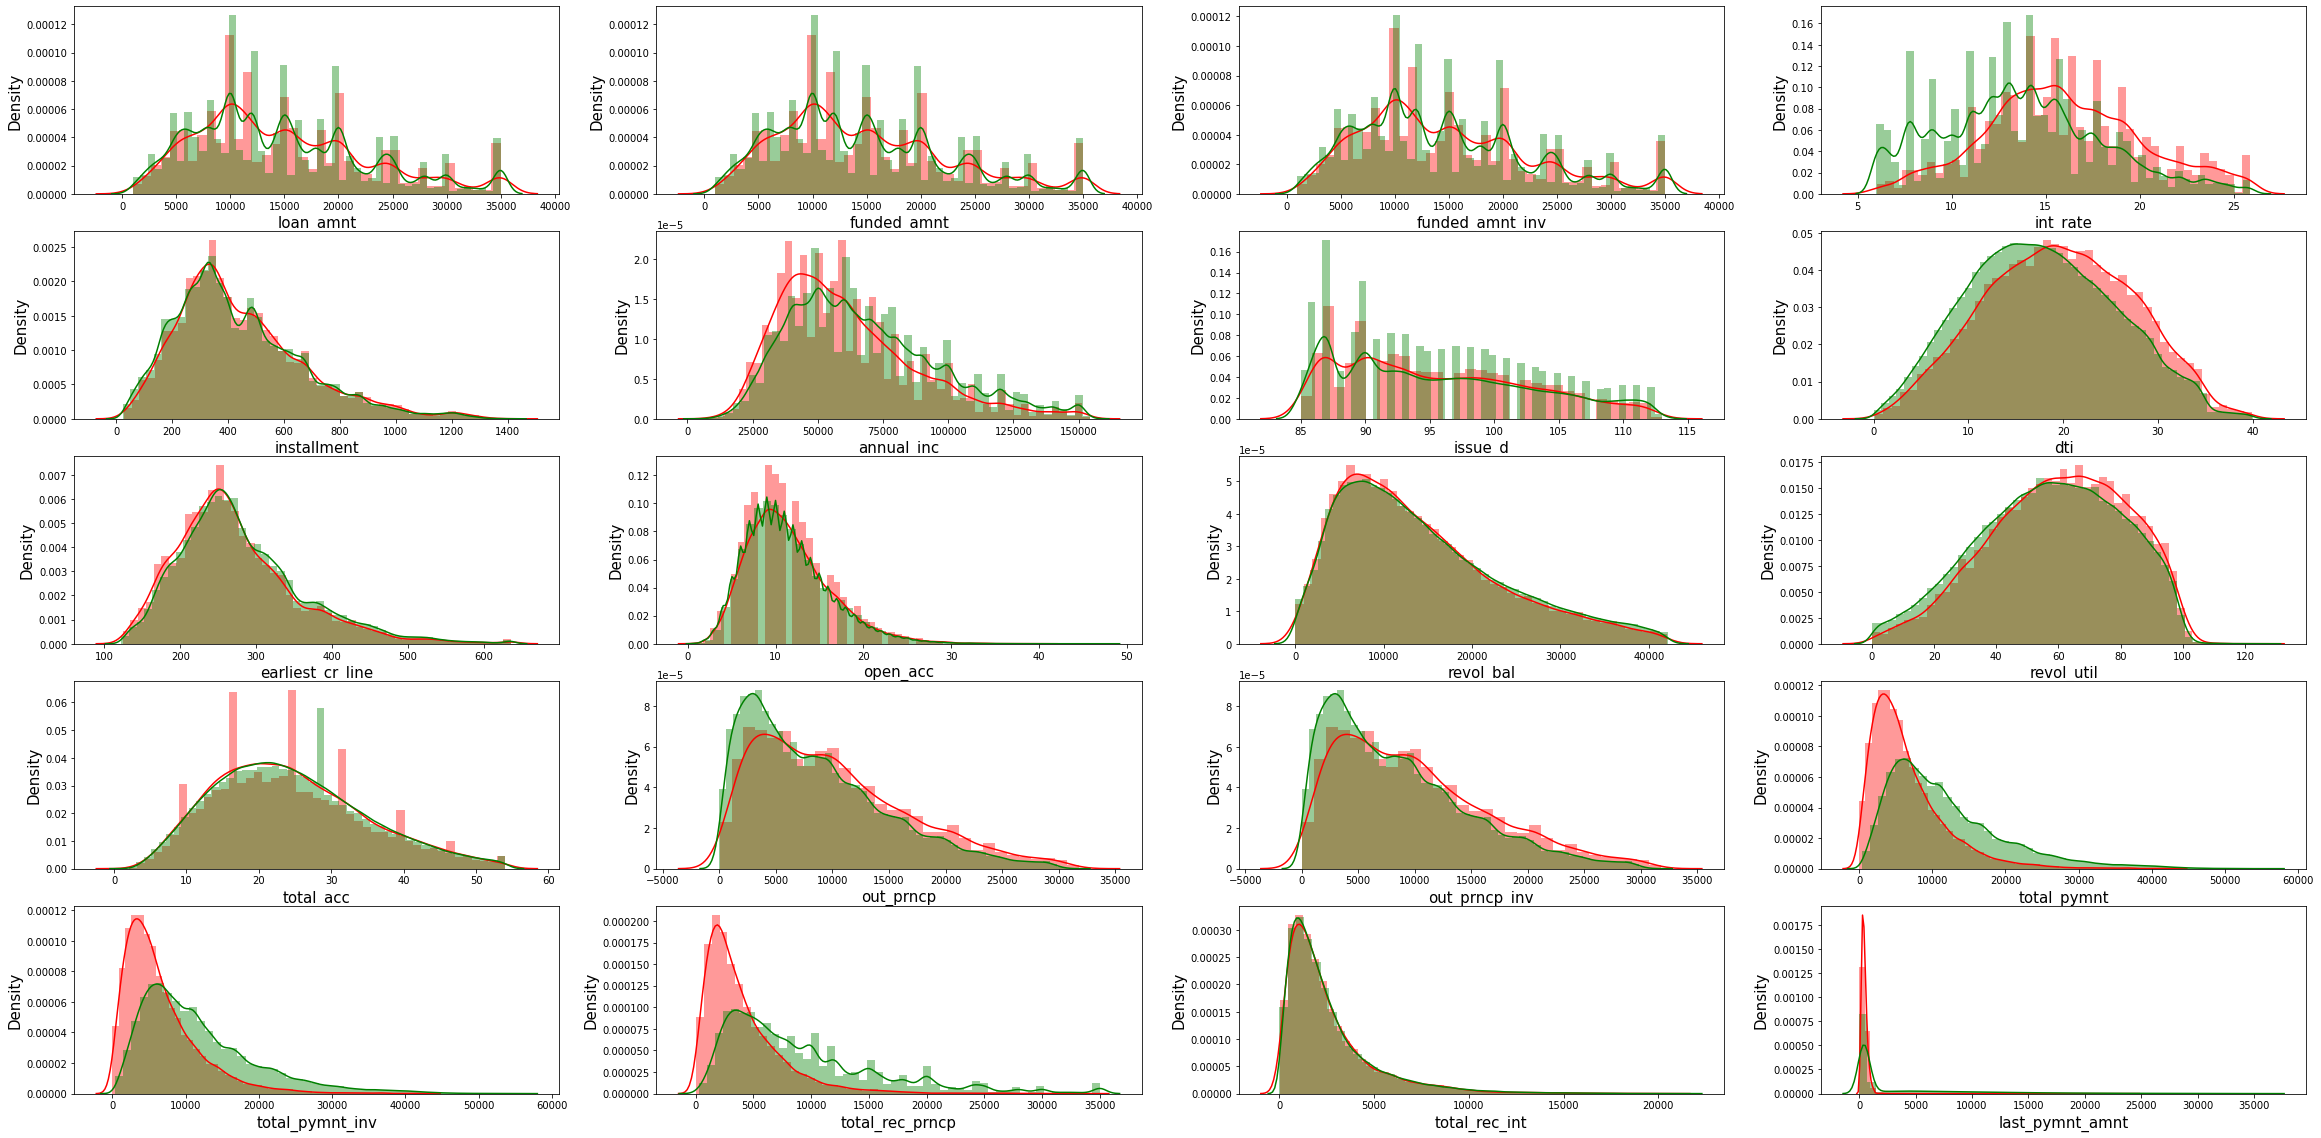

In [184]:
df = num_data_iqr_t
col = num_data_iqr_t.columns.tolist()

fig, axes = plt.subplots(len(col)//4, 4, figsize=(40, 20))
for d, ax in zip(col, axes.flatten()):
    p = sns.distplot(df.loc[(loan_data["good_bad"]==0), d], color="r", label="Bad", ax=ax)
    p = sns.distplot(df.loc[(loan_data["good_bad"]==1), d], color="g", label="Good", ax=ax)
    p.set_xlabel(d, fontsize = 15)
    p.set_ylabel("Density", fontsize = 15)
plt.show();

In [186]:
skew_feats = num_data_iqr_t.skew().sort_values(ascending=False)
skew = pd.DataFrame({'Skew':skew_feats})
skew

Skew
last_credit_pull_d  3.440936
last_pymnt_amnt     2.392157
total_rec_int       2.182539
total_rev_hi_lim    2.073619
tot_cur_bal         1.452310
total_rec_prncp     1.434486
total_pymnt_inv     1.359064
total_pymnt         1.358608
earliest_cr_line    0.997724
out_prncp_inv       0.932462
out_prncp           0.932100
open_acc            0.915821
installment         0.893546
revol_bal           0.810075
annual_inc          0.733438
funded_amnt_inv     0.675049
loan_amnt           0.674619
funded_amnt         0.674618
total_acc           0.479568
issue_d             0.473862
int_rate            0.332143
dti                 0.167745
revol_util         -0.238952

In [187]:
skew.iloc[:][skew['Skew']>=np.abs(2)]

Skew
last_credit_pull_d  3.440936
last_pymnt_amnt     2.392157
total_rec_int       2.182539
total_rev_hi_lim    2.073619

In [188]:
## Box Cox Transformation
col = skew.iloc[:][skew['Skew']>=np.abs(2)].T.columns.tolist()

num_data_iqr_t = num_data_iqr_t[num_data_iqr_t > 0]

for i in col:
  num_data_iqr_t[i], lmbda = boxcox(num_data_iqr_t[i], lmbda=None)

num_data_iqr_t.describe(), lmbda

(           loan_amnt    funded_amnt  funded_amnt_inv       int_rate  \
 count  272545.000000  272545.000000    272545.000000  272545.000000   
 mean    14485.068704   14485.067695     14478.510392      13.805449   
 std      7910.136154    7910.134330      7906.985369       4.352906   
 min      1000.000000    1000.000000       950.000000       6.000000   
 25%      8400.000000    8400.000000      8400.000000      10.990000   
 50%     13000.000000   13000.000000     13000.000000      13.650000   
 75%     20000.000000   20000.000000     20000.000000      16.290000   
 max     35000.000000   35000.000000     35000.000000      25.890000   
 
          installment     annual_inc        issue_d            dti  \
 count  272545.000000  272545.000000  272545.000000  272449.000000   
 mean      435.897251   67242.547833      95.633084      17.896964   
 std       229.704715   28486.916374       7.506910       7.768448   
 min        23.260000    5674.000000      85.000000       0.010000   


In [189]:
skew_feats = num_data_iqr_t.skew().sort_values(ascending=False)
skew = pd.DataFrame({'Skew':skew_feats})
skew

Skew
total_rev_hi_lim    507.107160
total_rec_int        44.592208
tot_cur_bal           1.452310
total_rec_prncp       1.434486
total_pymnt_inv       1.359064
total_pymnt           1.358608
earliest_cr_line      0.997724
out_prncp_inv         0.932462
out_prncp             0.932100
open_acc              0.915821
installment           0.893546
revol_bal             0.810075
annual_inc            0.733438
funded_amnt_inv       0.675049
loan_amnt             0.674619
funded_amnt           0.674618
total_acc             0.479568
issue_d               0.473862
int_rate              0.332143
dti                   0.167745
last_credit_pull_d    0.000000
last_pymnt_amnt      -0.066027
revol_util           -0.238952

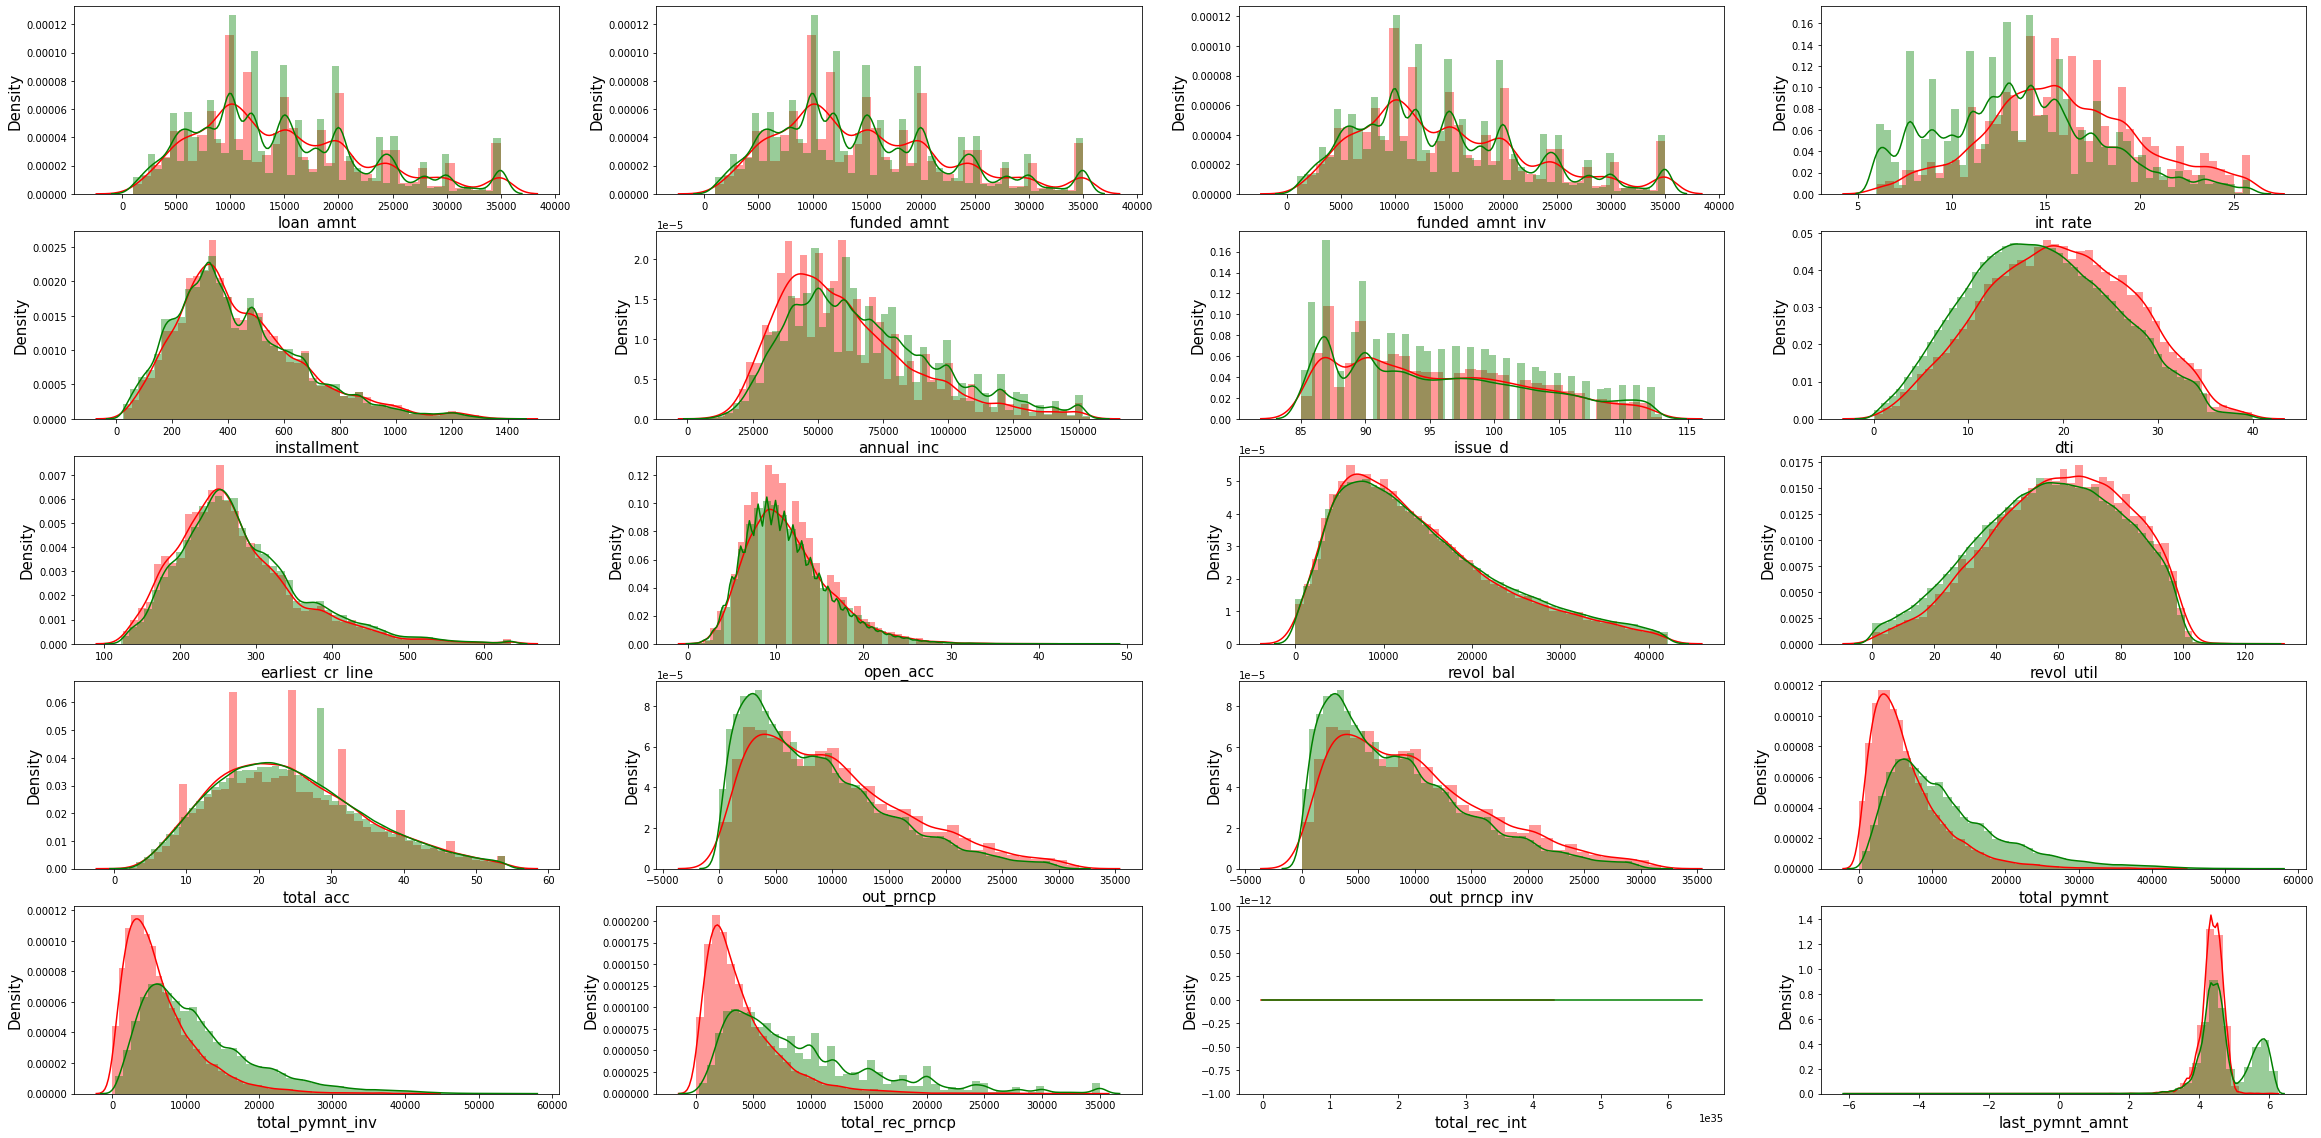

In [190]:
df = num_data_iqr_t
col = num_data_iqr_t.columns.tolist()

fig, axes = plt.subplots(len(col)//4, 4, figsize=(40, 20))
for d, ax in zip(col, axes.flatten()):
    p = sns.distplot(df.loc[(loan_data["good_bad"]==0), d], color="r", label="Bad", ax=ax)
    p = sns.distplot(df.loc[(loan_data["good_bad"]==1), d], color="g", label="Good", ax=ax)
    p.set_xlabel(d, fontsize = 15)
    p.set_ylabel("Density", fontsize = 15)
plt.show();

In [191]:
skew.iloc[:][skew['Skew']>44].T.columns.tolist()

['total_rev_hi_lim', 'total_rec_int']

In [ ]:
num_data_iqr_t.drop(
    skew.iloc[:][skew['Skew']>44].T.columns.tolist(), 
    inplace=True, axis=1
)

In [193]:
skew_feats = num_data_iqr_t.skew().sort_values(ascending=False)
skew = pd.DataFrame({'Skew':skew_feats})
skew

Skew
tot_cur_bal         1.452310
total_rec_prncp     1.434486
total_pymnt_inv     1.359064
total_pymnt         1.358608
earliest_cr_line    0.997724
out_prncp_inv       0.932462
out_prncp           0.932100
open_acc            0.915821
installment         0.893546
revol_bal           0.810075
annual_inc          0.733438
funded_amnt_inv     0.675049
loan_amnt           0.674619
funded_amnt         0.674618
total_acc           0.479568
issue_d             0.473862
int_rate            0.332143
dti                 0.167745
last_credit_pull_d  0.000000
last_pymnt_amnt    -0.066027
revol_util         -0.238952

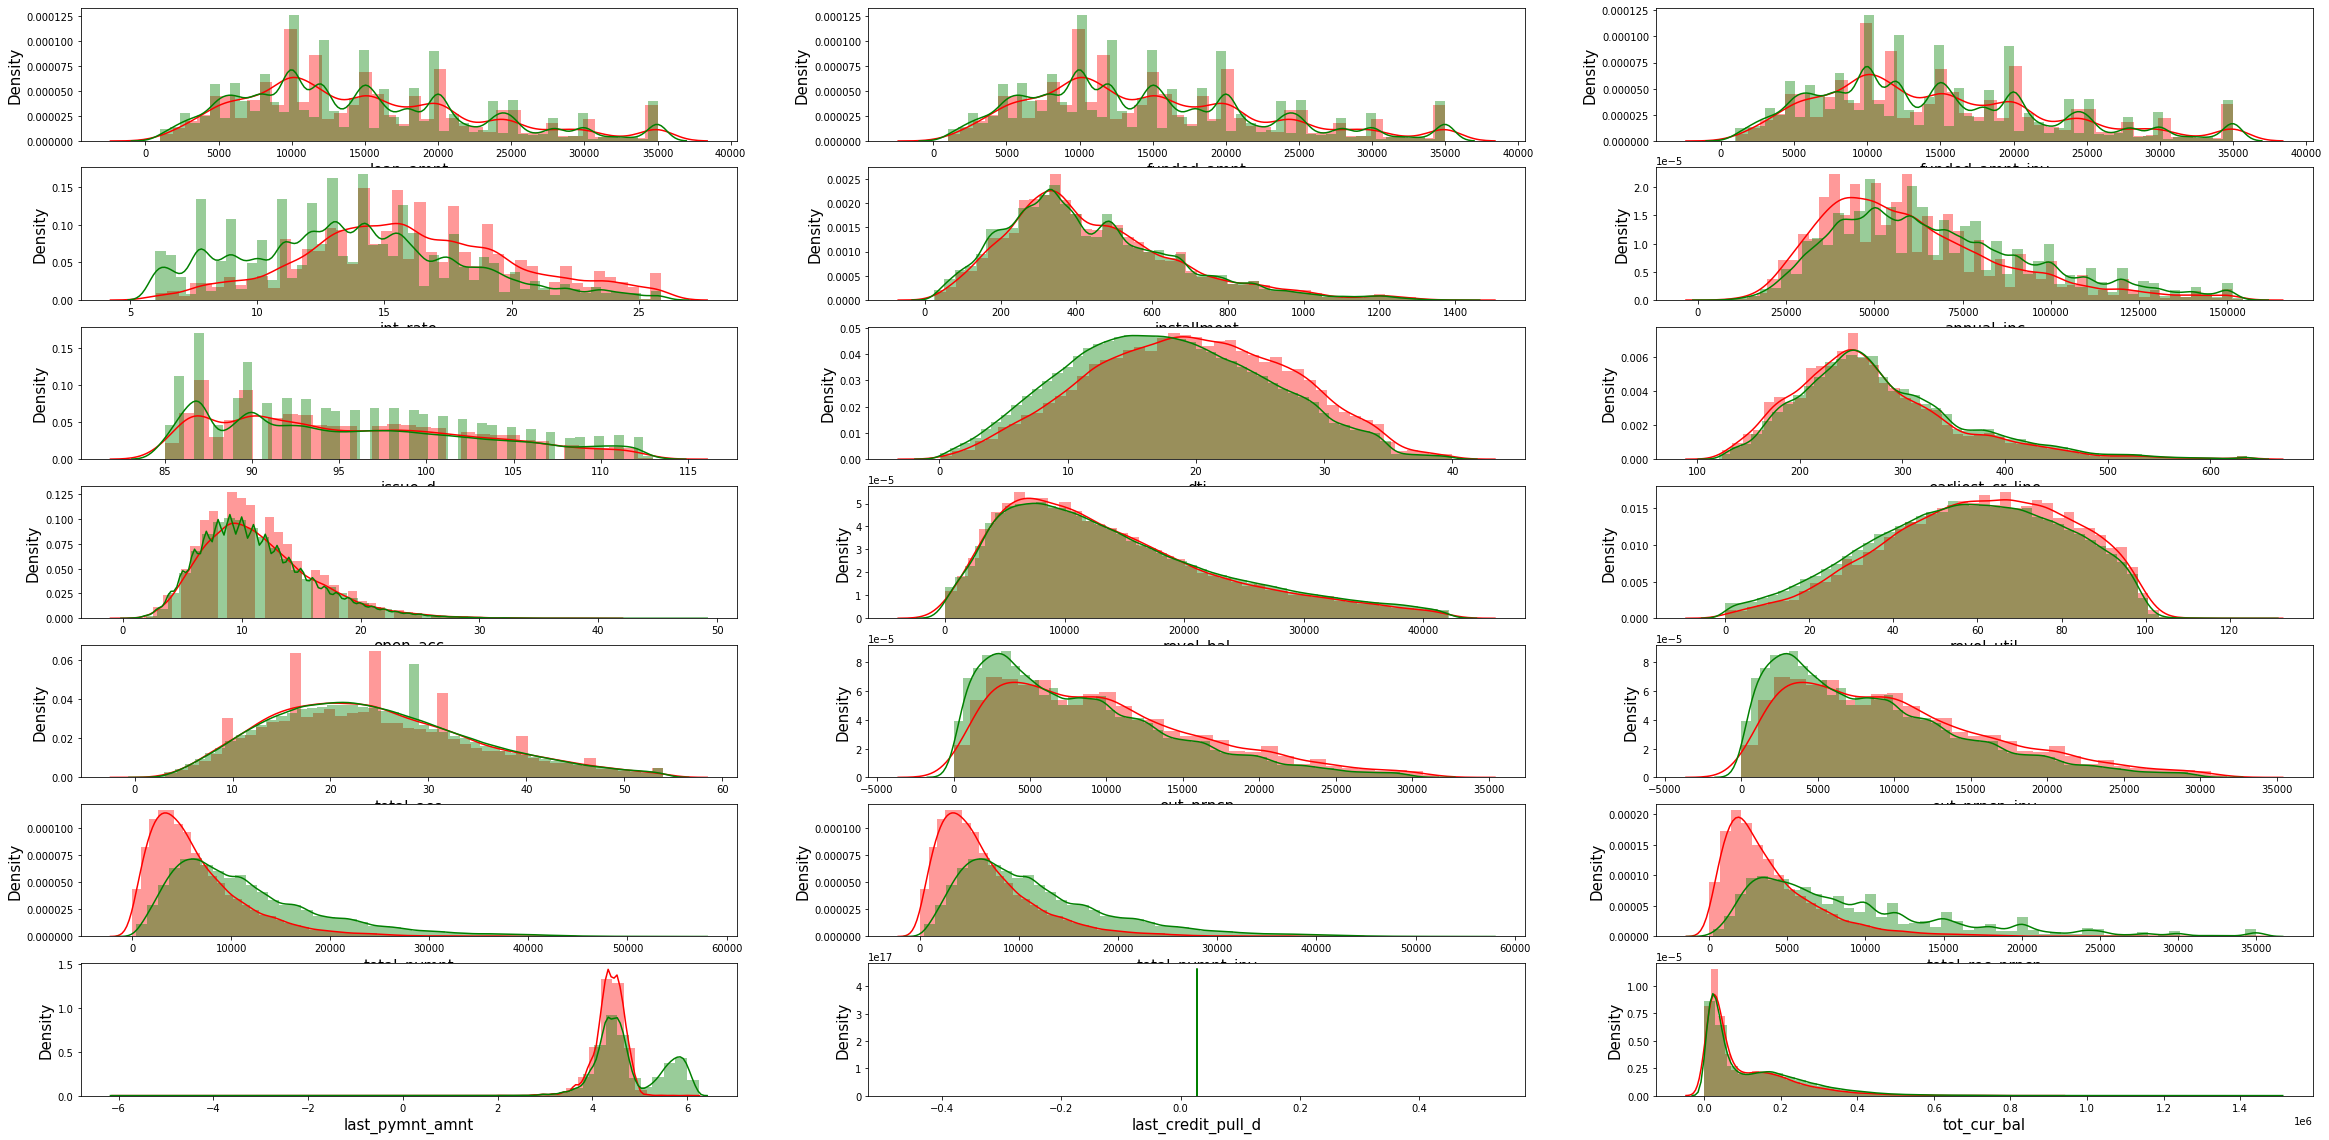

In [195]:
df = num_data_iqr_t
col = num_data_iqr_t.columns.tolist()

fig, axes = plt.subplots(len(col)//3, 3, figsize=(40, 20))
for d, ax in zip(col, axes.flatten()):
    p = sns.distplot(df.loc[(loan_data["good_bad"]==0), d], color="r", label="Bad", ax=ax)
    p = sns.distplot(df.loc[(loan_data["good_bad"]==1), d], color="g", label="Good", ax=ax)
    p.set_xlabel(d, fontsize = 15)
    p.set_ylabel("Density", fontsize = 15)
plt.show();

In [196]:
num_data_iqr_t.drop(
    columns='last_credit_pull_d', 
    inplace=True, axis=1
)

# **4. Data Preparation**

## **Encode data kategorik**

In [197]:
c = list(loan_data.select_dtypes(include=['object']).columns)

In [224]:
cat_data_a_en = cat_data_a.copy()
cat_data_a_en

term grade emp_length home_ownership verification_status  \
42535    36 months     B  10+ years            OWN            Verified   
42536    36 months     C     1 year           RENT        Not Verified   
42537    36 months     A  10+ years       MORTGAGE        Not Verified   
42538    36 months     B  10+ years           RENT     Source Verified   
42539    36 months     A    2 years       MORTGAGE        Not Verified   
...            ...   ...        ...            ...                 ...   
466280   60 months     C    4 years       MORTGAGE     Source Verified   
466281   60 months     D  10+ years       MORTGAGE            Verified   
466282   60 months     D    7 years       MORTGAGE            Verified   
466283   36 months     A    3 years            OWN            Verified   
466284   36 months     D  10+ years       MORTGAGE            Verified   

                   purpose initial_list_status  delinq_2yrs  inq_last_6mths  \
42535   debt_consolidation                   w          0.0             0.0   
42536   debt_consolidation                   f          0.0             0.0   
42537   debt_consolidation                   w          0.0             1.0   
42538   debt_consolidation                   w          0.0             0.0   
42539   debt_consolidation                   w          0.0             0.0   
...                    ...                 ...          ...             ...   
466280  debt_consolidation                   w          0.0             2.0   
466281  debt_consolidation                   f          0.0             5.0   
466282  debt_consolidation                   f          0.0             2.0   
466283         credit_card                   w          3.0             1.0   
466284               other                   f          1.0             0.0   

        acc_now_delinq  good_bad  
42535              0.0         1  
42536              0.0         1  
42537              0.0         1  
42538              0.0         1  
42539              0.0         1  
...                ...       ...  
466280             0.0         1  
466281             0.0         0  
466282             0.0         1  
466283             0.0         1  
466284             0.0         1  

[376775 rows x 11 columns]

### convert Employment Length jadi Integer

In [226]:
cat_data_a_en['emp_length'].value_counts()

10+ years    133072
2 years       33994
3 years       30159
< 1 year      28822
5 years       24826
1 year        24073
7 years       22766
4 years       22152
6 years       21750
8 years       19617
9 years       15544
Name: emp_length, dtype: int64

In [227]:
cat_data_a_en['emp_length'].dtypes

dtype('O')

In [228]:
cat_data_a_en['emp_length'] = cat_data_a_en['emp_length'].str.replace('\+ years', '')
cat_data_a_en['emp_length'] = cat_data_a_en['emp_length'].str.replace('< 1 year', str(0))
cat_data_a_en['emp_length'] = cat_data_a_en['emp_length'].str.replace(' years', '')
cat_data_a_en['emp_length'] = cat_data_a_en['emp_length'].str.replace(' year', '')

In [229]:
cat_data_a_en['emp_length'] = cat_data_a_en['emp_length'].astype('int')
cat_data_a_en['emp_length'].dtypes

dtype('int64')

In [230]:
cat_data_a_en['emp_length'].unique()

array([10,  1,  2,  4,  3,  7,  5,  6,  9,  8,  0])

In [234]:
cat_data_a_en.head()

term grade  emp_length home_ownership verification_status  \
42535   36 months     B          10            OWN            Verified   
42536   36 months     C           1           RENT        Not Verified   
42537   36 months     A          10       MORTGAGE        Not Verified   
42538   36 months     B          10           RENT     Source Verified   
42539   36 months     A           2       MORTGAGE        Not Verified   

                  purpose initial_list_status  delinq_2yrs  inq_last_6mths  \
42535  debt_consolidation                   w          0.0             0.0   
42536  debt_consolidation                   f          0.0             0.0   
42537  debt_consolidation                   w          0.0             1.0   
42538  debt_consolidation                   w          0.0             0.0   
42539  debt_consolidation                   w          0.0             0.0   

       acc_now_delinq  good_bad  
42535             0.0         1  
42536             0.0         1  
42537             0.0         1  
42538             0.0         1  
42539             0.0         1

In [243]:
cat_data_a_en['purpose'].unique()

array(['debt_consolidation', 'other', 'credit_card', 'personal',
       'small_business', 'major_purchase', 'medical', 'vacation',
       'renewable_energy'], dtype=object)

## One hot Encoding

In [ ]:
cat_data_a_en['purpose'].value_counts()

debt_consolidation    228540
credit_card            88596
home_improvement       20292
other                  16365
major_purchase          6357
small_business          3978
medical                 3285
car                     3040
moving                  1998
vacation                1772
house                   1500
wedding                  855
renewable_energy         197
Name: purpose, dtype: int64

In [ ]:
# categorical_cols = [col for col in list(loan_data.select_dtypes(include='object').columns)]
# loan_data_onehot = pd.get_dummies(loan_data[categorical_cols], drop_first=True)

In [244]:
# create a list of dummies of all the categorical variable
cat_data_a_en_onehot = [
    pd.get_dummies(cat_data_a_en['term'], prefix='term', prefix_sep=':'), 
    pd.get_dummies(cat_data_a_en['grade'], prefix='grade', prefix_sep=':'), 
    pd.get_dummies(cat_data_a_en['home_ownership'], prefix='home_ownership', prefix_sep=':'),
    pd.get_dummies(cat_data_a_en['purpose'], prefix='purpose', prefix_sep=':'),
    pd.get_dummies(cat_data_a_en['initial_list_status'], prefix='initial_list_status', prefix_sep=':'),
    pd.get_dummies(cat_data_a_en['verification_status'], prefix='verification_status', prefix_sep=':')
]

# convert dummy variable to dataframe
cat_data_a_en_onehot = pd.concat(cat_data_a_en_onehot, axis=1)
cat_data_a_en_onehot.head()

cat_data_a_en = pd.concat([cat_data_a_en, cat_data_a_en_onehot], axis=1)

In [247]:
cat_data_a_en.drop(columns=[
    'term', 
    'grade', 
    'home_ownership',
    'purpose',
    'initial_list_status',
    'verification_status'
],
inplace=True)

In [248]:
cat_data_a_en.head()

emp_length  delinq_2yrs  inq_last_6mths  acc_now_delinq  good_bad  \
42535          10          0.0             0.0             0.0         1   
42536           1          0.0             0.0             0.0         1   
42537          10          0.0             1.0             0.0         1   
42538          10          0.0             0.0             0.0         1   
42539           2          0.0             0.0             0.0         1   

       term: 36 months  term: 60 months  grade:A  grade:B  grade:C  grade:D  \
42535                1                0        0        1        0        0   
42536                1                0        0        0        1        0   
42537                1                0        1        0        0        0   
42538                1                0        0        1        0        0   
42539                1                0        1        0        0        0   

       grade:E  grade:F  grade:G  home_ownership:MORTGAGE  \
42535        0        0        0                        0   
42536        0        0        0                        0   
42537        0        0        0                        1   
42538        0        0        0                        0   
42539        0        0        0                        1   

       home_ownership:OTHER  home_ownership:OWN  home_ownership:RENT  \
42535                     0                   1                    0   
42536                     0                   0                    1   
42537                     0                   0                    0   
42538                     0                   0                    1   
42539                     0                   0                    0   

       purpose:credit_card  purpose:debt_consolidation  \
42535                    0                           1   
42536                    0                           1   
42537                    0                           1   
42538                    0                           1   
42539                    0                           1   

       purpose:major_purchase  purpose:medical  purpose:other  \
42535                       0                0              0   
42536                       0                0              0   
42537                       0                0              0   
42538                       0                0              0   
42539                       0                0              0   

       purpose:personal  purpose:renewable_energy  purpose:small_business  \
42535                 0                         0                       0   
42536                 0                         0                       0   
42537                 0                         0                       0   
42538                 0                         0                       0   
42539                 0                         0                       0   

       purpose:vacation  initial_list_status:f  initial_list_status:w  \
42535                 0                      0                      1   
42536                 0                      1                      0   
42537                 0                      0                      1   
42538                 0                      0                      1   
42539                 0                      0                      1   

       verification_status:Not Verified  verification_status:Source Verified  \
42535                                 0                                    0   
42536                                 1                                    0   
42537                                 1                                    0   
42538                                 0                                    1   
42539                                 1                                    0   

       verification_status:Verified  
42535                             1  
42536                             0  
42537                             0  


In [285]:
loan_data_mix = pd.concat([cat_data_a_en, num_data_iqr_t], axis=1)
loan_data_mix.head()

emp_length  delinq_2yrs  inq_last_6mths  acc_now_delinq  good_bad  \
42535          10          0.0             0.0             0.0         1   
42536           1          0.0             0.0             0.0         1   
42537          10          0.0             1.0             0.0         1   
42538          10          0.0             0.0             0.0         1   
42539           2          0.0             0.0             0.0         1   

       term: 36 months  term: 60 months  grade:A  grade:B  grade:C  grade:D  \
42535                1                0        0        1        0        0   
42536                1                0        0        0        1        0   
42537                1                0        1        0        0        0   
42538                1                0        0        1        0        0   
42539                1                0        1        0        0        0   

       grade:E  grade:F  grade:G  home_ownership:MORTGAGE  \
42535        0        0        0                        0   
42536        0        0        0                        0   
42537        0        0        0                        1   
42538        0        0        0                        0   
42539        0        0        0                        1   

       home_ownership:OTHER  home_ownership:OWN  home_ownership:RENT  \
42535                     0                   1                    0   
42536                     0                   0                    1   
42537                     0                   0                    0   
42538                     0                   0                    1   
42539                     0                   0                    0   

       purpose:credit_card  purpose:debt_consolidation  \
42535                    0                           1   
42536                    0                           1   
42537                    0                           1   
42538                    0                           1   
42539                    0                           1   

       purpose:major_purchase  purpose:medical  purpose:other  \
42535                       0                0              0   
42536                       0                0              0   
42537                       0                0              0   
42538                       0                0              0   
42539                       0                0              0   

       purpose:personal  purpose:renewable_energy  purpose:small_business  \
42535                 0                         0                       0   
42536                 0                         0                       0   
42537                 0                         0                       0   
42538                 0                         0                       0   
42539                 0                         0                       0   

       purpose:vacation  initial_list_status:f  initial_list_status:w  \
42535                 0                      0                      1   
42536                 0                      1                      0   
42537                 0                      0                      1   
42538                 0                      0                      1   
42539                 0                      0                      1   

       verification_status:Not Verified  verification_status:Source Verified  \
42535                                 0                                    0   
42536                                 1                                    0   
42537                                 1                                    0   
42538                                 0                                    1   
42539                                 1                                    0   

       verification_status:Verified  loan_amnt  funded_amnt  funded_amnt_inv  \
42535                             1    27050.0      27050.0          270

In [286]:
# loan_data_mix.iloc[:][]
loan_data_mix.isnull().sum()
# loan_data_mix.iloc[:][pd.DataFrame(loan_data_mix.isnull().sum())>0]

emp_length                                  0
delinq_2yrs                                 0
inq_last_6mths                              0
acc_now_delinq                              0
good_bad                                    0
term: 36 months                             0
term: 60 months                             0
grade:A                                     0
grade:B                                     0
grade:C                                     0
grade:D                                     0
grade:E                                     0
grade:F                                     0
grade:G                                     0
home_ownership:MORTGAGE                     0
home_ownership:OTHER                        0
home_ownership:OWN                          0
home_ownership:RENT                         0
purpose:credit_card                         0
purpose:debt_consolidation                  0
purpose:major_purchase                      0
purpose:medical                   

## Split data

In [287]:
loan_data_mix.dropna(subset=[
    'loan_amnt',
'funded_amnt',
'funded_amnt_inv',
'int_rate',
'installment',
'annual_inc',
'issue_d',
'dti',
'earliest_cr_line',
'open_acc',
'revol_bal',
'revol_util',
'total_acc',
'out_prncp',
'out_prncp_inv',
'total_pymnt',
'total_pymnt_inv',
'total_rec_prncp',
'tot_cur_bal',
'last_pymnt_amnt'
], inplace=True)

In [288]:
loan_data_mix.isnull().sum()

emp_length                             0
delinq_2yrs                            0
inq_last_6mths                         0
acc_now_delinq                         0
good_bad                               0
term: 36 months                        0
term: 60 months                        0
grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
grade:G                                0
home_ownership:MORTGAGE                0
home_ownership:OTHER                   0
home_ownership:OWN                     0
home_ownership:RENT                    0
purpose:credit_card                    0
purpose:debt_consolidation             0
purpose:major_purchase                 0
purpose:medical                        0
purpose:other                          0
purpose:personal                       0
purpose:renewabl

In [289]:
X = loan_data_mix.drop('good_bad', axis=1)
y = loan_data_mix['good_bad']

X.shape, y.shape

((164342, 51), (164342,))

In [290]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, y, 
                                                test_size=0.2, random_state=42)

In [291]:
print('trainX: ', trainX.shape, 'trainY: ', trainY.shape, 'testX: ', testX.shape, 'testY: ', testY.shape)

trainX:  (131473, 51) trainY:  (131473,) testX:  (32869, 51) testY:  (32869,)


## Feature Scaling menggunakan MinMaxScaler

In [292]:
from sklearn.preprocessing import MinMaxScaler

In [293]:
scaler = MinMaxScaler()
scaler.fit(trainX)

MinMaxScaler()

In [294]:
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)

In [295]:
pd.DataFrame(trainX_scaled, columns=trainX.columns)

emp_length  delinq_2yrs  inq_last_6mths  acc_now_delinq  \
0              0.0     0.000000           0.000             0.0   
1              1.0     0.000000           0.000             0.0   
2              0.8     0.000000           0.000             0.0   
3              1.0     0.000000           0.125             0.0   
4              0.7     0.000000           0.000             0.0   
...            ...          ...             ...             ...   
131468         0.1     0.000000           0.000             0.0   
131469         0.1     0.000000           0.000             0.0   
131470         0.2     0.041667           0.125             0.0   
131471         0.5     0.083333           0.125             0.0   
131472         1.0     0.000000           0.000             0.0   

        term: 36 months  term: 60 months  grade:A  grade:B  grade:C  grade:D  \
0                   0.0              1.0      0.0      0.0      0.0      1.0   
1                   0.0              1.0      0.0      1.0      0.0      0.0   
2                   1.0              0.0      0.0      1.0      0.0      0.0   
3                   1.0              0.0      0.0      0.0      1.0      0.0   
4                   1.0              0.0      0.0      1.0      0.0      0.0   
...                 ...              ...      ...      ...      ...      ...   
131468              0.0              1.0      0.0      0.0      1.0      0.0   
131469              0.0              1.0      0.0      0.0      1.0      0.0   
131470              0.0              1.0      0.0      0.0      0.0      1.0   
131471              0.0              1.0      0.0      0.0      0.0      1.0   
131472              1.0              0.0      1.0      0.0      0.0      0.0   

        grade:E  grade:F  grade:G  home_ownership:MORTGAGE  \
0           0.0      0.0      0.0                      1.0   
1           0.0      0.0      0.0                      1.0   
2           0.0      0.0      0.0                      0.0   
3           0.0      0.0      0.0                      1.0   
4           0.0      0.0      0.0                      0.0   
...         ...      ...      ...                      ...   
131468      0.0      0.0      0.0                      0.0   
131469      0.0      0.0      0.0                      1.0   
131470      0.0      0.0      0.0                      1.0   
131471      0.0      0.0      0.0                      0.0   
131472      0.0      0.0      0.0                      0.0   

        home_ownership:OTHER  home_ownership:OWN  home_ownership:RENT  \
0                        0.0                 0.0                  0.0   
1                        0.0                 0.0                  0.0   
2                        0.0                 0.0                  1.0   
3                        0.0                 0.0                  0.0   
4                        0.0                 0.0                  1.0   
...                      ...                 ...                  ...   
131468                   0.0                 1.0                  0.0   
131469                   0.0                 0.0                  0.0   
131470                   0.0                 0.0                  0.0   
131471                   0.0                 0.0                  1.0   
131472                   0.0                 0.0                  1.0   

        purpose:credit_card  purpose:debt_consolidation  \
0                       0.0                         1.0   
1                       0.0                         1.0   
2                       1.0                         0.0   
3                       0.0                         0.0   
4                       1.0                         0.0   
...                     ...                         ...   
131468                  0.0                         1.0   
131469                  0.0                         1.0   
131470                  0.0                         1.0   
131471                  0.0   

## Feature Selection menggunakan SelectKBest regression

In [296]:
from sklearn.feature_selection import SelectKBest, f_regression

In [297]:
select_reg = SelectKBest(k=10, score_func=f_regression)
select_reg.fit(trainX_scaled, trainY)               

trainX_new = select_reg.transform(trainX_scaled)         
testX_new = select_reg.transform(testX_scaled)

trainX_new.shape, testX_new.shape

((131473, 10), (32869, 10))

In [298]:
kept_features = pd.DataFrame({'columns': trainX.columns,
                              'Kept': select_reg.get_support(),
                              'score': select_reg.scores_})
kept_features.set_index("columns")

Kept       score
columns                                               
emp_length                           False   14.209097
delinq_2yrs                          False   10.696073
inq_last_6mths                        True  129.095648
acc_now_delinq                       False    2.521951
term: 36 months                      False   65.569820
term: 60 months                      False   65.569820
grade:A                               True  369.591198
grade:B                               True  133.999284
grade:C                              False    5.800877
grade:D                               True  186.652142
grade:E                               True  202.703857
grade:F                               True  134.660674
grade:G                              False   54.230439
home_ownership:MORTGAGE              False   42.855224
home_ownership:OTHER                 False    0.135316
home_ownership:OWN                   False    1.530357
home_ownership:RENT                  False   54.452010
purpose:credit_card                  False   51.536524
purpose:debt_consolidation           False   24.567593
purpose:major_purchase               False    0.137916
purpose:medical                      False    1.682347
purpose:other                        False    5.239396
purpose:personal                     False    1.099595
purpose:renewable_energy             False    0.299129
purpose:small_business               False   17.961886
purpose:vacation                     False    0.562463
initial_list_status:f                False    0.200318
initial_list_status:w                False    0.200318
verification_status:Not Verified     False   55.834392
verification_status:Source Verified  False   15.694183
verification_status:Verified         False   12.193461
loan_amnt                            False   11.469712
funded_amnt                          False   11.469759
funded_amnt_inv                      False   11.509073
int_rate                              True  950.595845
installment                          False   29.053040
annual_inc                           False   86.012832
issue_d                              False    0.099452
dti                                  False   79.520111
earliest_cr_line                     False   64.060371
open_acc                             False   13.848855
revol_bal                            False   63.708689
revol_util                           False   29.575294
total_acc                            False    0.472378
out_prncp                             True  231.425604
out_prncp_inv                         True  231.459902
total_pymnt                          False   78.325858
total_pymnt_inv                      False   78.252807
total_rec_prncp                       True  251.048529
last_pymnt_amnt                      False   31.074765
tot_cur_bal                          False   55.497567

In [299]:
new_df = trainX.iloc[:,select_reg.get_support()]
new_df

inq_last_6mths  grade:A  grade:B  grade:D  grade:E  grade:F  int_rate  \
171118             0.0        0        0        1        0        0     19.05   
43703              0.0        0        1        0        0        0     13.53   
403064             0.0        0        1        0        0        0     11.99   
375499             1.0        0        0        0        0        0     13.35   
54545              0.0        0        1        0        0        0     11.99   
...                ...      ...      ...      ...      ...      ...       ...   
364716             0.0        0        0        0        0        0     13.35   
332366             0.0        0        0        0        0        0     14.49   
390168             1.0        0        0        1        0        0     16.99   
423751             1.0        0        0        1        0        0     19.47   
368868             0.0        1        0        0        0        0      6.03   

        out_prncp  out_prncp_inv  total_rec_prncp  
171118   11157.89       11157.89          9792.11  
43703     8138.42        8138.42          3861.58  
403064    4399.17        4399.17          4600.83  
375499    5218.69        5218.69          4781.31  
54545     2065.92        2057.31          3934.08  
...           ...            ...              ...  
364716   12640.96       12640.96          3859.04  
332366   27488.89       27488.89          7511.11  
390168   13078.11       13040.37          4246.89  
423751   12044.41       12044.41          3955.59  
368868    6431.34        6431.34          6568.66  

[131473 rows x 10 columns]

In [301]:
new_df.shape

(131473, 10)

In [302]:
new_df.describe()

inq_last_6mths        grade:A        grade:B        grade:D  \
count   131473.000000  131473.000000  131473.000000  131473.000000   
mean         0.662258       0.162117       0.283693       0.166232   
std          0.955482       0.368559       0.450791       0.372290   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          1.000000       0.000000       1.000000       0.000000   
max          8.000000       1.000000       1.000000       1.000000   

             grade:E        grade:F       int_rate      out_prncp  \
count  131473.000000  131473.000000  131473.000000  131473.000000   
mean        0.076495       0.026013      13.756262    8553.954971   
std         0.265789       0.159174       4.357454    6295.233390   
min         0.000000       0.000000       6.000000       0.030000   
25%         0.000000       0.000000      10.640000    3434.780000   
50%         0.000000       0.000000      13.650000    7205.100000   
75%         0.000000       0.000000      16.290000   12235.190000   
max         1.000000       1.000000      25.890000   31681.540000   

       out_prncp_inv  total_rec_prncp  
count  131473.000000    131473.000000  
mean     8551.087526      6373.374215  
std      6293.785184      4328.417094  
min         0.030000       264.600000  
25%      3434.370000      3306.370000  
50%      7203.030000      5246.010000  
75%     12232.040000      8267.900000  
max     31681.540000     34998.170000

# **5. Training Model**

In [303]:
(trainX_new.shape, trainY.shape),(testX_new.shape, testY.shape)

(((131473, 10), (131473,)), ((32869, 10), (32869,)))

In [304]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [305]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

### Tanpa parameter tunning

In [306]:
knn.fit(trainX_new, trainY)
y_pred = knn.predict(testX_new)


print(classification_report(testY, y_pred))
print(f"Train score = {knn.score(trainX_new, trainY)}, Test score = {knn.score(testX_new, testY)}")
print(f"ROC AUC = {roc_auc_score(testY, y_pred)}")

              precision    recall  f1-score   support

           0       0.35      0.01      0.02      1106
           1       0.97      1.00      0.98     31763

    accuracy                           0.97     32869
   macro avg       0.66      0.50      0.50     32869
weighted avg       0.95      0.97      0.95     32869

Train score = 0.9683965529043986, Test score = 0.9660774590039247
ROC AUC = 0.5046580435035954


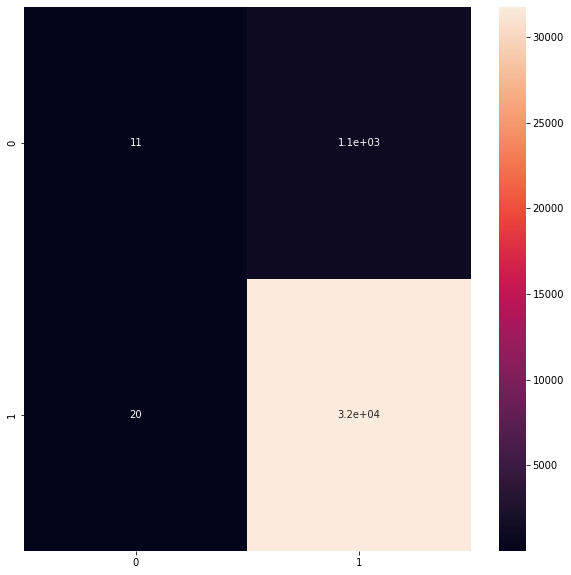

In [307]:
c = confusion_matrix(y_true=testY, y_pred=y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(c, annot=True)
plt.show()

### parameter tunning menggunakan GridSearch

In [308]:
## dengan parameter tunning
from sklearn.model_selection import GridSearchCV

k_range = list(range(1, 10))
distances = [1, 2, 3]
param_grid = dict(n_neighbors=k_range, p=distances)

grid = GridSearchCV(knn, param_grid, cv=3, n_jobs=-1, verbose=1)  
grid_search = grid.fit(trainX_new, trainY)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [309]:
y_pred_grid = grid_search.predict(testX_new)

print(classification_report(testY, y_pred_grid))
print(f"Train score = {grid_search.score(trainX_new, trainY)}, Test score = {grid_search.score(testX_new, testY)}")
print(f"ROC AUC = {roc_auc_score(testY, y_pred_grid)}")

              precision    recall  f1-score   support

           0       0.20      0.00      0.00      1106
           1       0.97      1.00      0.98     31763

    accuracy                           0.97     32869
   macro avg       0.58      0.50      0.49     32869
weighted avg       0.94      0.97      0.95     32869

Train score = 0.9674990302191324, Test score = 0.9662600018254283
ROC AUC = 0.5003891132215148


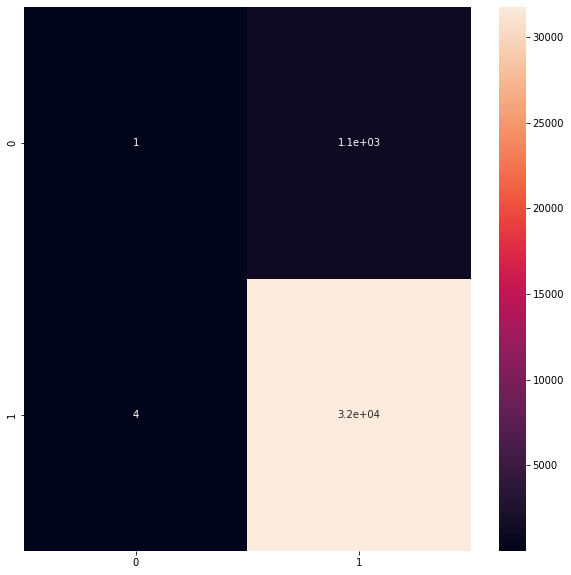

In [310]:
c = confusion_matrix(y_true=testY, y_pred=y_pred_grid)

plt.figure(figsize=(10, 10))
sns.heatmap(c, annot=True)
plt.show()

In [311]:
print(f"Best Parameter = {grid_search.best_params_, grid_search.best_score_}")

Best Parameter = ({'n_neighbors': 9, 'p': 3}, 0.9672936647973075)


In [312]:
pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
26       0.196829      0.005225        94.032926        4.111485   
25       0.195720      0.000876        10.271704        1.284225   
24       0.190841      0.002774        11.766216        1.551284   
19       0.201757      0.015251        10.379659        1.665211   
18       0.199282      0.009269        11.574689        1.471609   
20       0.196089      0.002637       108.438356       18.913840   
22       0.194757      0.004514        10.083323        1.255390   
23       0.196641      0.003299       108.824481       17.953585   
21       0.191358      0.003539        12.049685        1.316024   
13       0.196020      0.005357        10.027266        1.240124   
14       0.194916      0.001374       106.177638       18.084990   
12       0.197198      0.005838        11.289828        1.374543   
17       0.200285      0.013455       106.884148       17.793812   
15       0.190862      0.002606        11.970125        1.270780   
16       0.197893      0.003430        10.051624        1.146145   
8        0.201331      0.003420       104.977200       17.614590   
7        0.198327      0.002551         9.875691        1.162994   
6        0.205423      0.008963        11.205851        1.298987   
10       0.197446      0.002188         9.868311        1.197357   
11       0.199543      0.004035       104.819661       16.627818   
9        0.193747      0.002179        11.916586        1.207922   
1        0.208617      0.007007        10.472784        1.097494   
2        0.203508      0.006173       101.231040       13.807286   
0        0.221663      0.013036        11.609167        2.142292   
5        0.201659      0.005903       102.522831       15.630844   
4        0.195870      0.002768         9.539015        1.070350   
3        0.198339      0.000918        10.828577        1.593035   

   param_n_neighbors param_p                      params  split0_test_score  \
26                 9       3  {'n_neighbors': 9, 'p': 3}           0.967302   
25                 9       2  {'n_neighbors': 9, 'p': 2}           0.967279   
24                 9       1  {'n_neighbors': 9, 'p': 1}           0.967256   
19                 7       2  {'n_neighbors': 7, 'p': 2}           0.967188   
18                 7       1  {'n_neighbors': 7, 'p': 1}           0.967233   
20                 7       3  {'n_neighbors': 7, 'p': 3}           0.967210   
22                 8       2  {'n_neighbors': 8, 'p': 2}           0.967279   
23                 8       3  {'n_neighbors': 8, 'p': 3}           0.967210   
21                 8       1  {'n_neighbors': 8, 'p': 1}           0.967119   
13                 5       2  {'n_neighbors': 5, 'p': 2}           0.966800   
14                 5       3  {'n_neighbors': 5, 'p': 3}           0.966937   
12                 5       1  {'n_neighbors': 5, 'p': 1}           0.966914   
17                 6       3  {'n_neighbors': 6, 'p': 3}           0.966458   
15                 6       1  {'n_neighbors': 6, 'p': 1}           0.966321   
16                 6       2  {'n_neighbors': 6, 'p': 2}           0.966275   
8                  3       3  {'n_neighbors': 3, 'p': 3}           0.965111   
7                  3       2  {'n_neighbors': 3, 'p': 2}           0.964883   
6                  3       1  {'n_neighbors': 3, 'p': 1}           0.965066   
10                 4       2  {'n_neighbors': 4, 'p': 2}           0.962031   
11                 4       3  {'n_neighbors': 4, 'p': 3}           0.962282   
9                  4       1  {'n_neighbors': 4, 'p': 1}           0.961848   
1                  1       2  {'n_neighbors': 1, 'p': 2}           0.948705   
2                  1       3  {'n_neighbors': 1, 'p': 3}           0.948066   
0                  1       1  {'n_neighbors': 1, 'p': 1}           0.948614   
5                  2       3  {'n_neighbors': 2, 'p': 3}           0.925454   
4                  2       2  {'n_neighbors':

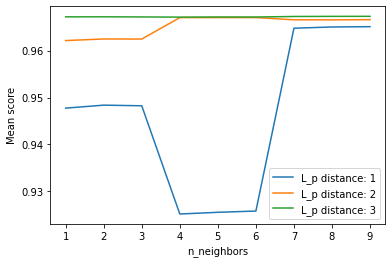

In [313]:
scores = [x for x in grid_search.cv_results_["mean_test_score"]]
scores = np.array(scores).reshape(len(distances), len(k_range))

for ind, i in enumerate(distances):
    plt.plot(k_range, scores[ind], label='L_p distance: ' + str(i))
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Mean score')
plt.show()